# Label studio 
This file is used to help create the precise fine-tune annotations using Label Studio. The process is: 
<ul>
<li> We use a rough model to create rough annotations for each test instance
<li> Load these into Label Studio
<li> Correct the labels with the help of RGB and NGB images and Google Earth pro 
<li> Save the precise test annotations
</ul>
After obtianing the precise test annotations, we append them to the test instances in 3_model_data.ipynb

In [17]:
from label_studio_sdk import Client
from label_studio_converter import brush

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

import importlib
import utils
importlib.reload(utils)

base_path = '../data/'

LABEL_STUDIO_URL = 'http://localhost:8080'
API_KEY = '15242b278b8437ea3ddc0f383ece4791fa4a4d1e'

ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

In [18]:
import requests

# Function to get the project ID by project name
def get_project_id_by_name(project_name):
    url = f'{LABEL_STUDIO_URL}/api/projects/'
    headers = {
        'Authorization': f'Token {API_KEY}'
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors

    projects = response.json().get('results', [])
    for project in projects:
        if project['title'] == project_name:
            return project['id']
    return None

# Example usage
project_name = 'Finetune annotations 0'
project_id = get_project_id_by_name(project_name)
if project_id:
    print(f'The project ID for "{project_name}" is {project_id}')
else:
    print(f'Project "{project_name}" not found')

The project ID for "Finetune annotations 0" is 7


# SWED

In [36]:
water_percentages = pd.read_csv(f'{base_path}swed_water_percentages.csv')

#get first 100 filenames 
filenames = water_percentages['filename'].values[:100]
paths = [f'{base_path}SWED finetune rough/{filename}' for filename in filenames]

In [43]:
preds = []
for i in range(len(paths)):
    all_bands = np.load(paths[i])
    preds.append(utils.get_mask_from_bands(all_bands, 
                                            satellite='sentinel',
                                            rgb_bands=["nir", "green", "blue"],
                                            index_name="NDWI",
                                            
                                            threshold=0, 
                                            method='slic', 
                                            n_segments=1000,
                                            sigma = 1))
    
preds = 1 - np.array(preds)  # for the purpose of labelling, land is the positive class
#preds = (np.array(preds) * 255.0).astype(np.uint8)
print("Shape of predcitions: " + str(preds.shape))

Shape of predcitions: (100, 256, 256)


In [45]:
# Get all tasks to label
project_name = 'SWED Finetune 0'
id = get_project_id_by_name(project_name)
project = ls.get_project(id)
tasks_ids = project.get_tasks_ids()
print("Number of task in project: " + str(len(tasks_ids)))
print("First task id: " + str(tasks_ids[0]))

Number of task in project: 100
First task id: 1309


In [46]:
# Apply predictions to tasks
for i in range(len(preds)):
    mask = preds[i].astype(np.uint8)
    mask = np.where(mask == 1, 255, 0)

    rle = brush.mask2rle(mask)
    project.create_prediction(
        task_id=tasks_ids[i],
        model_version=None,
        result=[
            {
                "from_name": "brush_labels_tag",
                "to_name": "image",
                "type": "brushlabels",
                'value': {"format": "rle", "rle": rle, "brushlabels":['land']},
            }
        ],
    )

# LICS

# Step 1: sort the fine-tuning files 
These are then loaded to label studio 

In [2]:
# Separate finetuning images into 5 groups of 100 images. Each group will have 1 image from each scene. 

# make 5 directories 
for i in range(5):
    os.makedirs(base_path + f'finetune to label/finetune_{i}', exist_ok=True)

#load scenes dataset 
scenes = pd.read_csv(base_path + 'label_scenes.csv')
scene_id = scenes['id'].values

# move images to each directory
for id in scene_id:
    files = glob.glob(base_path + f'finetune to label/{id}*')
    for f in files:
        i = f.split('.png')[0][-1]
        os.rename(f, base_path + f'finetune to label/finetune_{i}/' + os.path.basename(f))

# count number of images in each directory
for i in range(5):
    print(f'finetune_{i}: {len(glob.glob(base_path + f"finetune to label/finetune_{i}/*"))}')


finetune_0: 100
finetune_1: 100
finetune_2: 100
finetune_3: 100
finetune_4: 100


## Step 2: Use rough model to create initial annotations

In [31]:
import torch 
import network
import train

# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# set variables for evaluation
target_pos = 8
incl_bands = [0,1,2,3,4,5,6]


# Load model from LICS paper
model = network.U_Net(7,2).to(device)
state_dict = torch.load(f'../../models/LANDSAT-UNET-12MAY24.pth', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)


Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [109]:
import evaluation as eval

def create_labels(i):
    """Create labels for finetuning images"""

    # get paths for first set of images 
    paths = []
    for id in scene_id:
        paths.append(base_path + f'finetune/{id}_{i}.npy')

    targets, preds = eval.get_preds(model, paths, batch_size=10, target_pos=target_pos, incl_bands=incl_bands, satellite="landsat", perm_bands=None, device=device)
    preds = np.array(preds) - 1 # for the purpose of labelling, land is the positive class
    # scale predictions to 0-255
    preds = (preds * 255.0).astype(np.uint8)
    print("Shape of predcitions: " + str(preds.shape))

    # Get all tasks to label
    project_name = f'Finetune annotations {i}'
    id = get_project_id_by_name(project_name)
    project = ls.get_project(id)
    tasks_ids = project.get_tasks_ids()
    print("Number of task in project: " + str(len(tasks_ids)))
    print("First task id: " + str(tasks_ids[0]))

    # Apply predictions to tasks
    for i in range(len(preds)):
        mask = preds[i].astype(np.uint8)
        mask = np.where(mask == 1, 255, 0)
    
        rle = brush.mask2rle(mask)
        project.create_prediction(
            task_id=tasks_ids[i],
            model_version=None,
            result=[
                {
                    "from_name": "brush_labels_tag",
                    "to_name": "image",
                    "type": "brushlabels",
                    'value': {"format": "rle", "rle": rle, "brushlabels":['land']},
                }
            ],
        )
        
        """project.create_prediction(
            task_id=tasks_ids[i],
            model_version=None,
            result=[
                {
                    "from_name": "brush_labels_tag",
                    "to_name": "image",
                    "type": "brushlabels",
                    'value': {"format": "rle", "rle": rle, "brushlabels":'land'},
                }
            ],
        )"""

In [110]:
# load predictions to label studio
create_labels(0)

Shape of predcitions: (100, 256, 256)
Number of task in project: 100
First task id: 806


In [111]:
create_labels(1)
create_labels(2)
create_labels(3)
create_labels(4)

Shape of predcitions: (100, 256, 256)
Number of task in project: 100
First task id: 906
Shape of predcitions: (100, 256, 256)
Number of task in project: 100
First task id: 1006
Shape of predcitions: (100, 256, 256)
Number of task in project: 100
First task id: 1106
Shape of predcitions: (100, 256, 256)
Number of task in project: 100
First task id: 1206


# Plot summary charts to help with labelling

In [4]:
import json
final_crop = json.load(open("../data/"+ 'finetune_crop_details.json'))

In [5]:
def plot_test_summary(id,i):
    fig, ax = plt.subplots(1,2,figsize=(10,20))
    # Get lat long of crop
    img = np.load(f'../data/finetune/{id}_{i}.npy')

    lat,long = final_crop[id]['coordinates'][0]

    print(id, lat, long)

    rgb = utils.get_rgb(img, contrast=0.2)
    igb = utils.get_rgb(img, contrast=0.2, bands=['nir','green','blue'])

    ax[0].imshow(rgb)
    ax[0].set_title(id)
    ax[1].imshow(igb)
    ax[1].set_title(str((lat,long)))

LT05_L2SP_208023_20050306_20200902_02_T1 52.63296596527077 -9.47903388395178


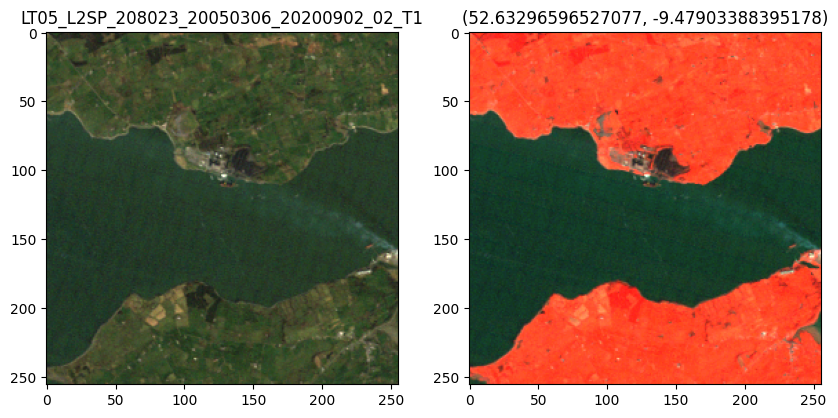

In [97]:
ft = 0
i = 95
id = scene_id[i]

plot_test_summary(id,ft)

100


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_1054/3334159878.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1,figsize=(10,10))


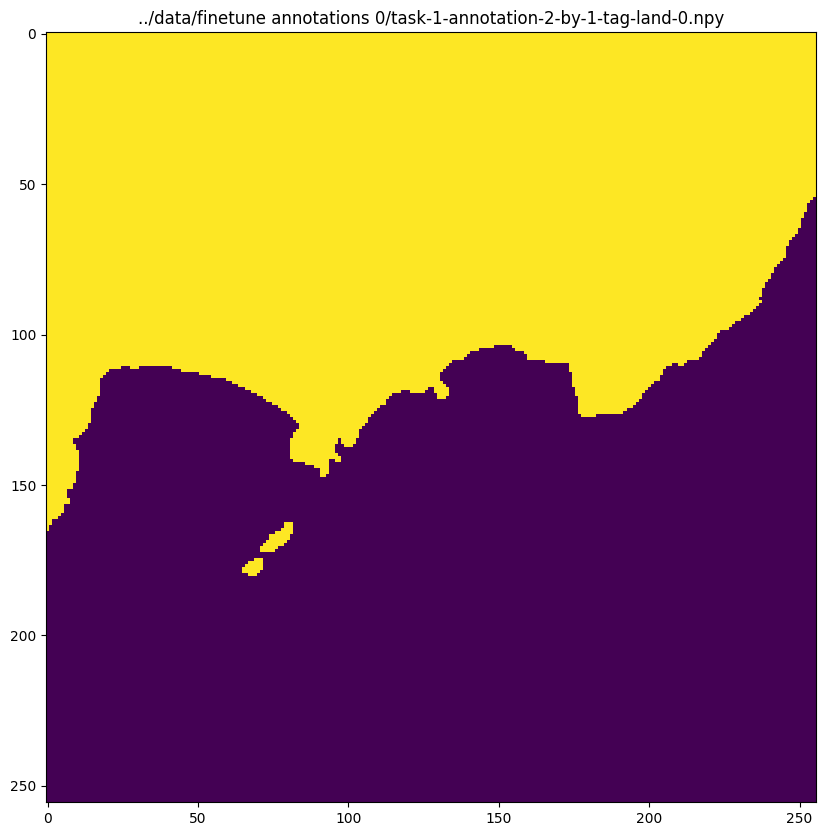

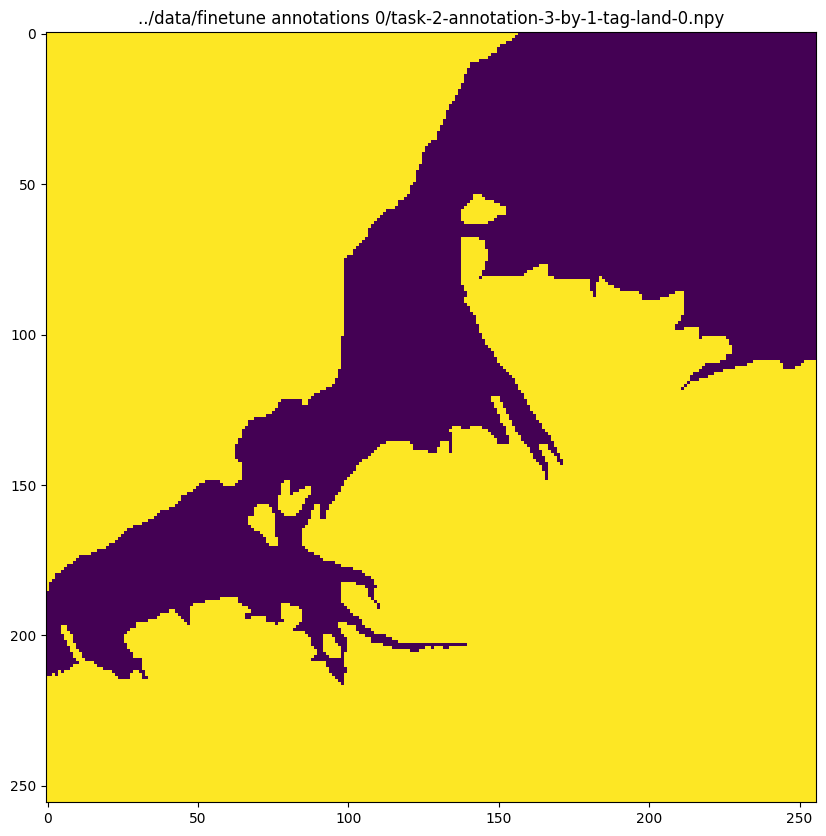

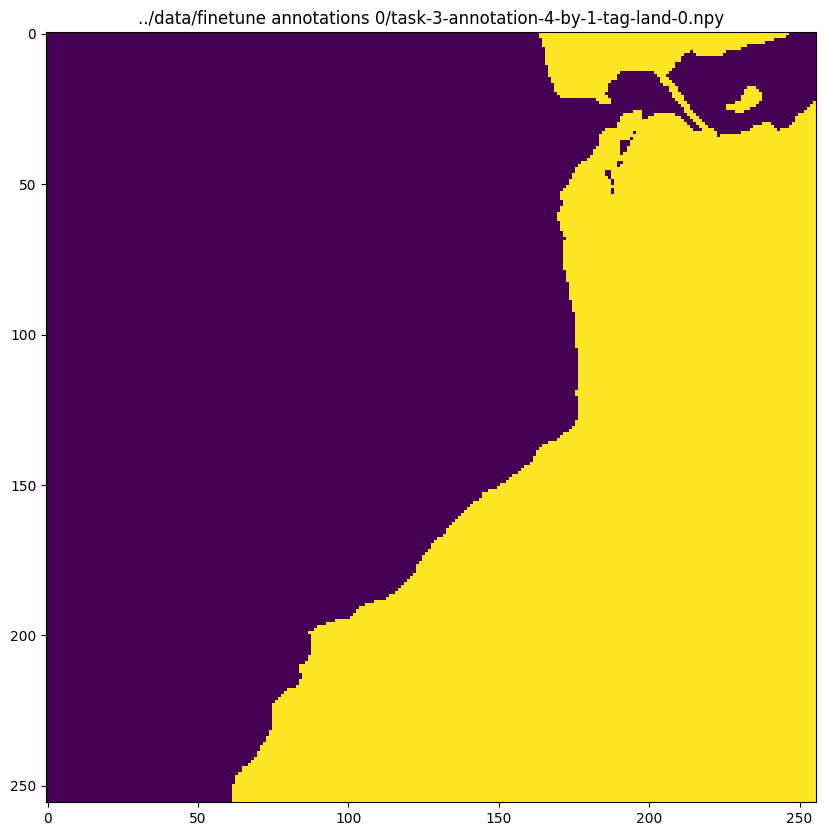

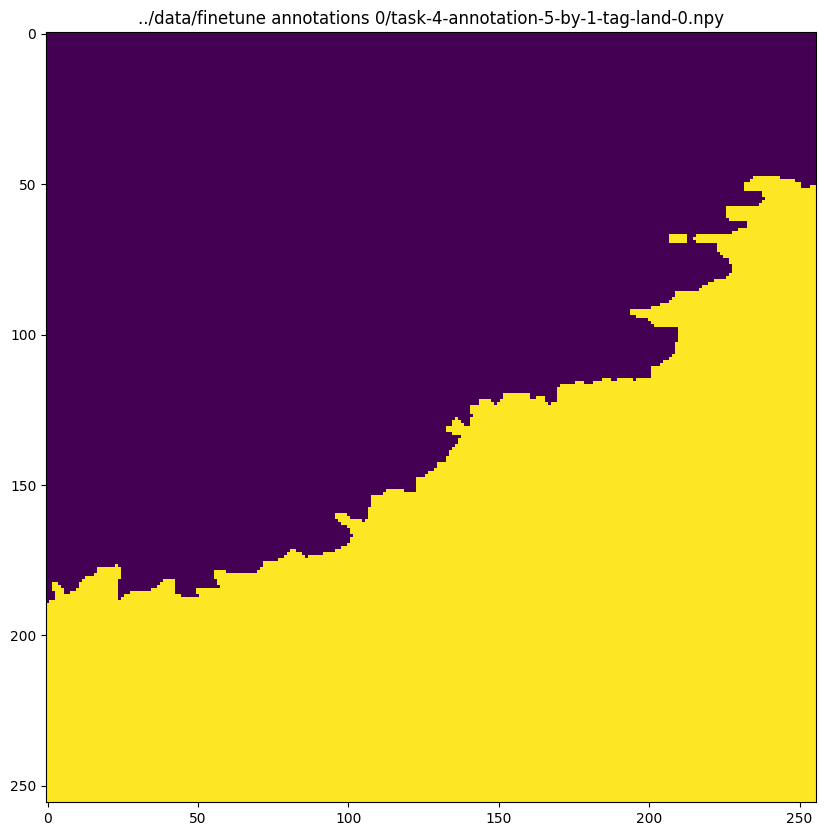

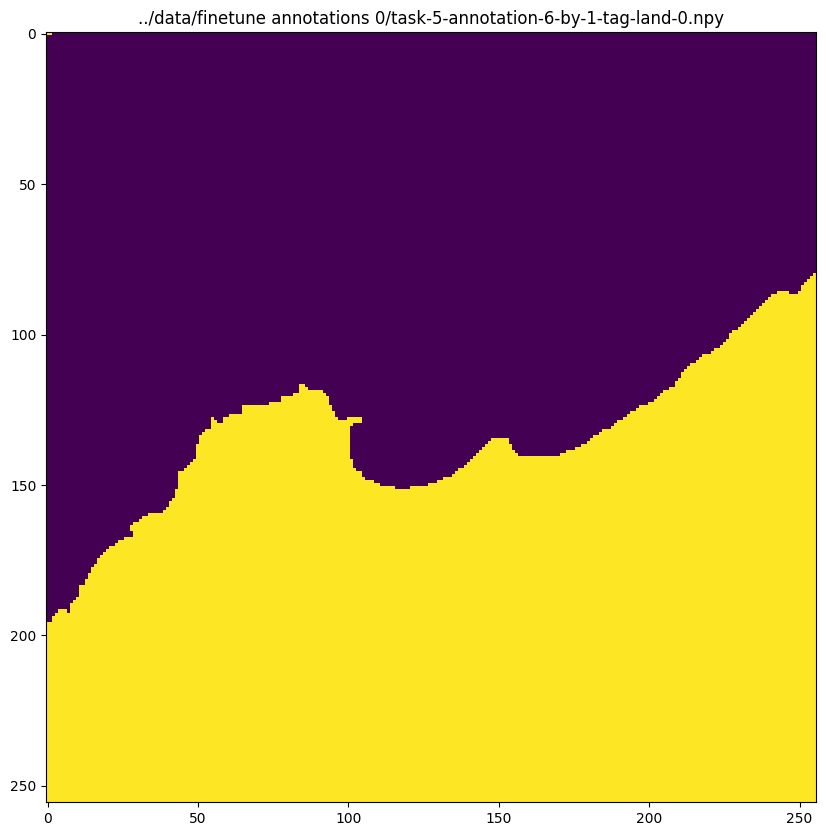

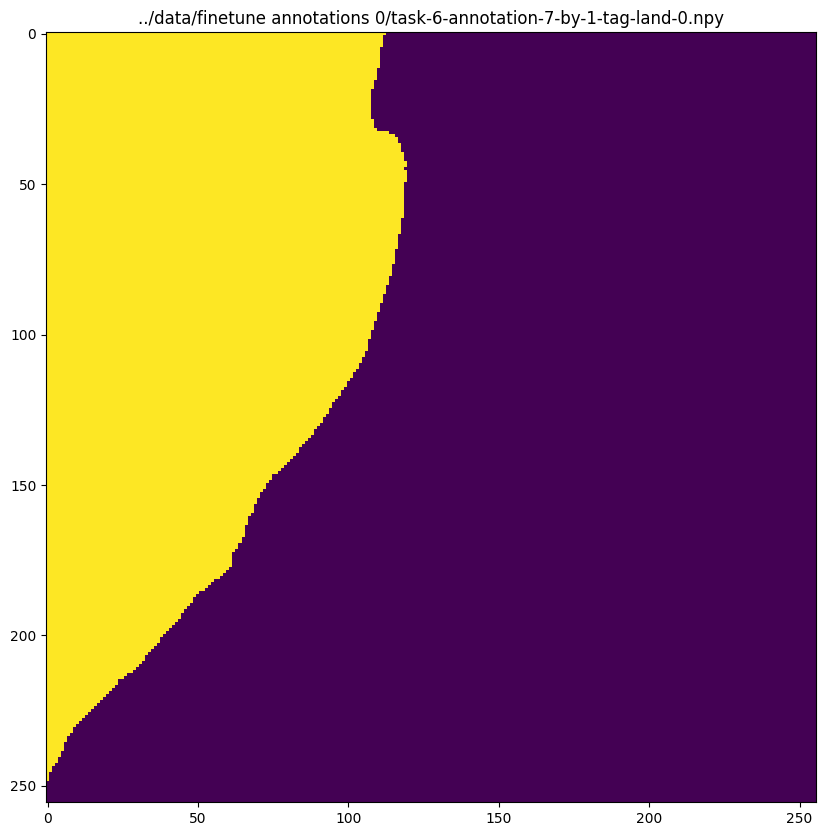

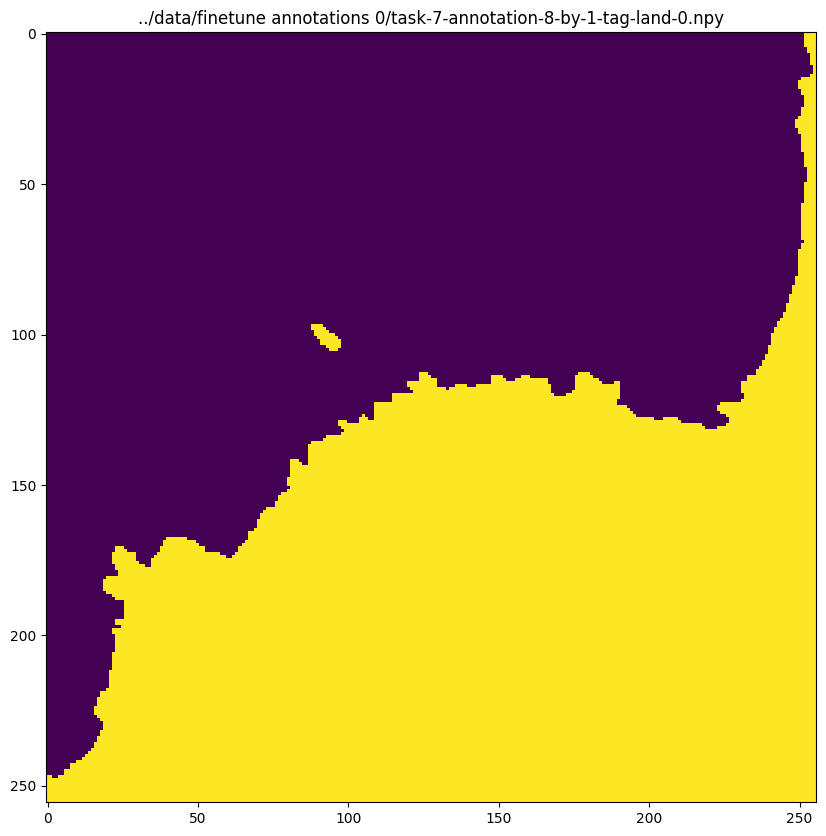

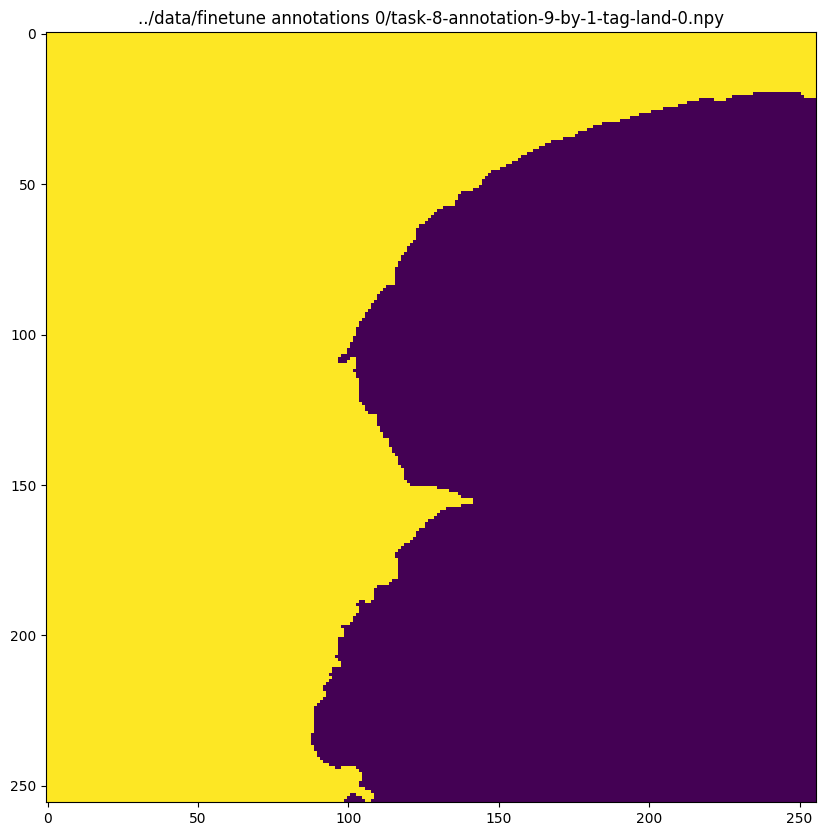

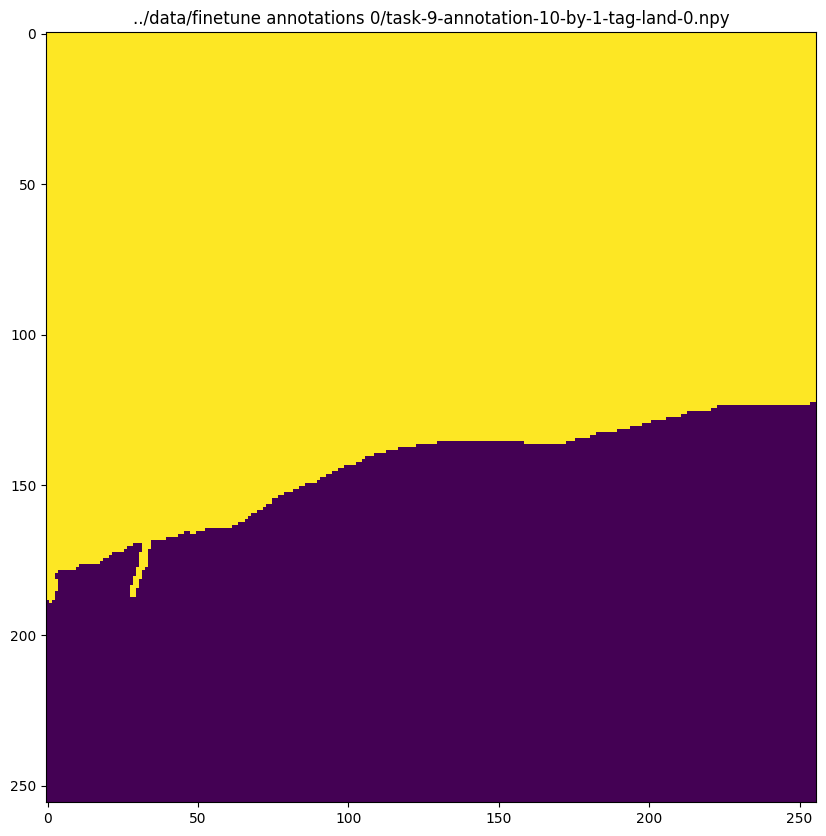

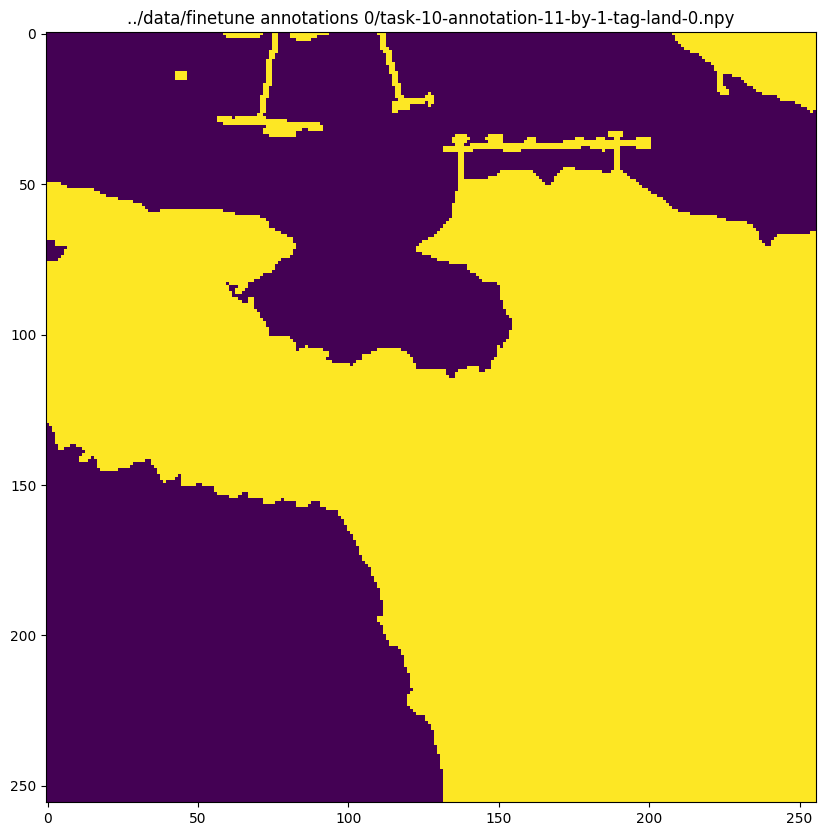

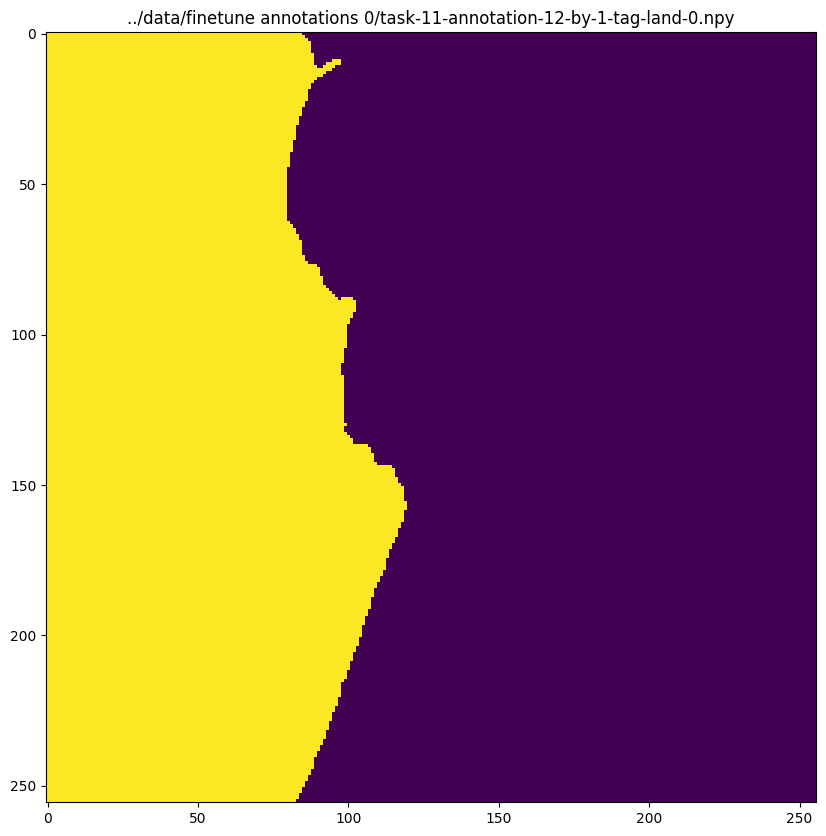

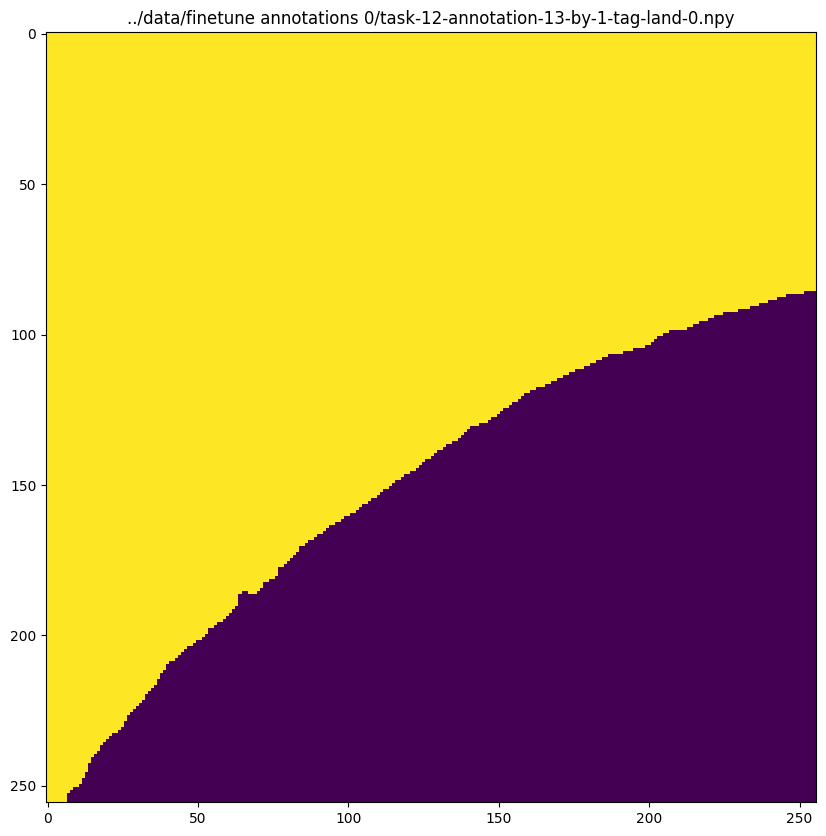

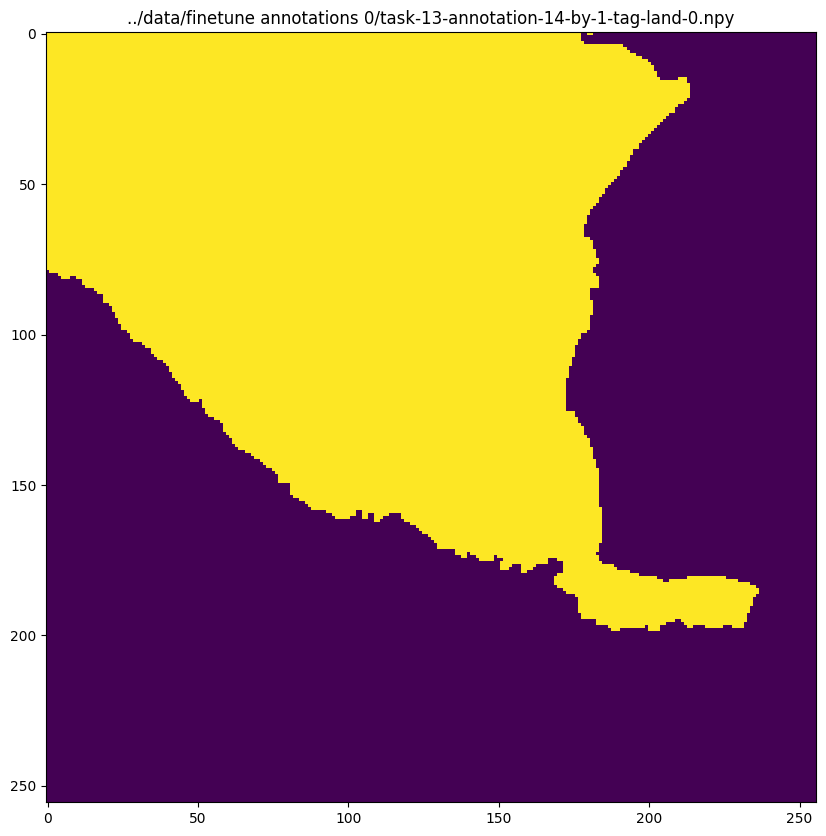

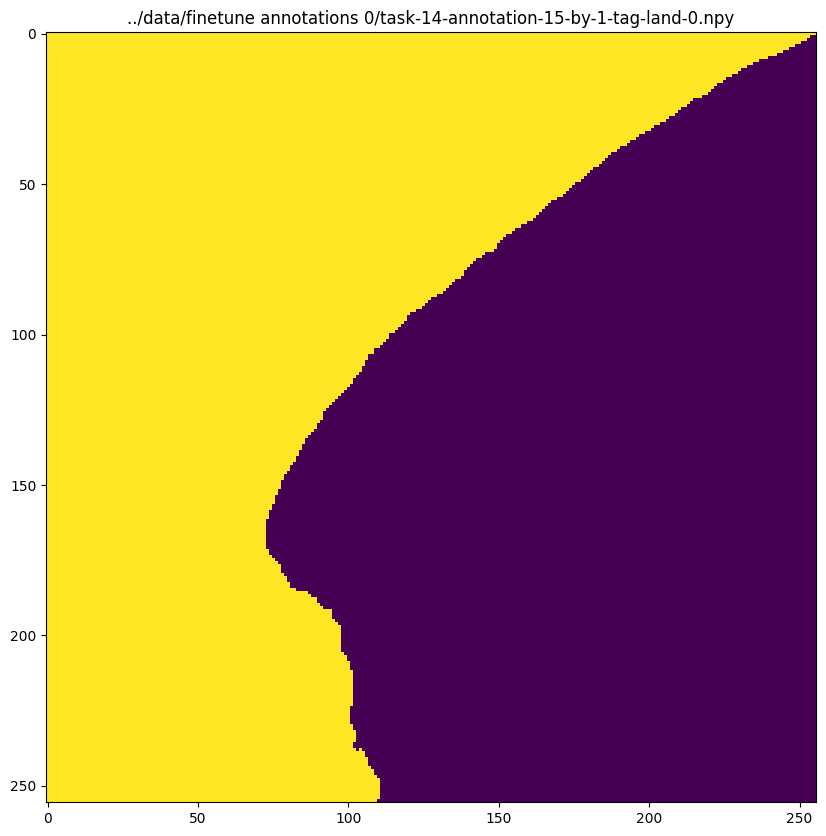

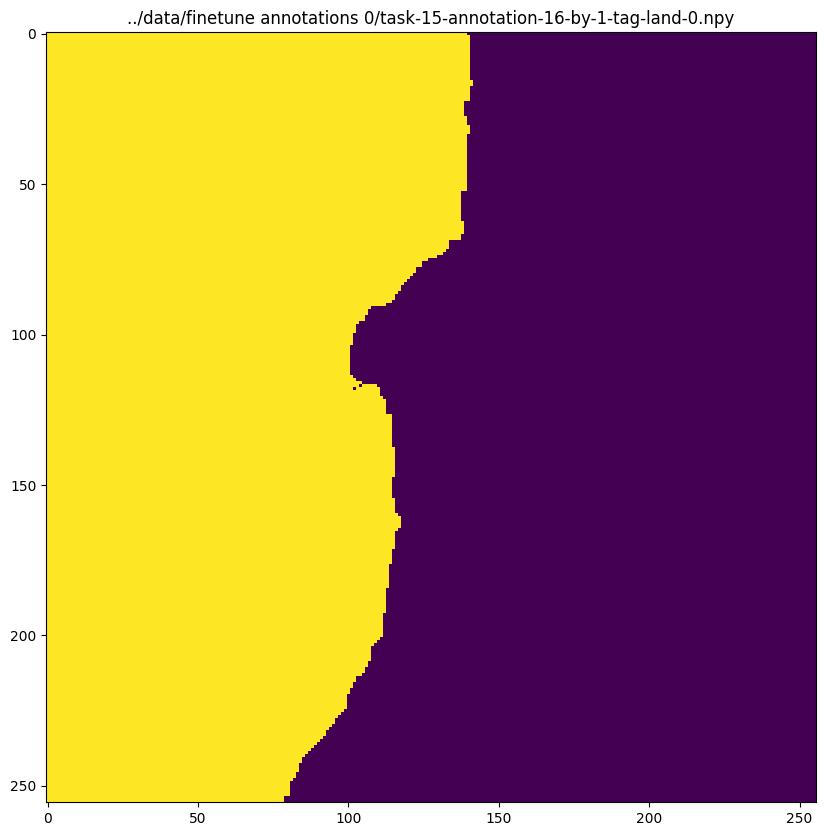

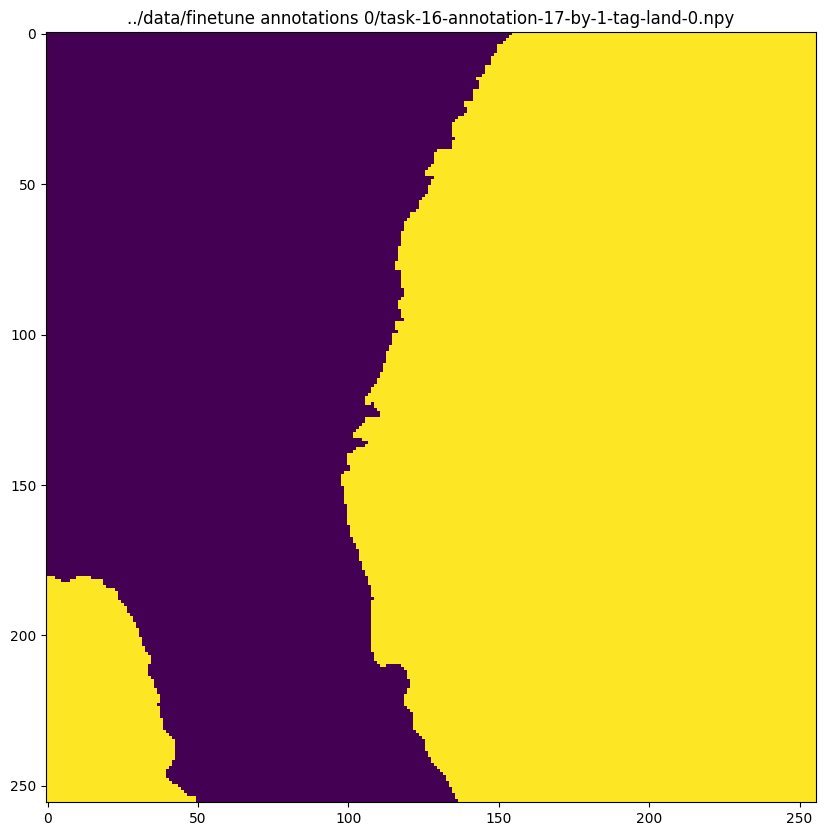

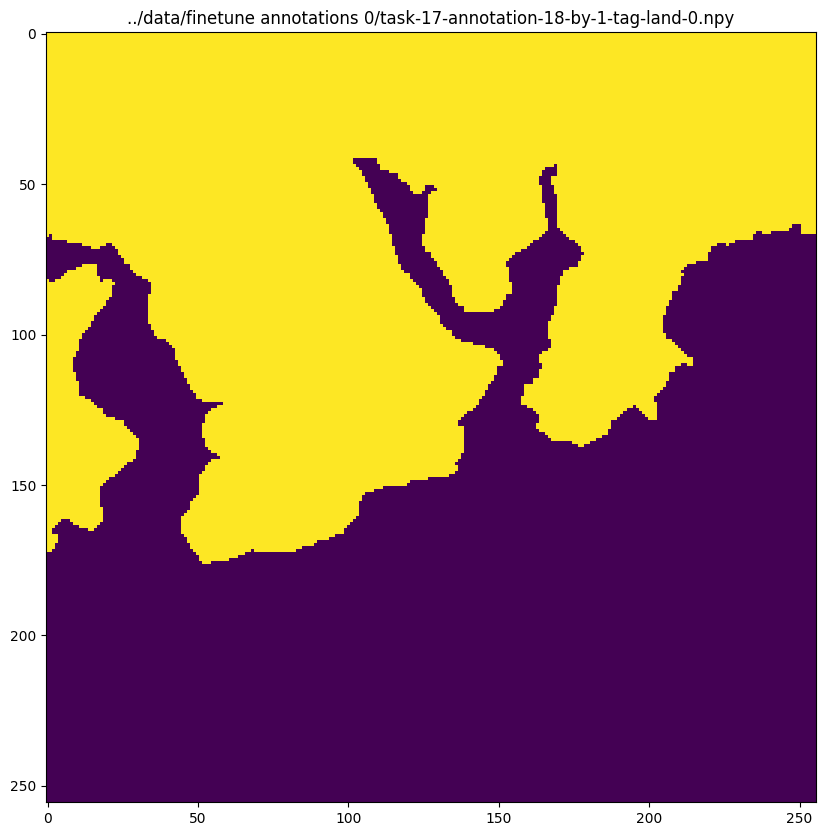

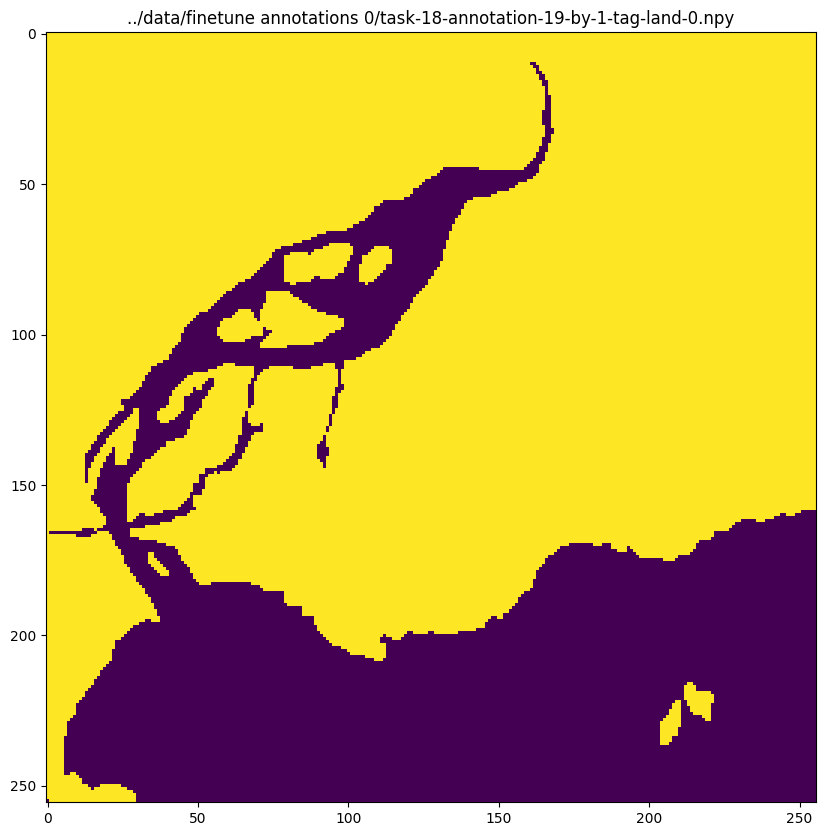

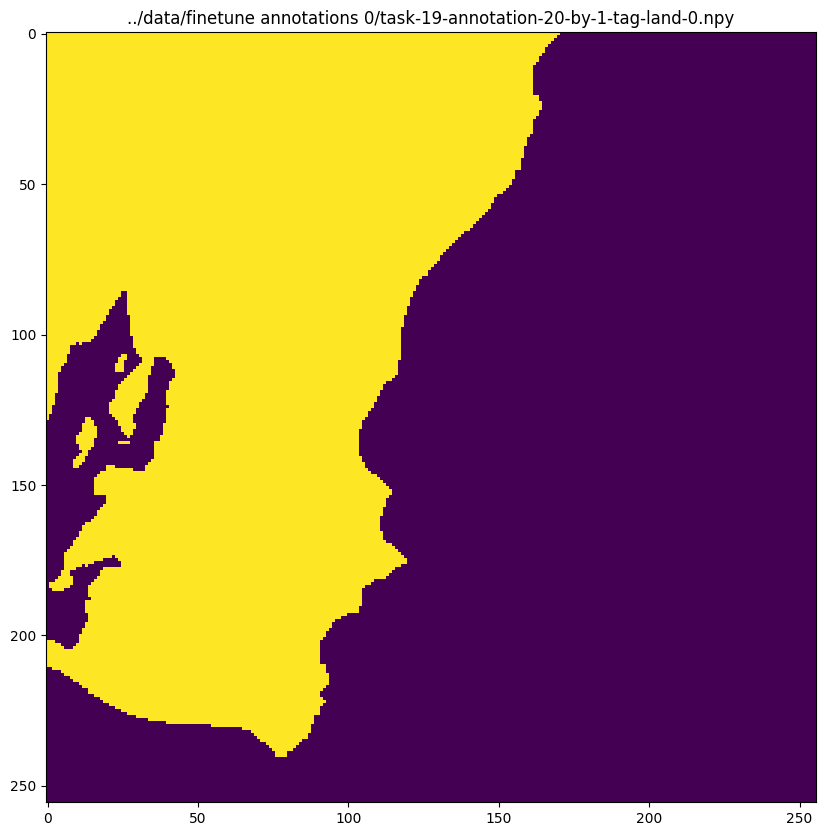

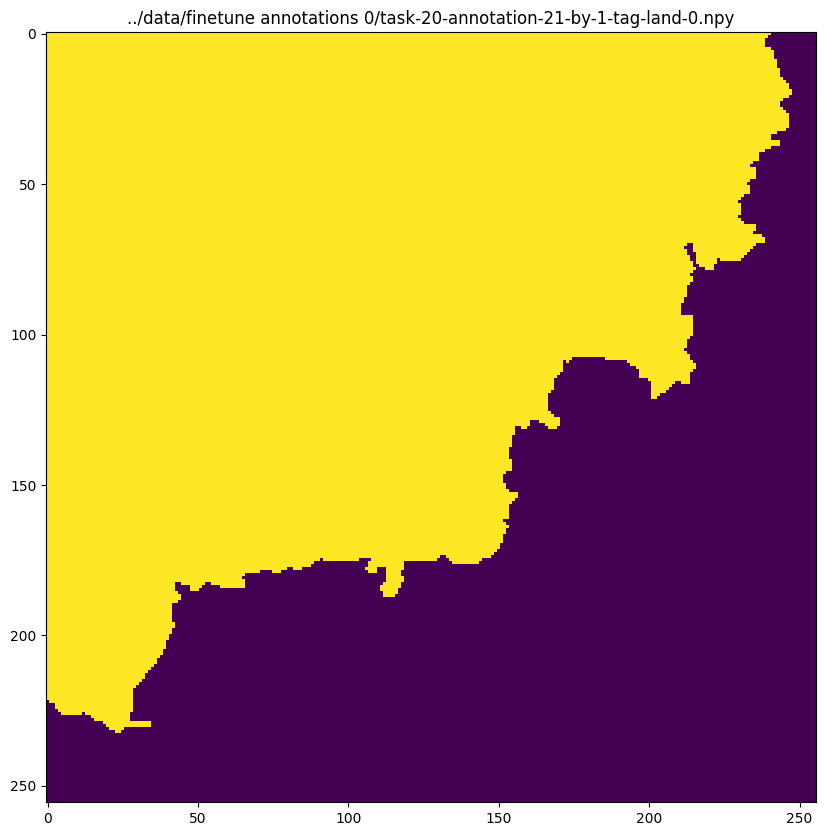

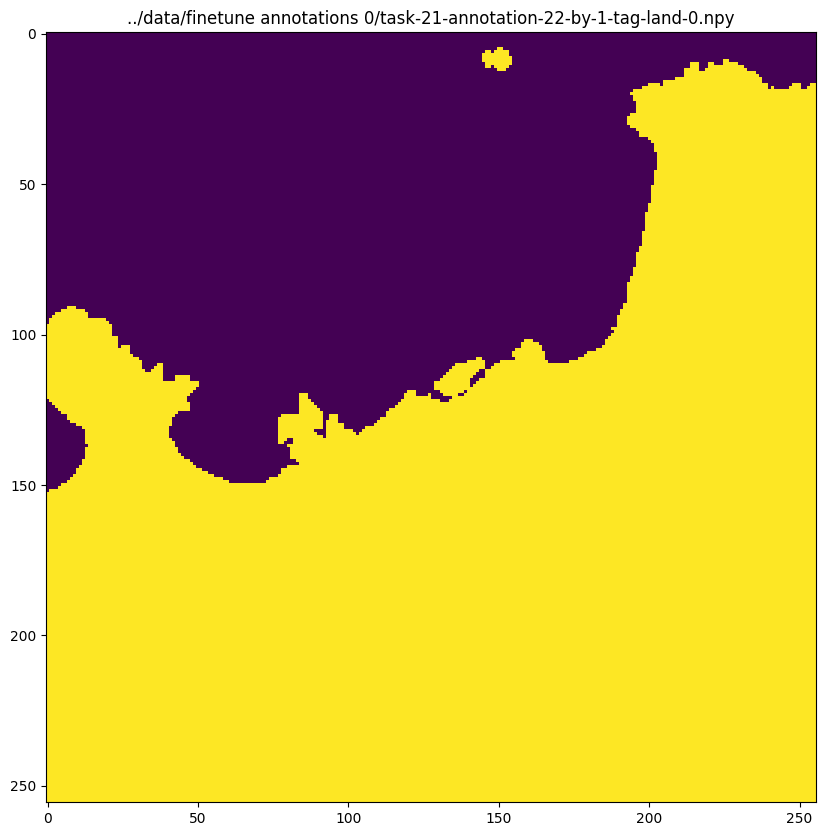

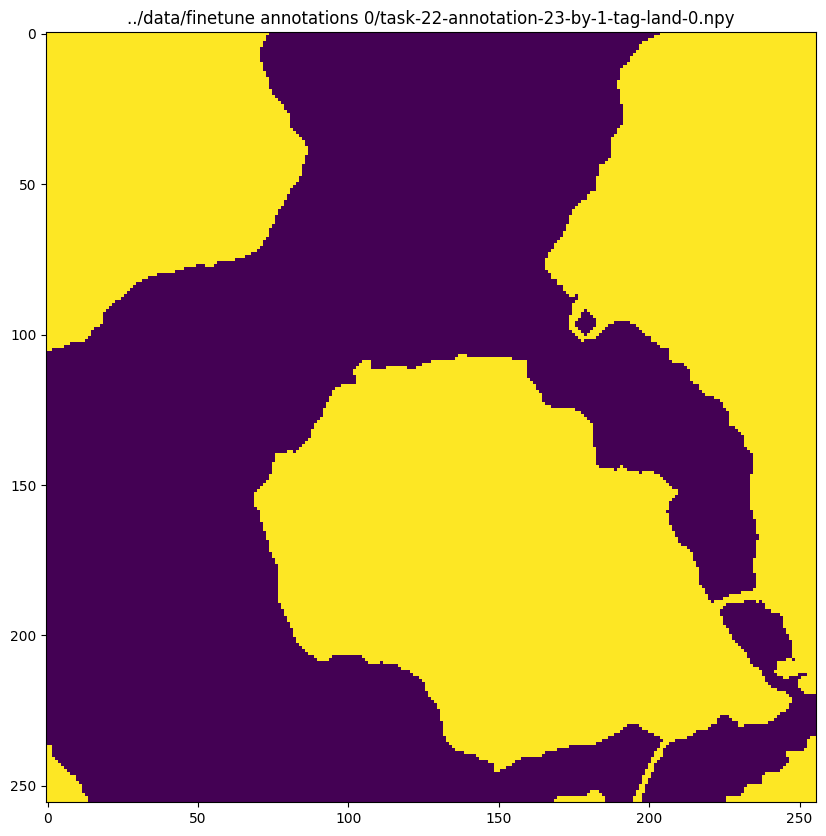

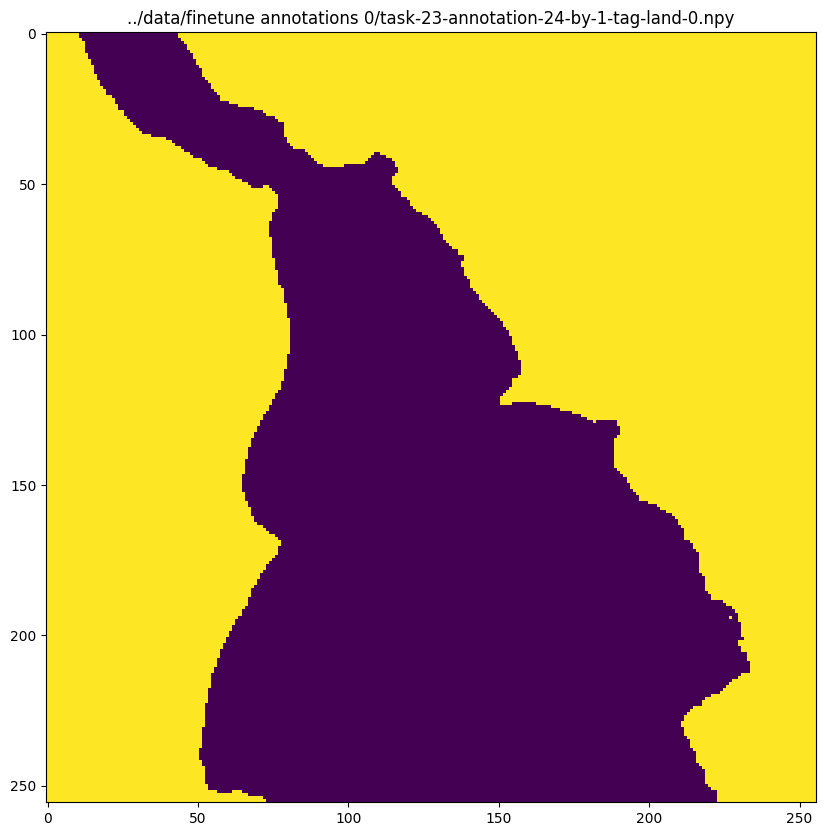

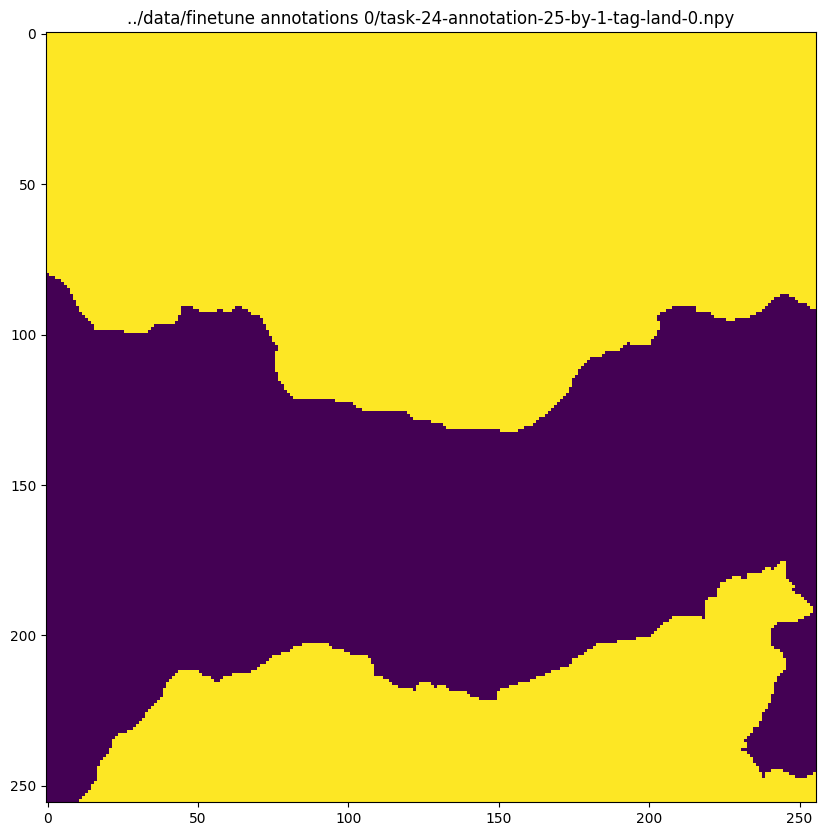

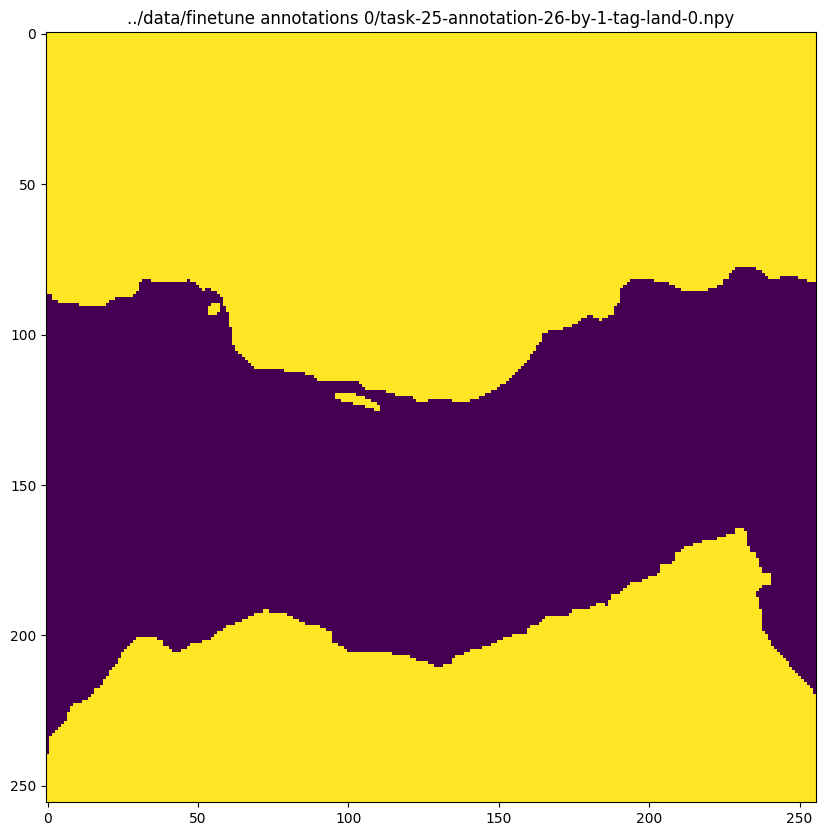

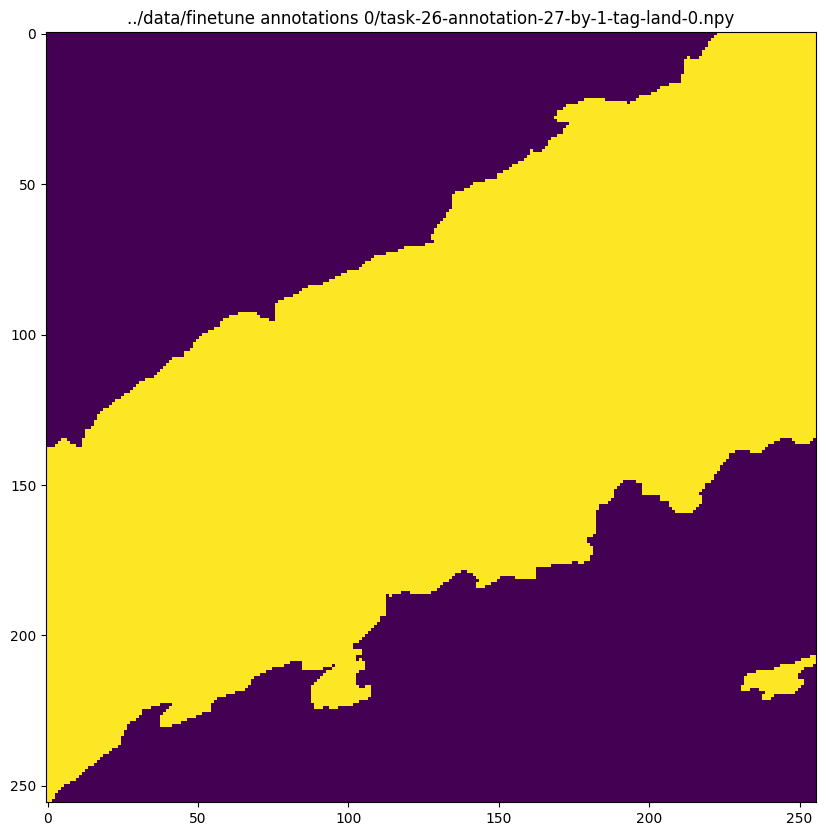

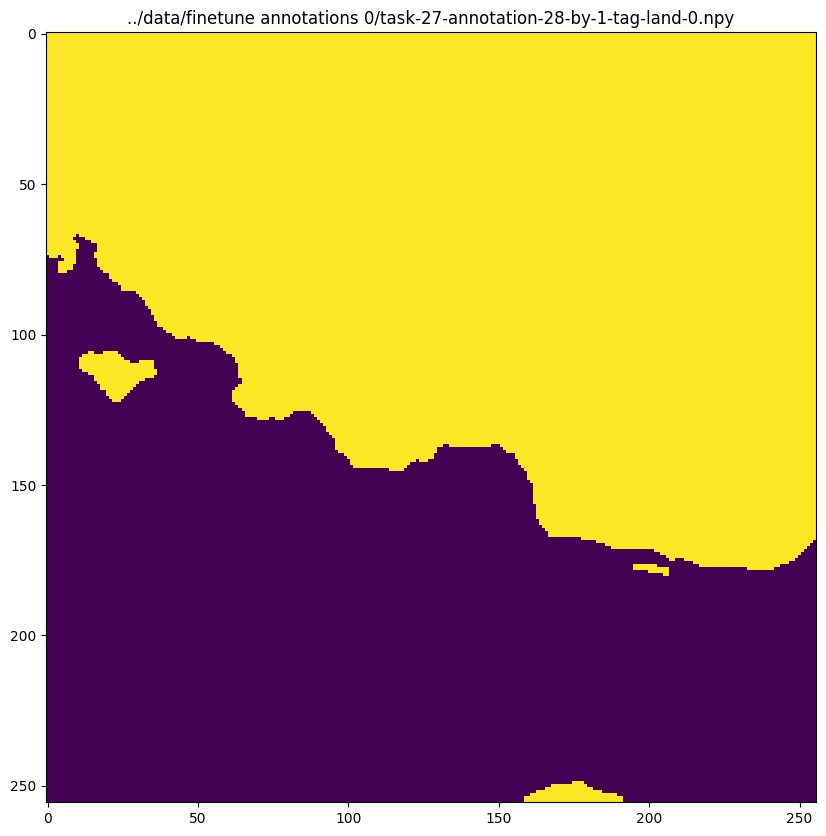

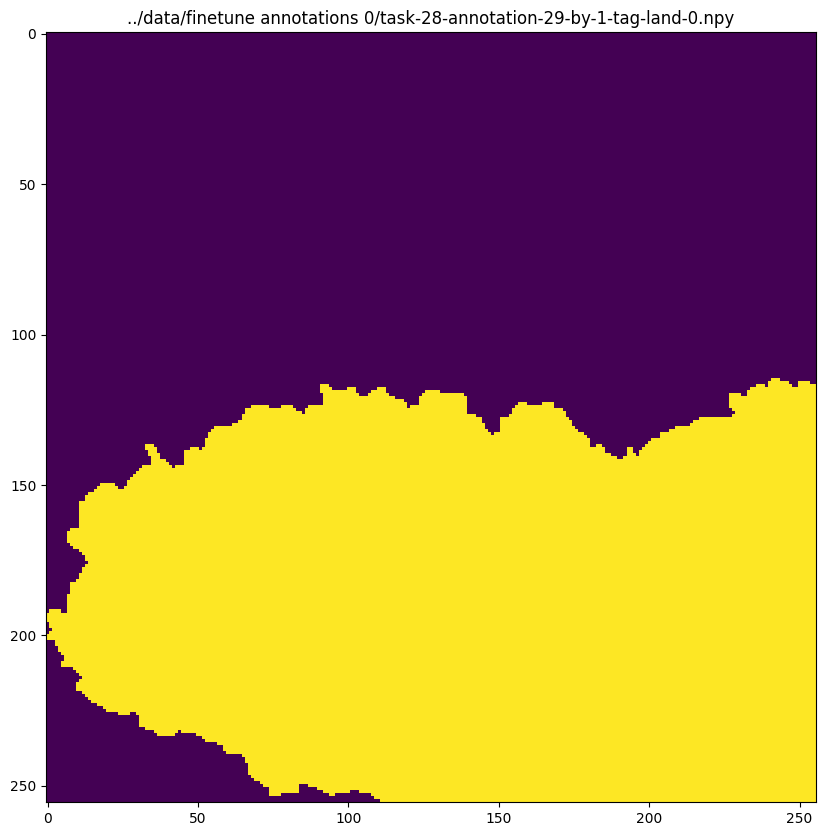

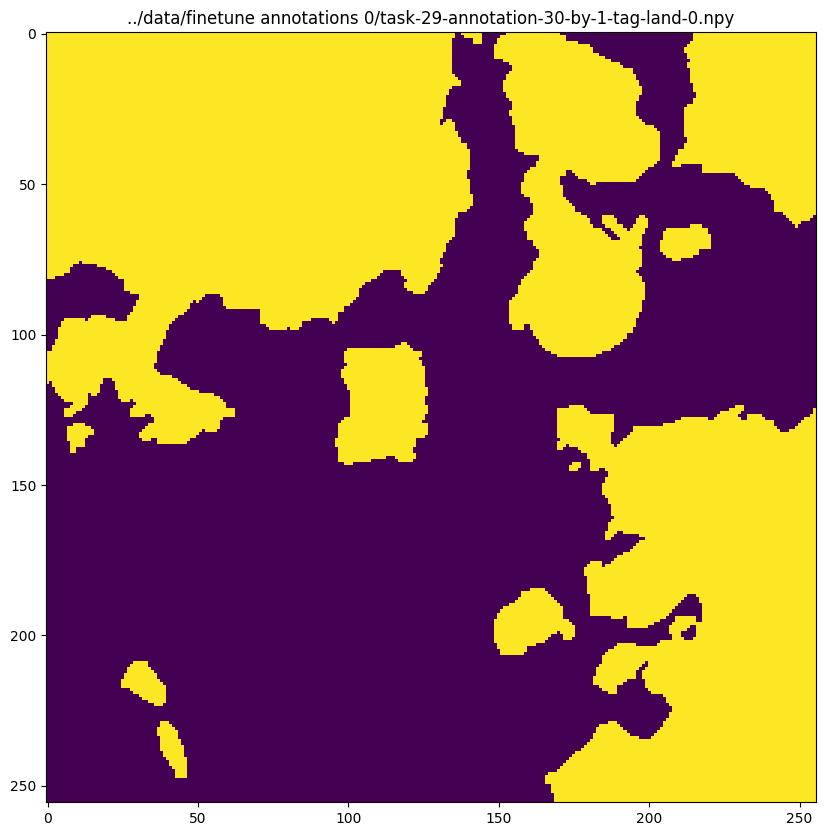

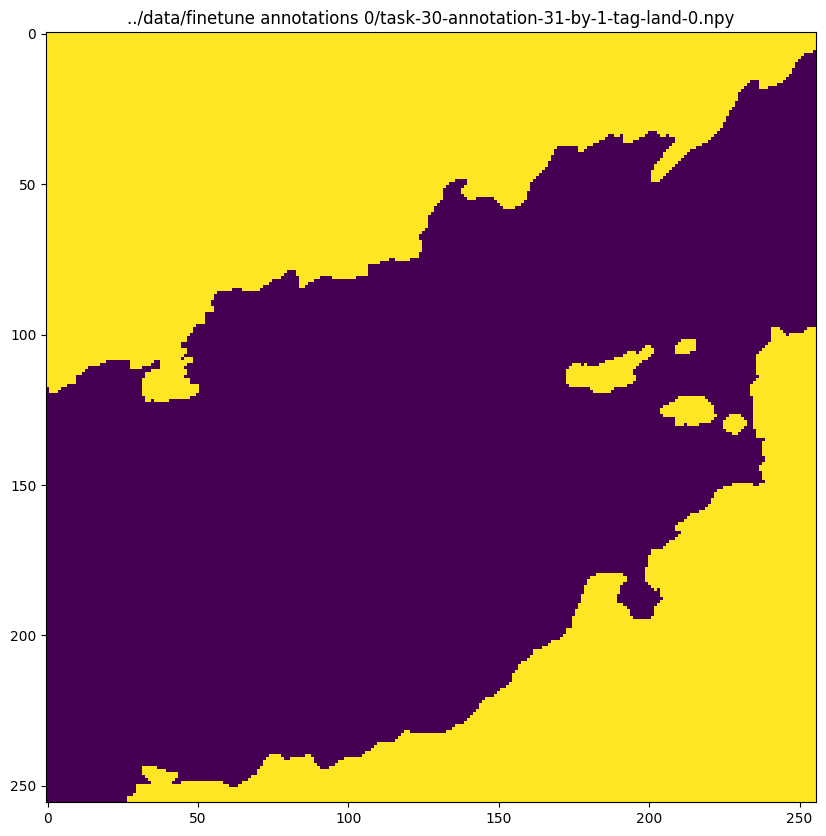

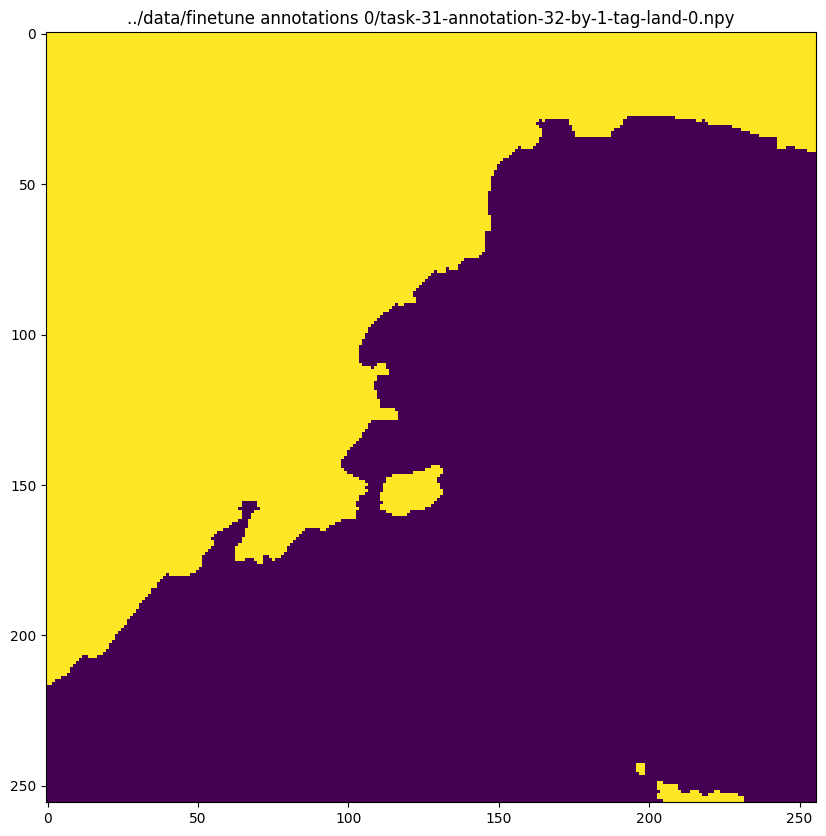

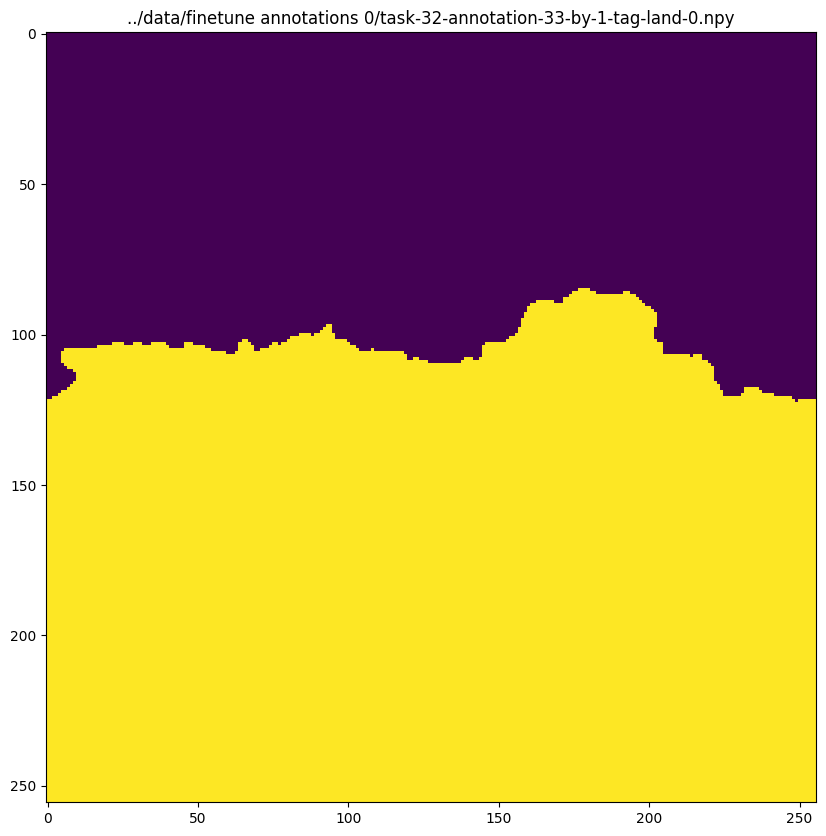

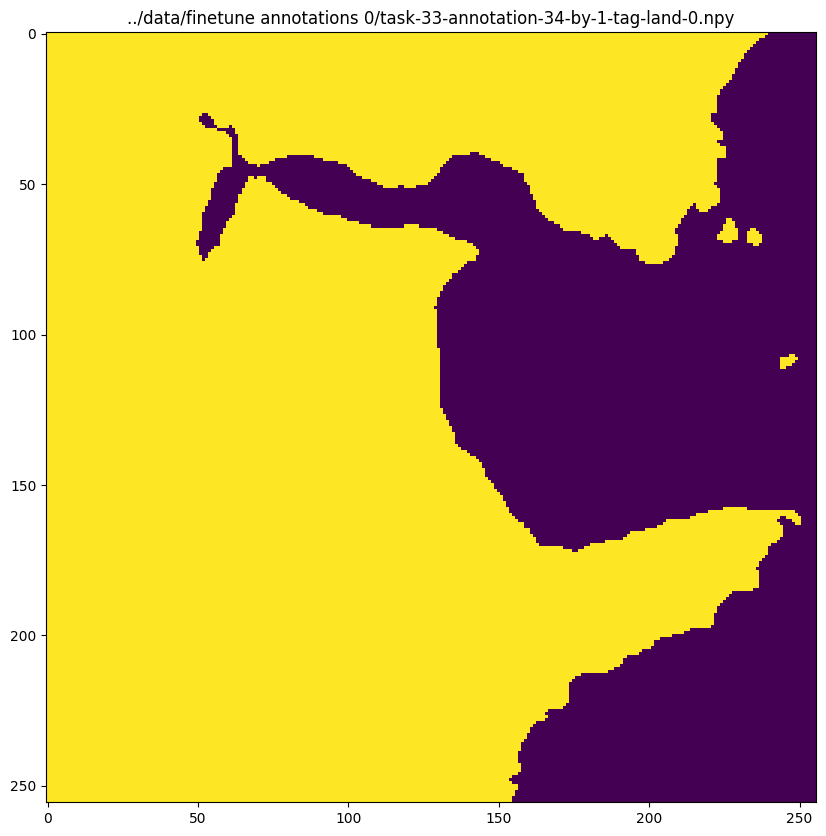

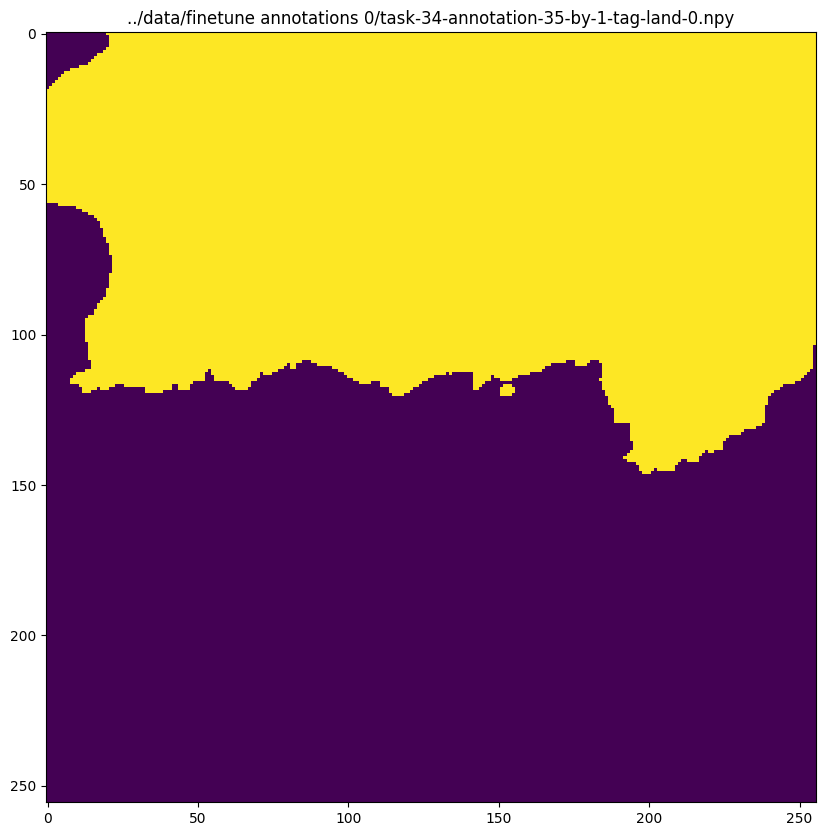

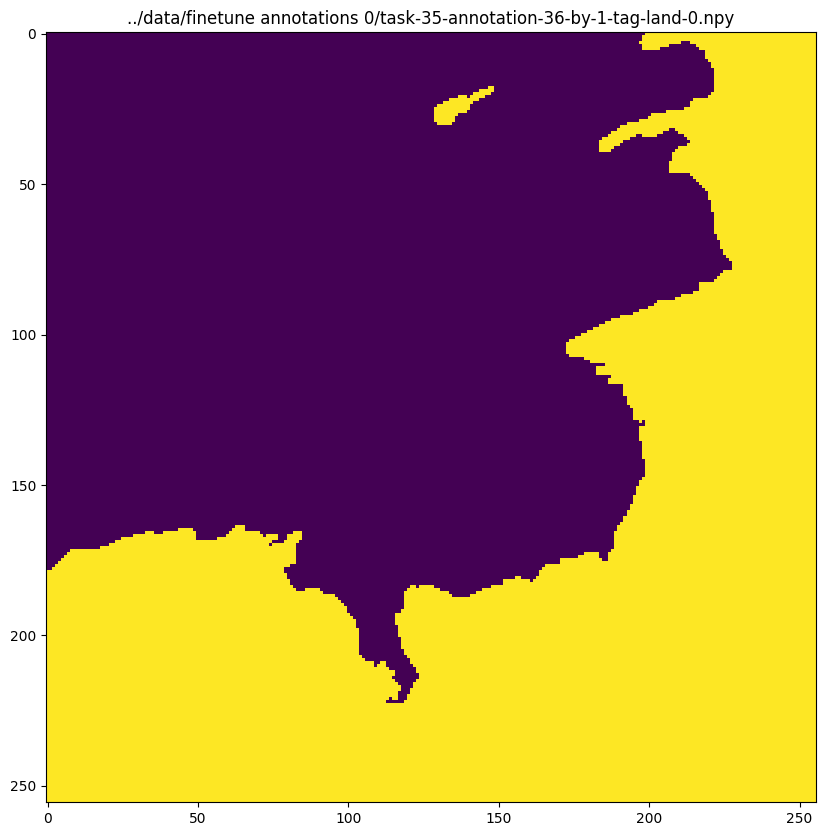

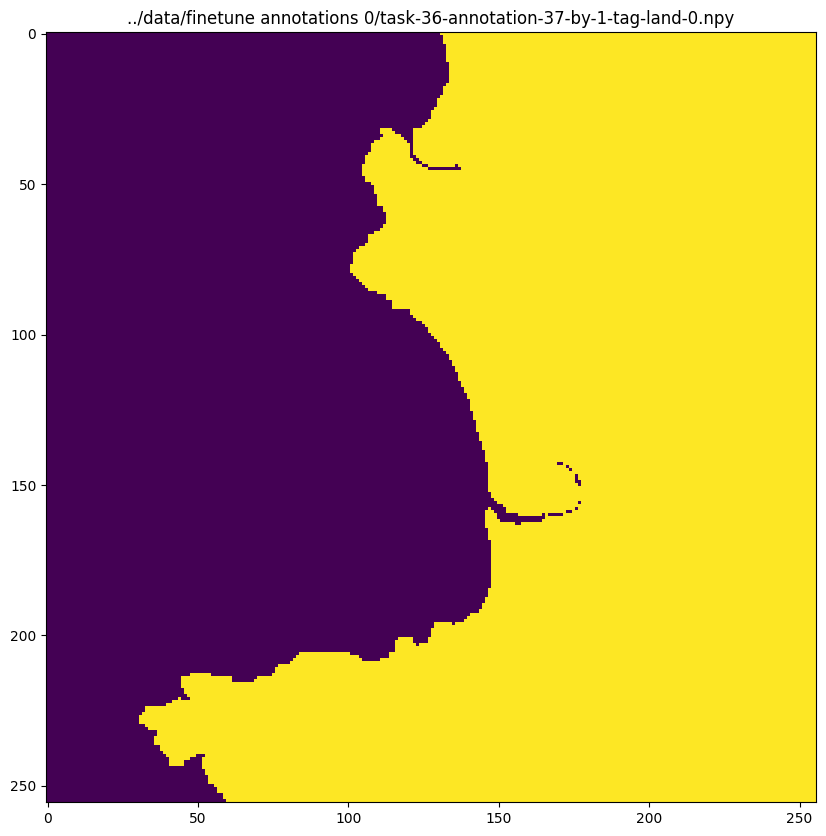

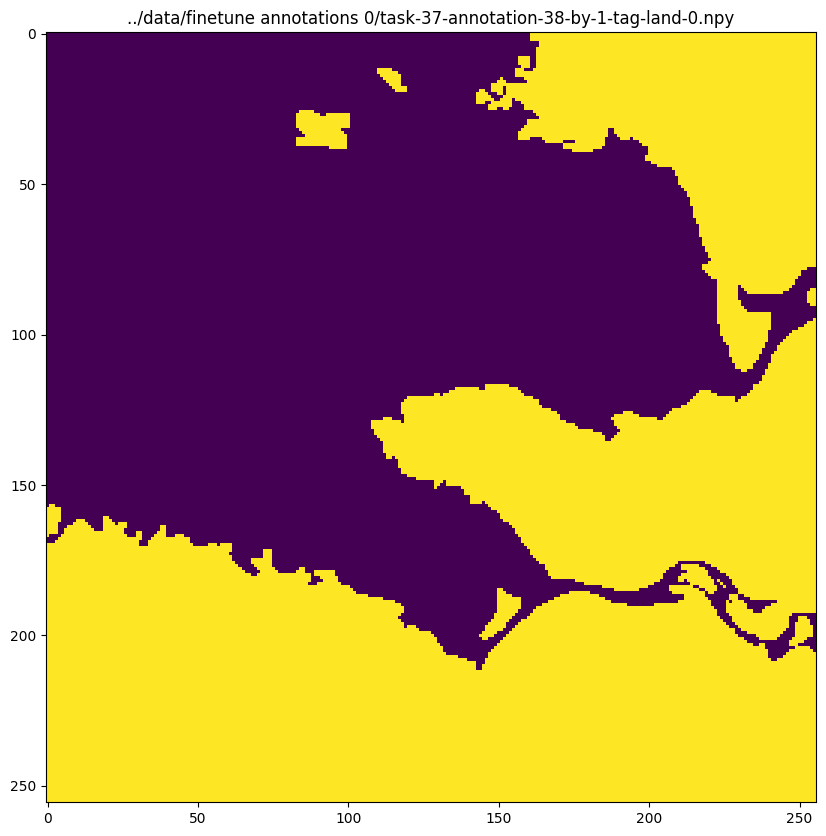

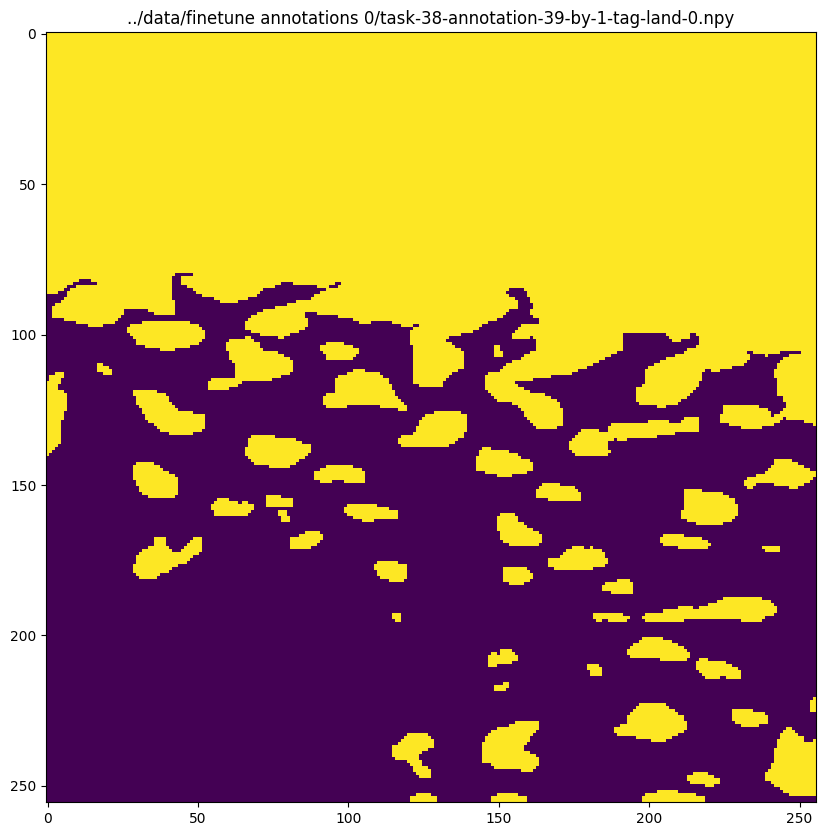

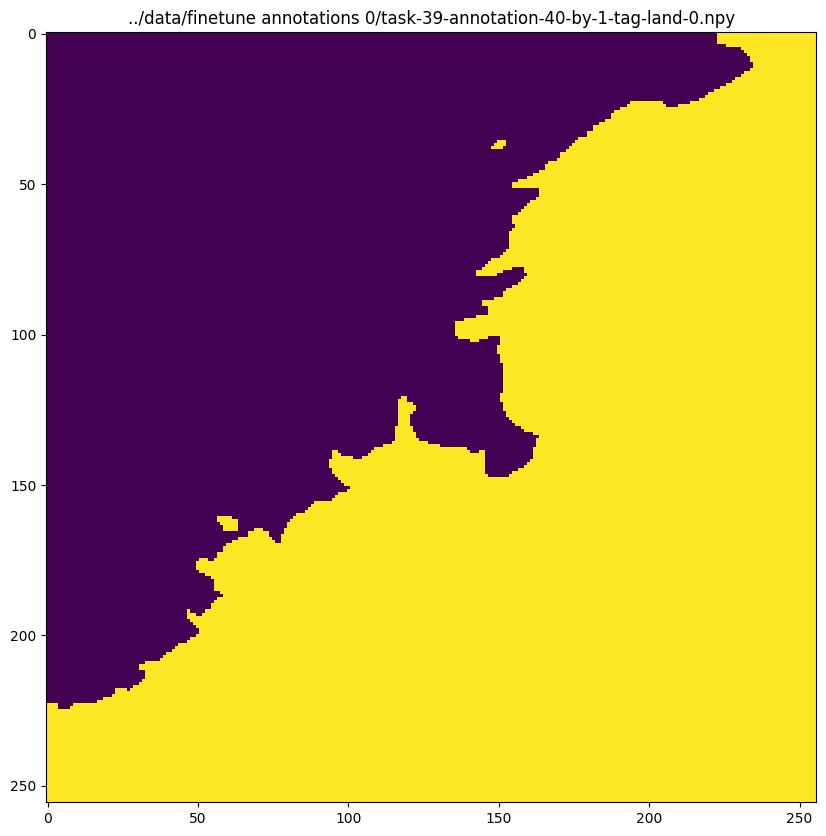

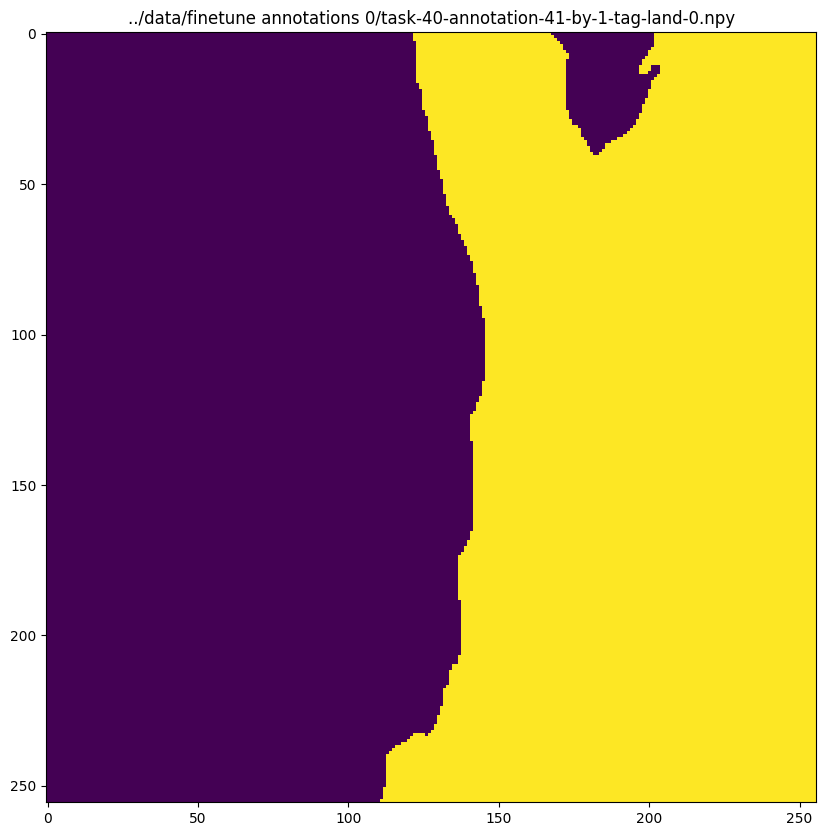

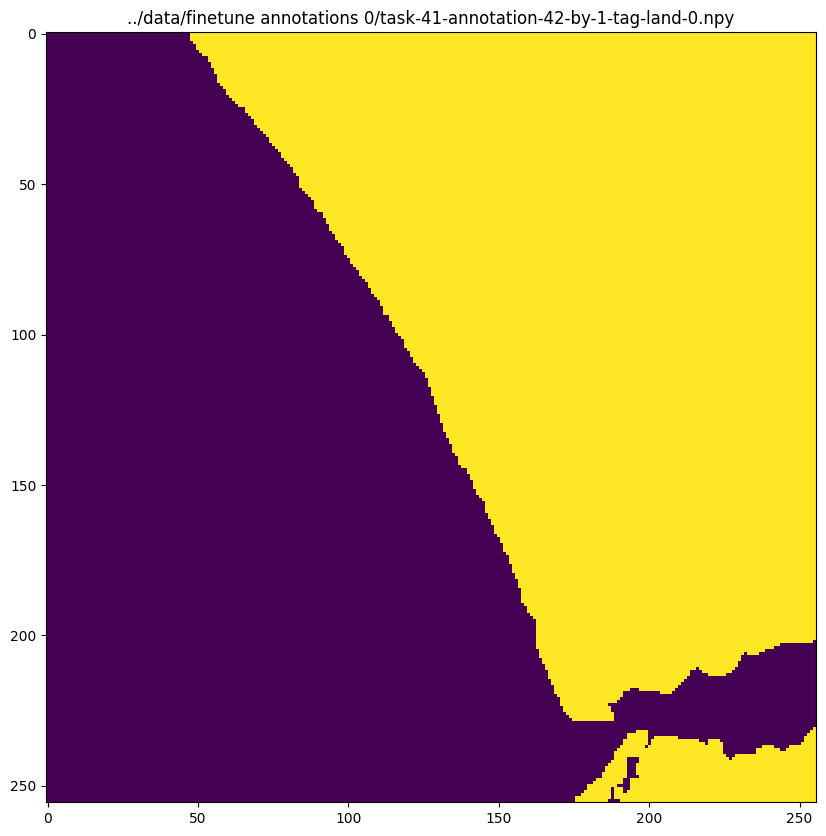

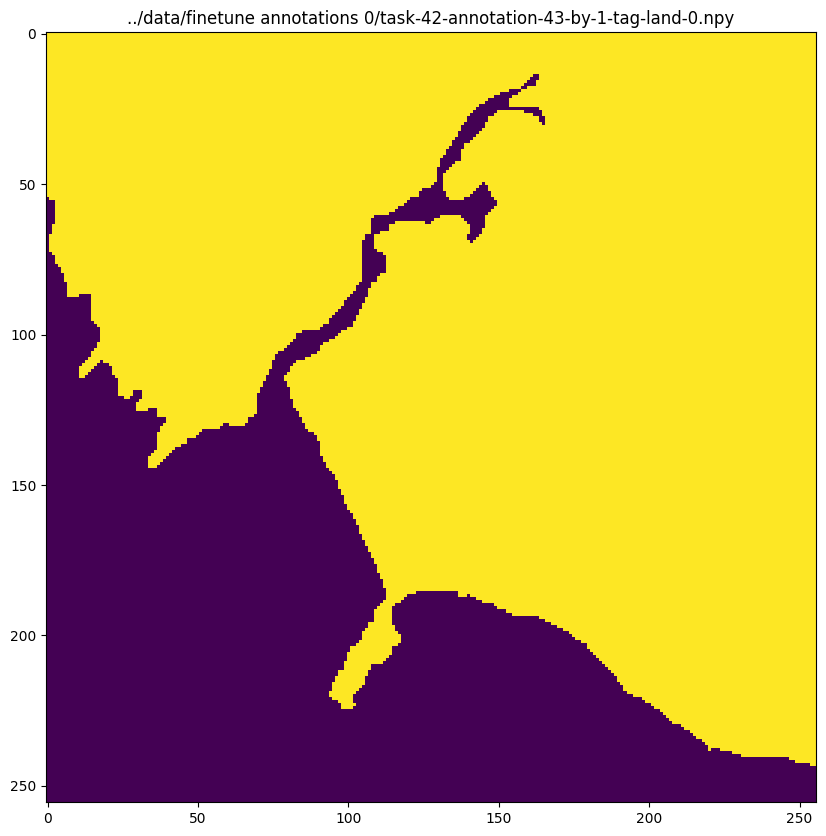

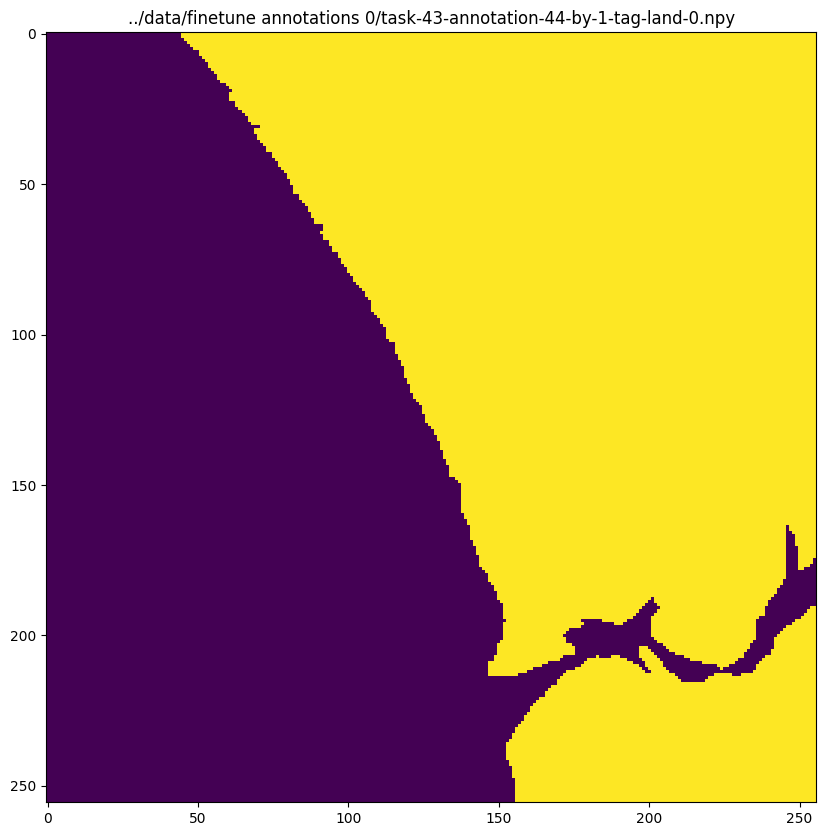

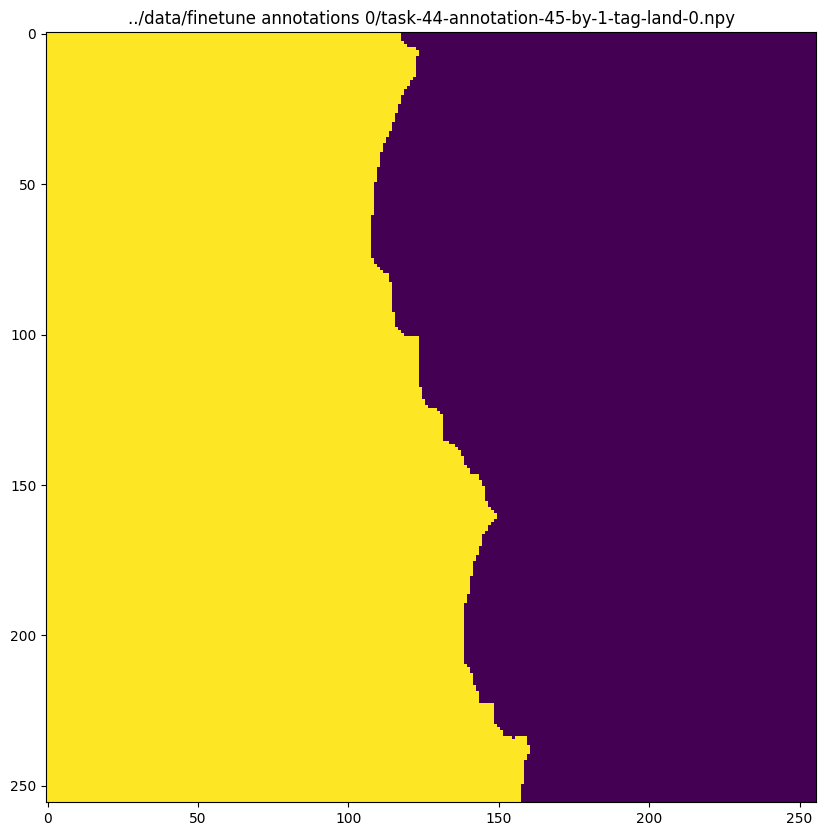

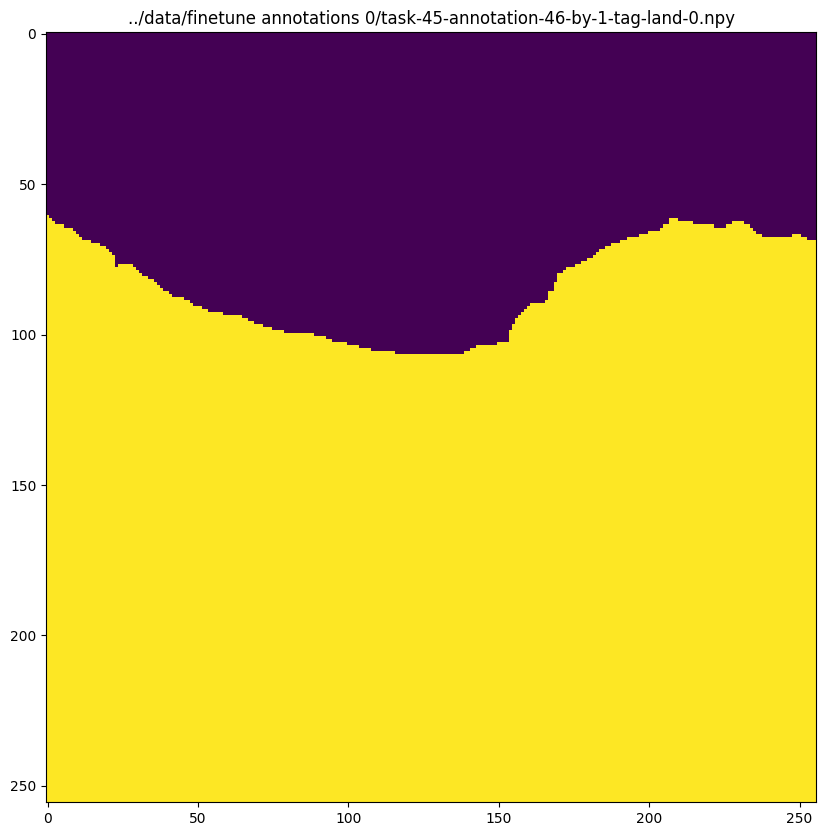

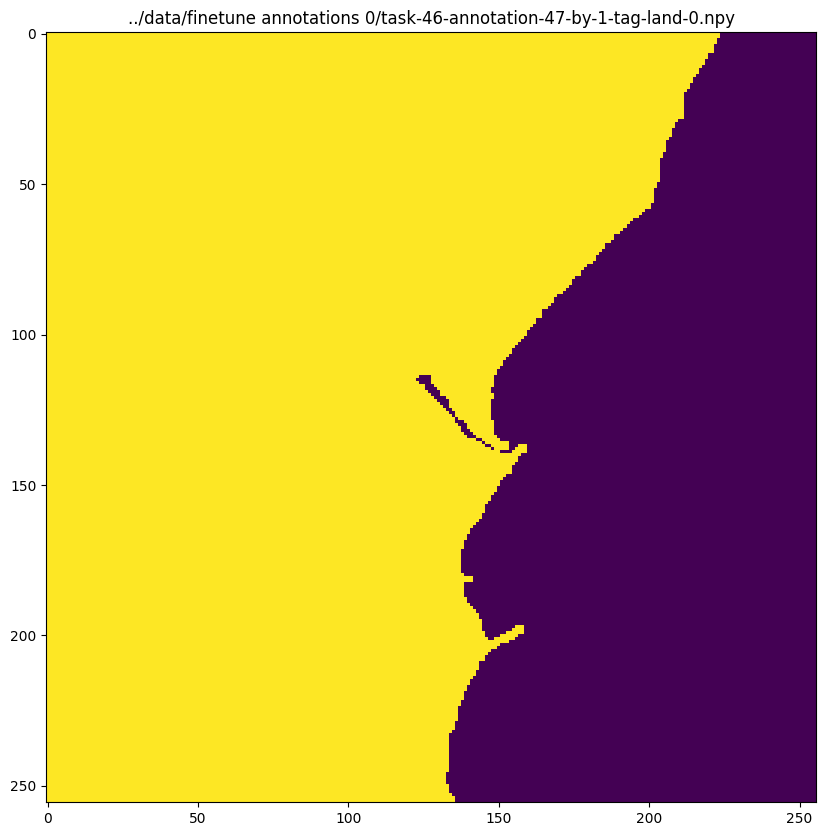

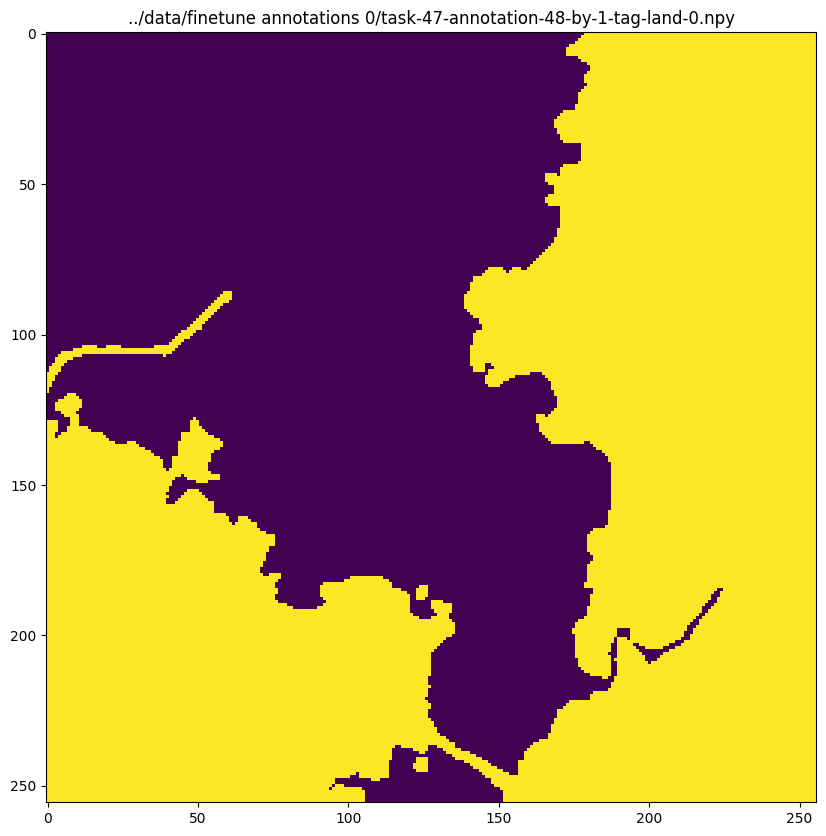

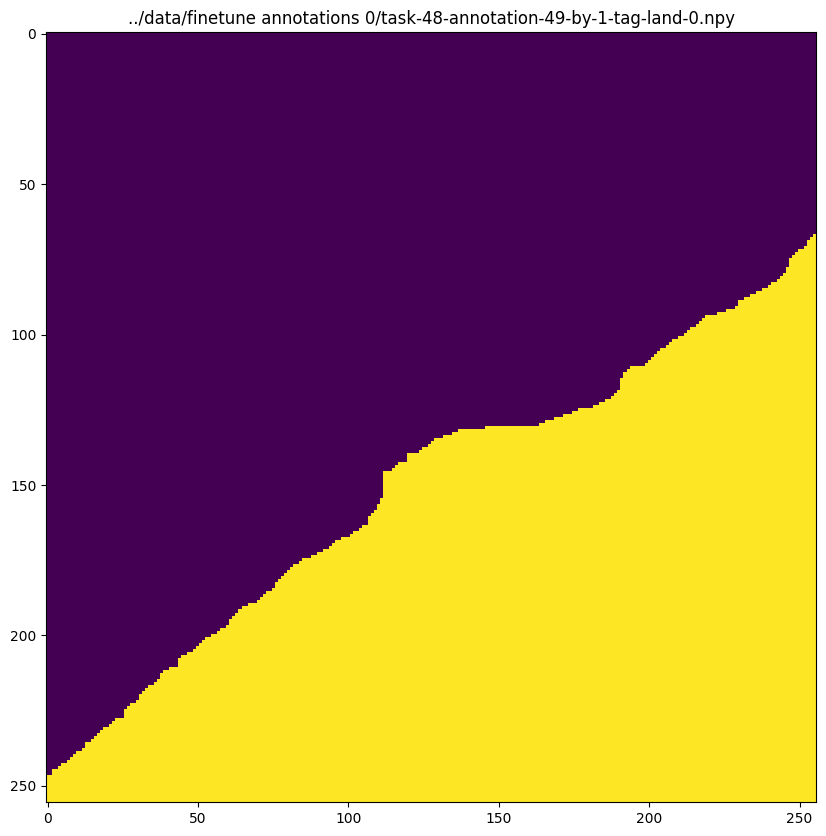

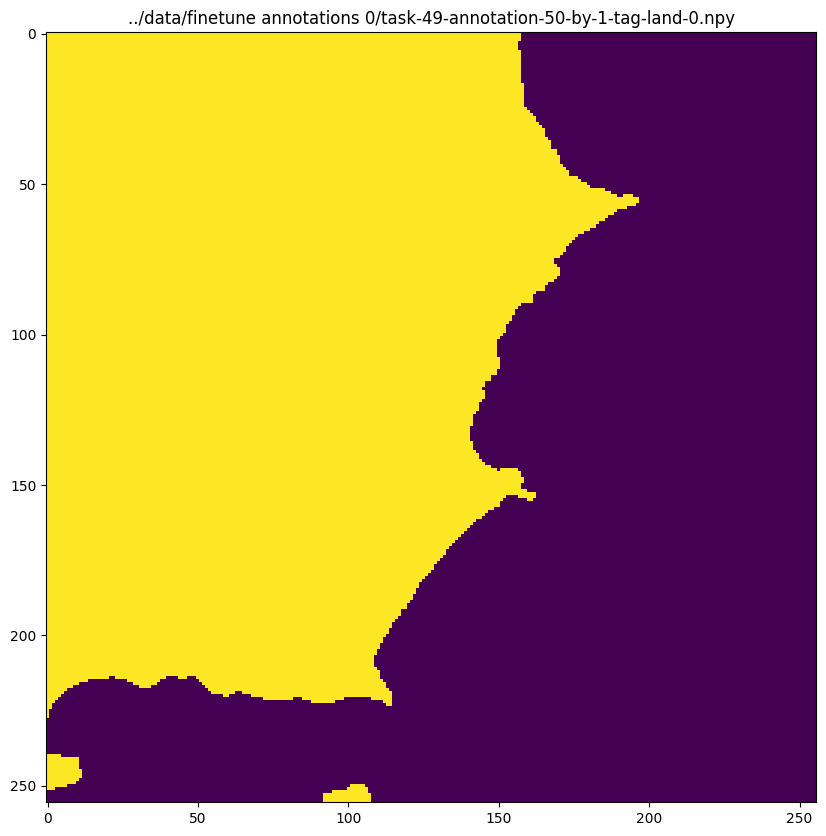

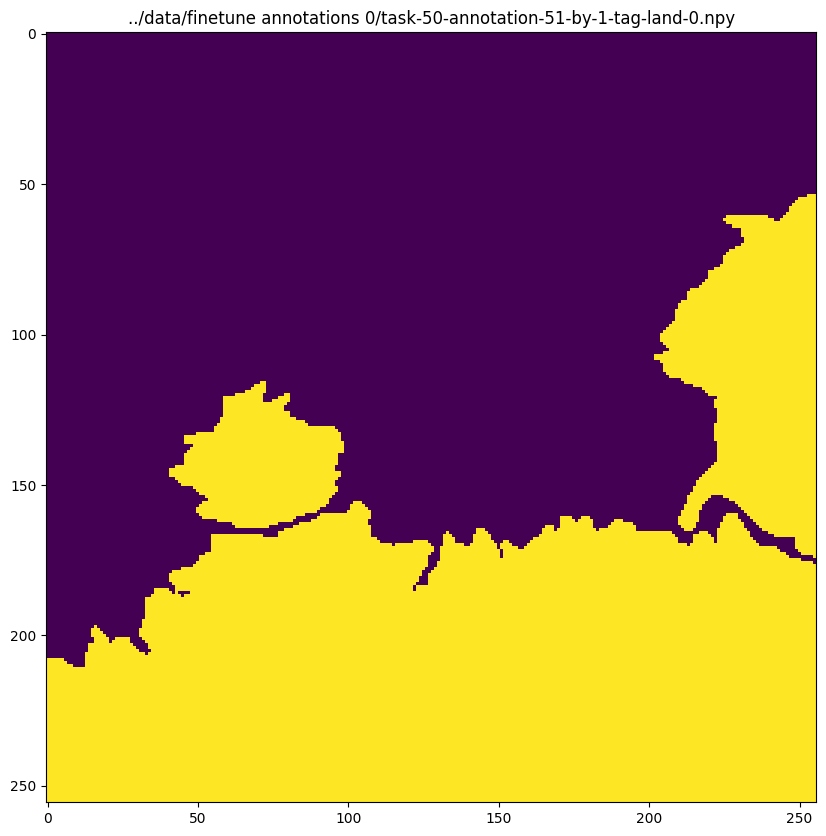

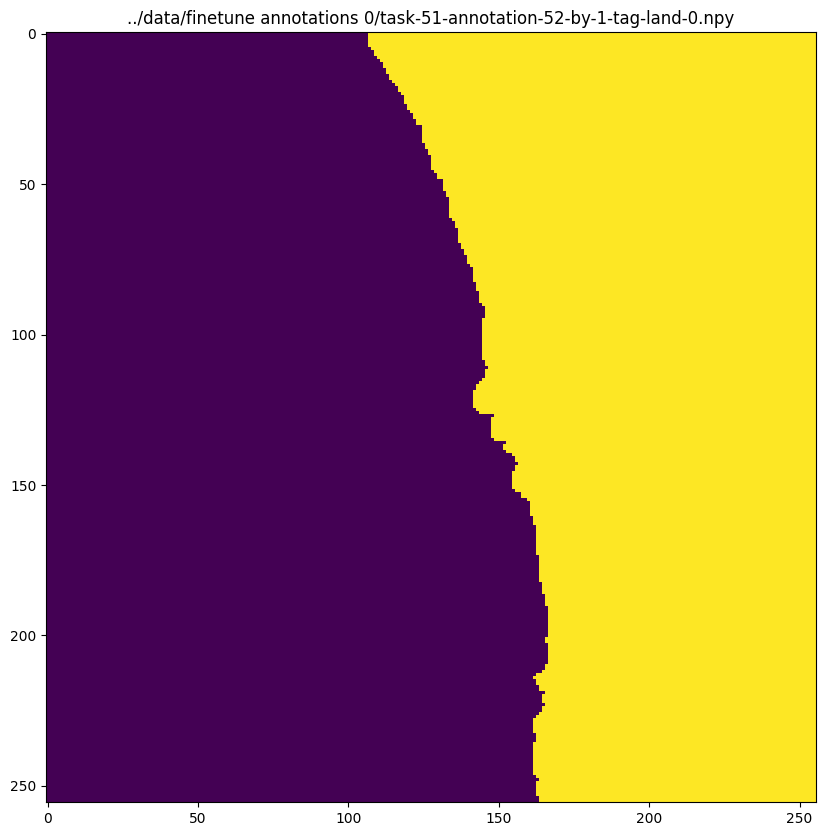

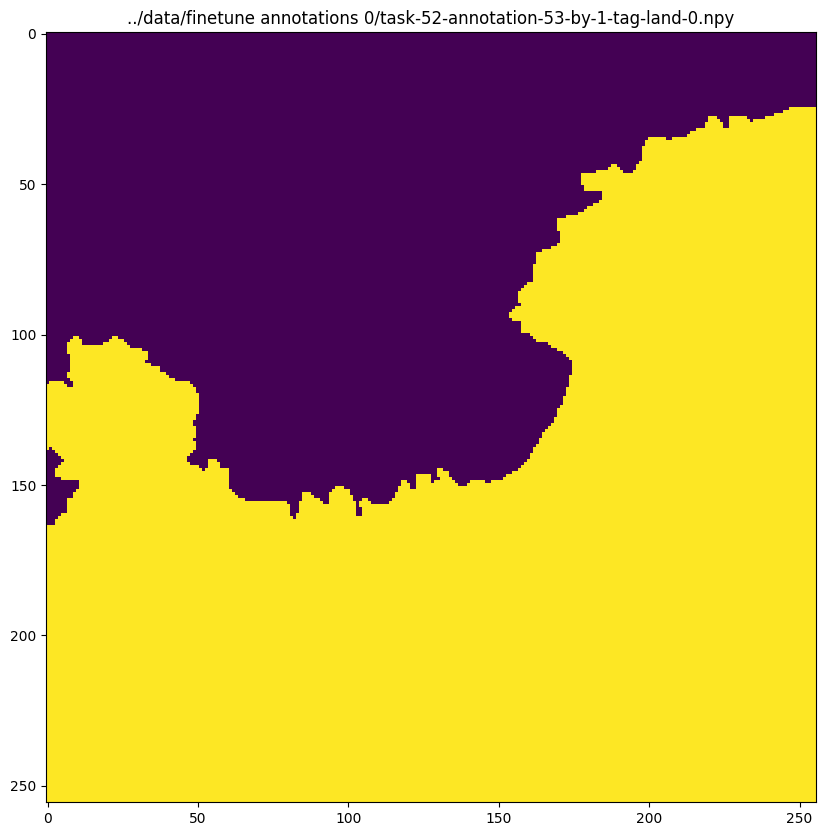

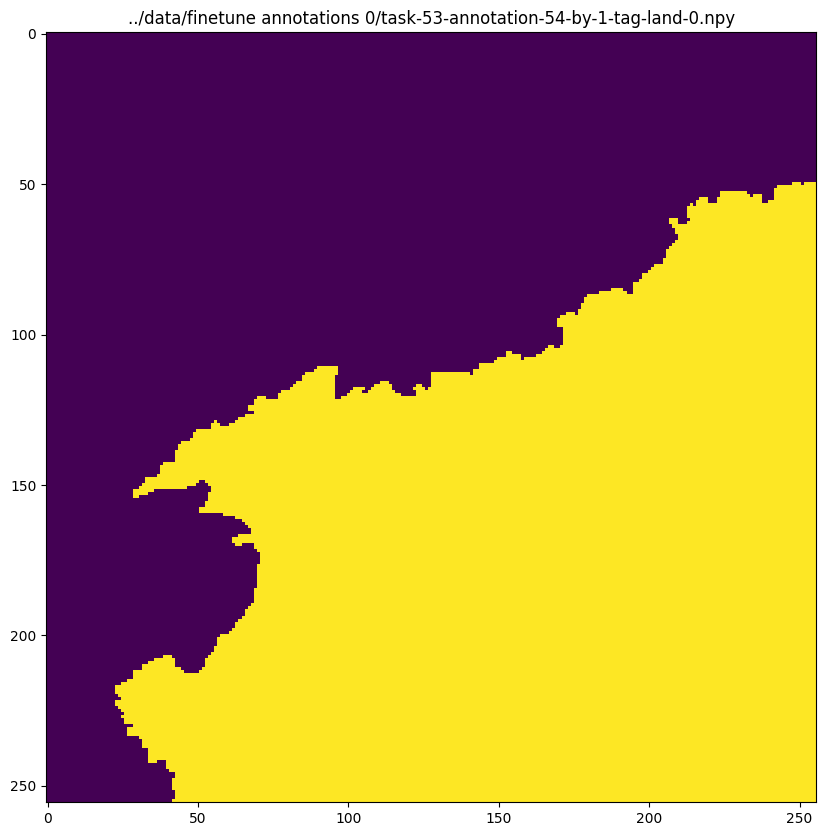

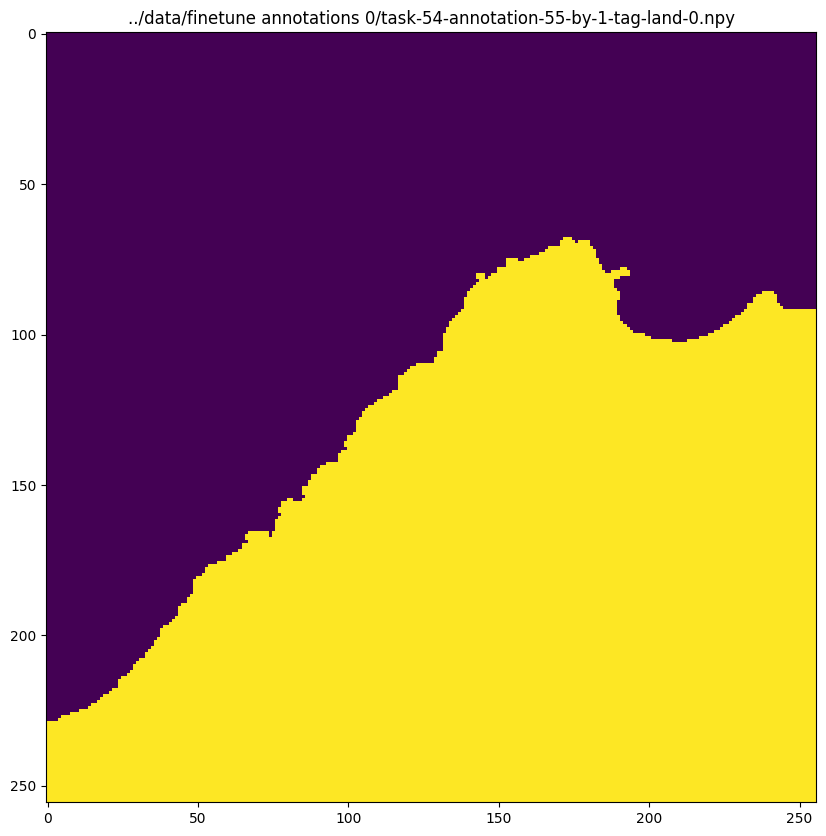

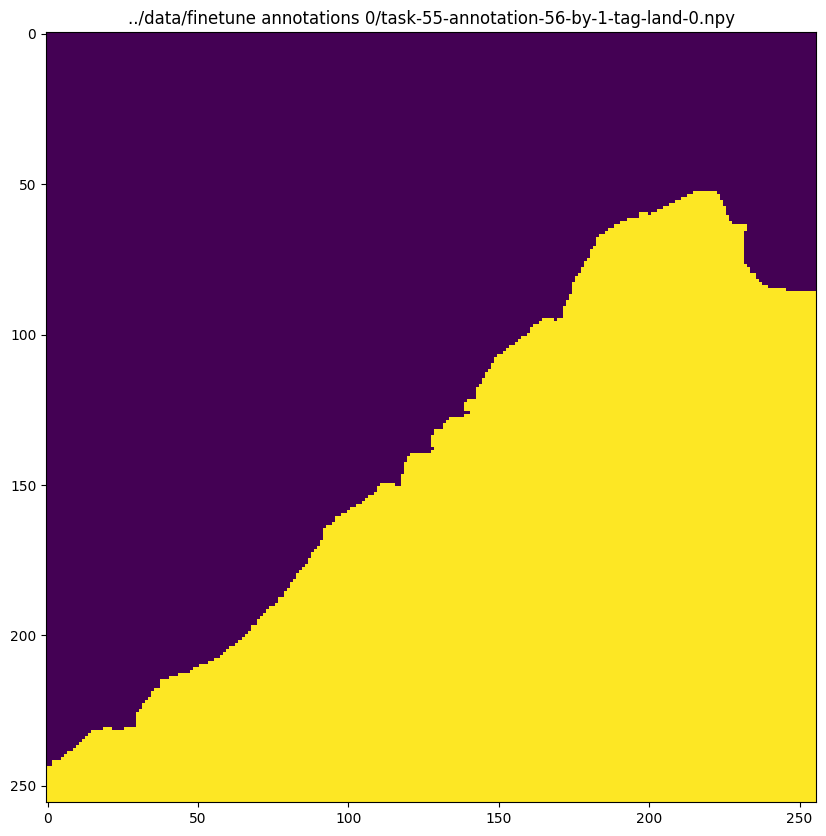

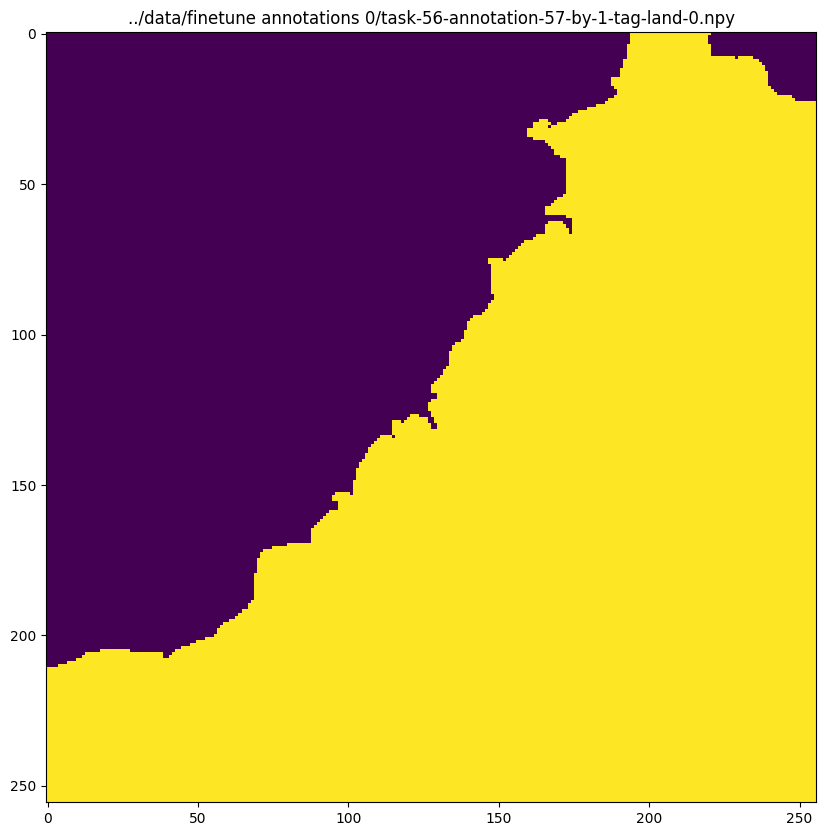

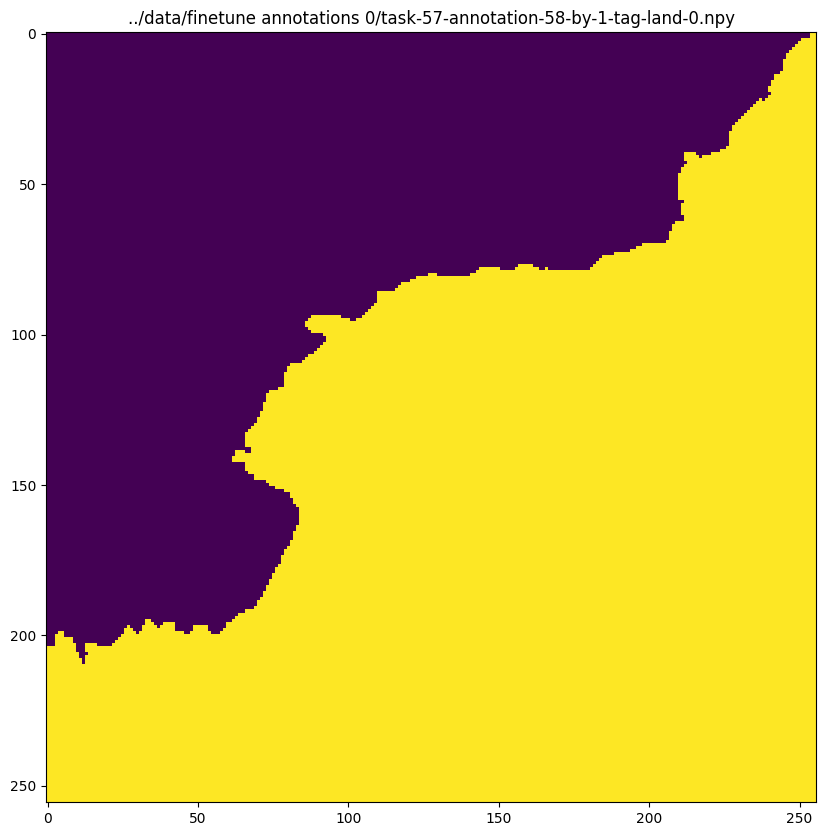

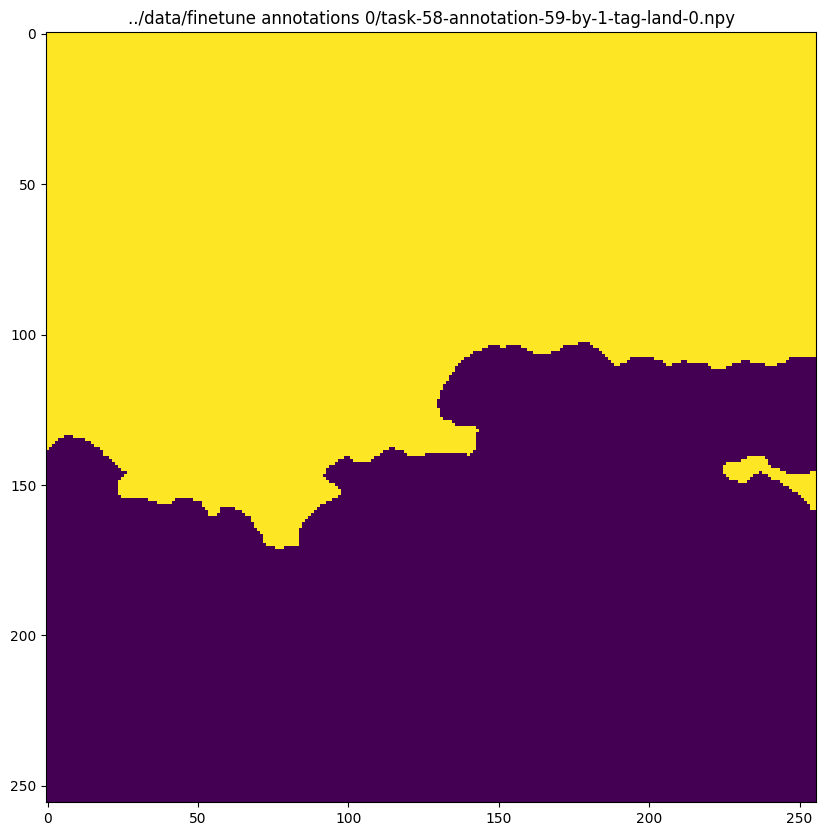

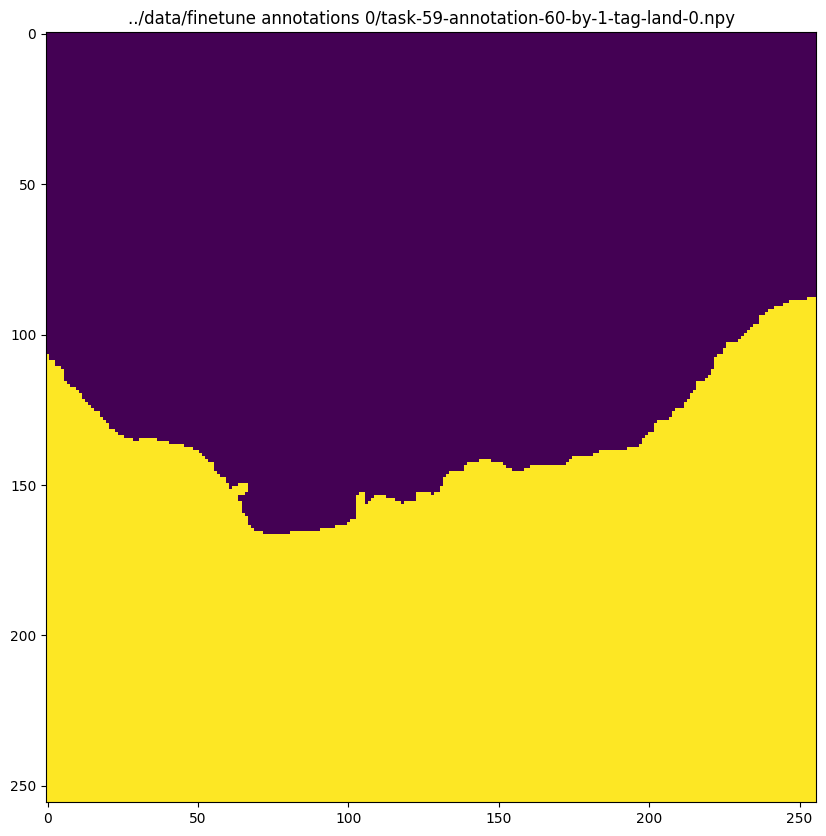

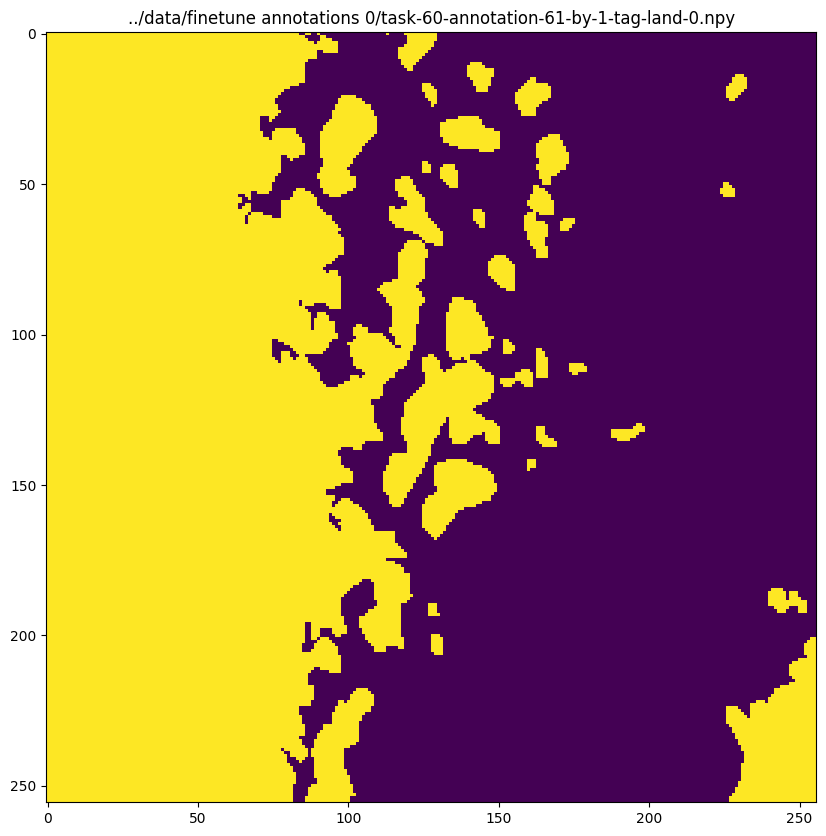

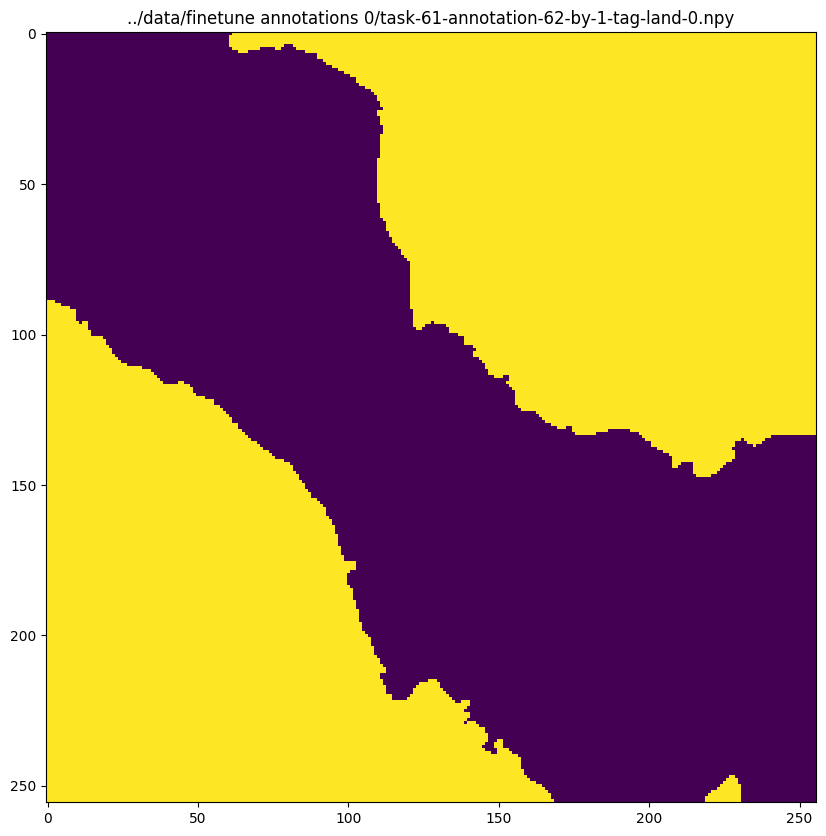

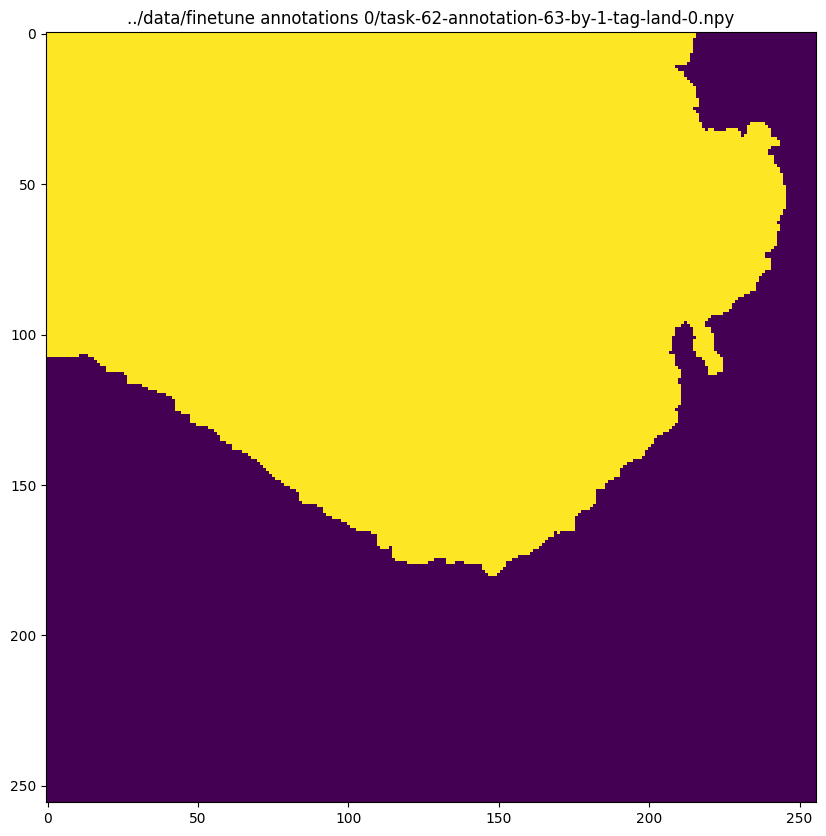

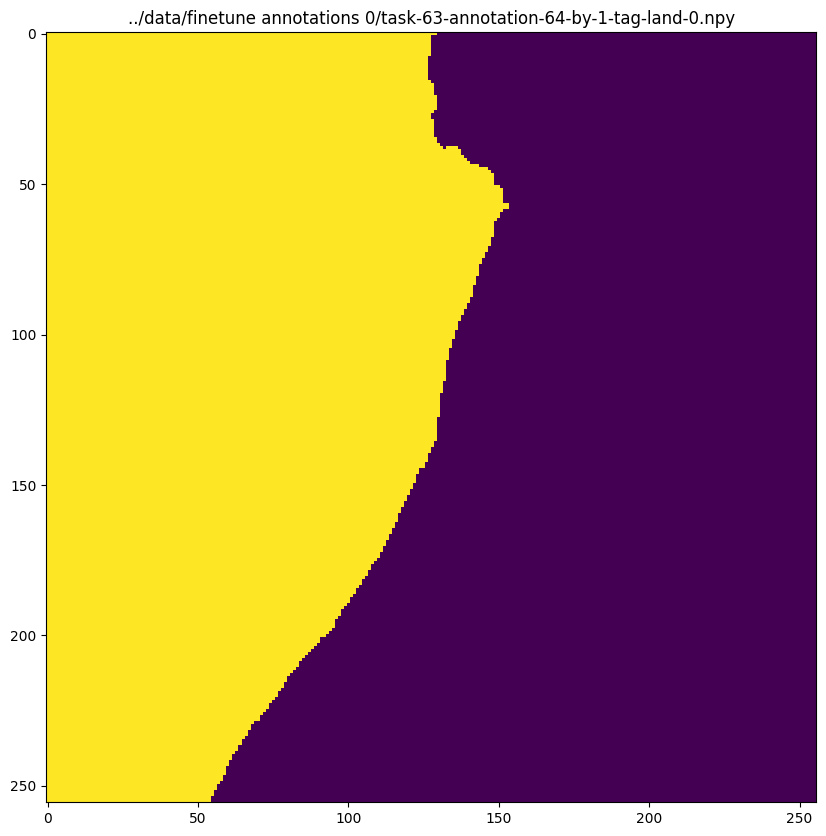

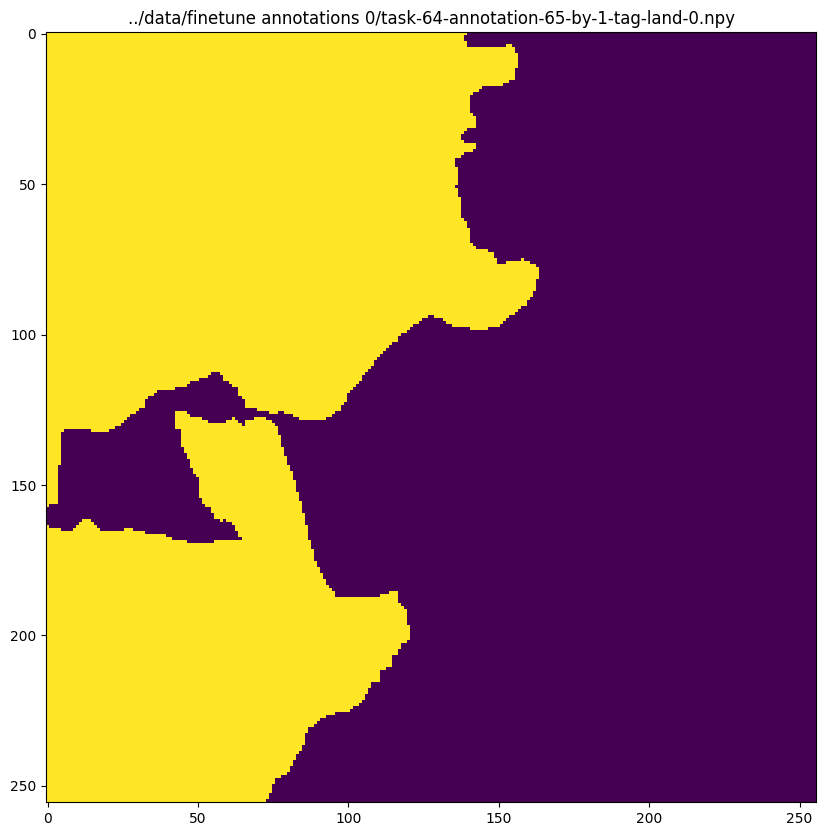

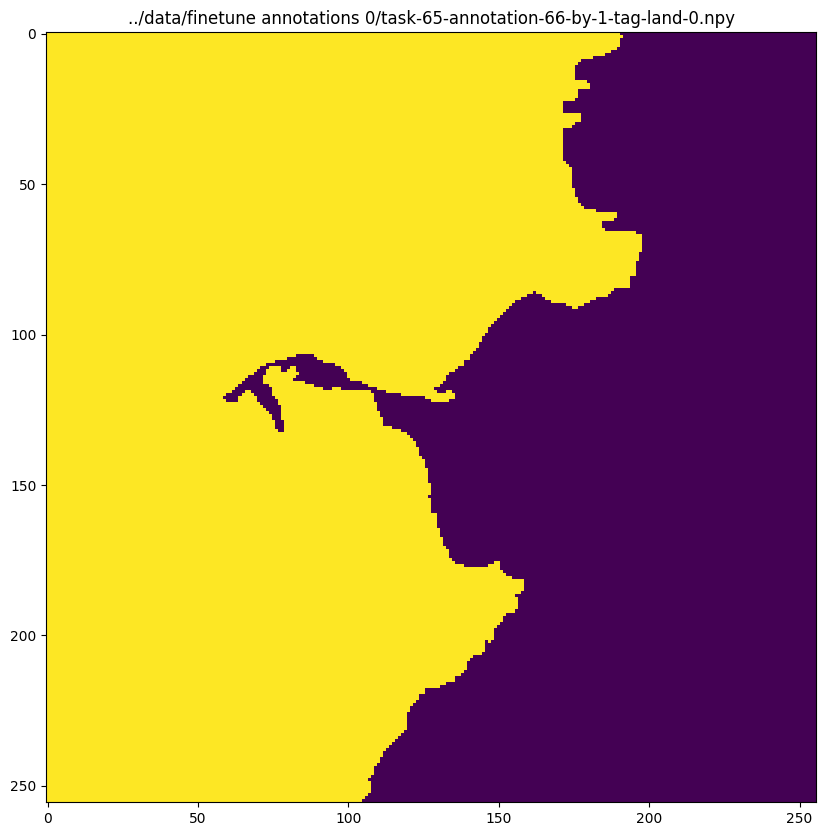

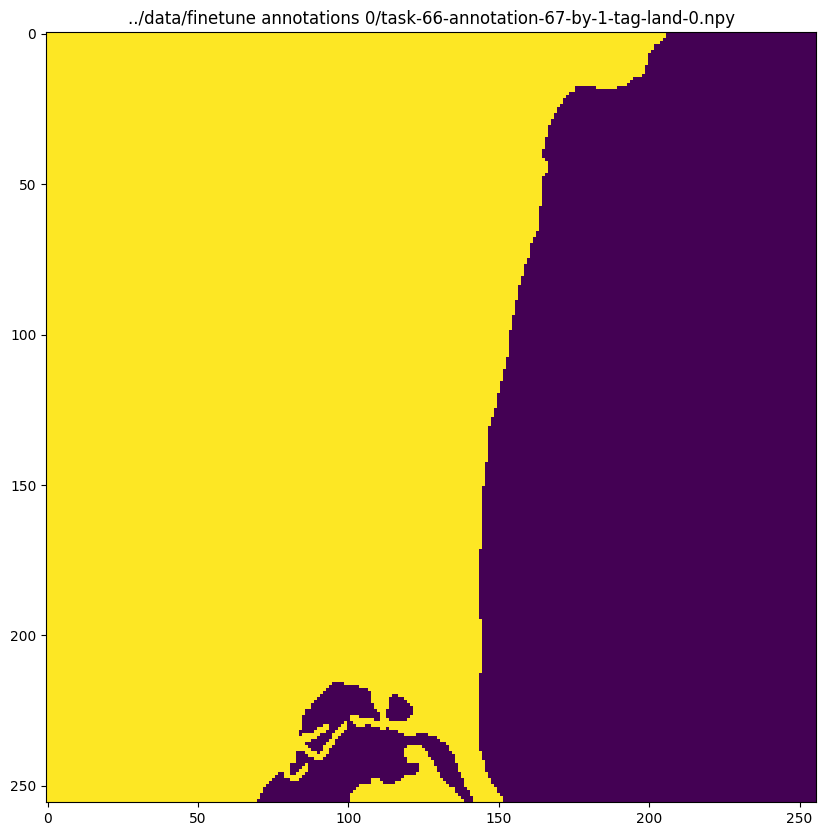

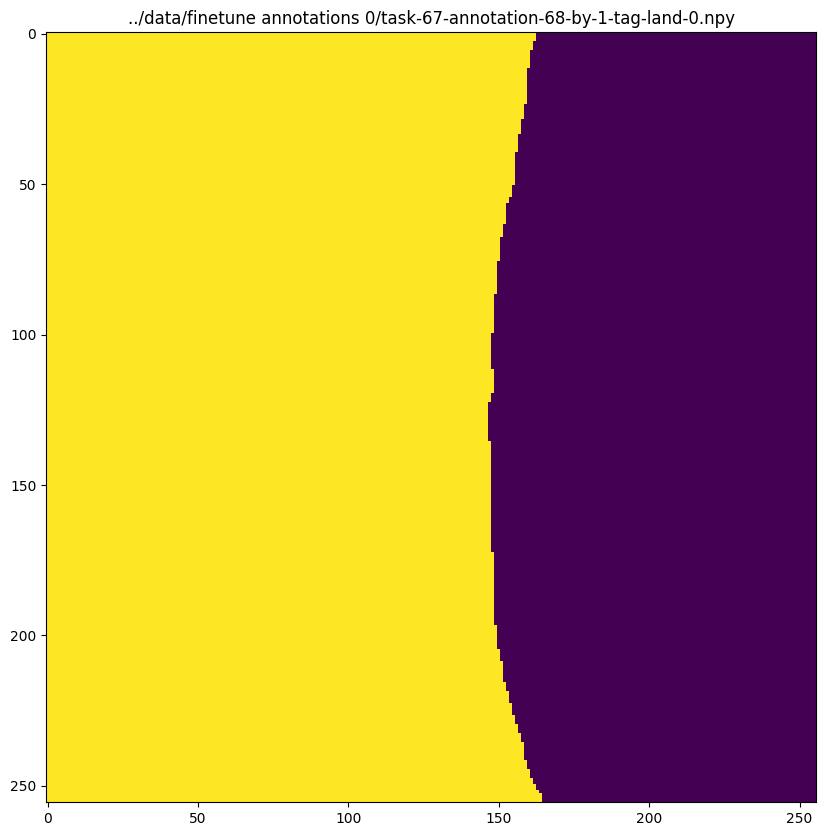

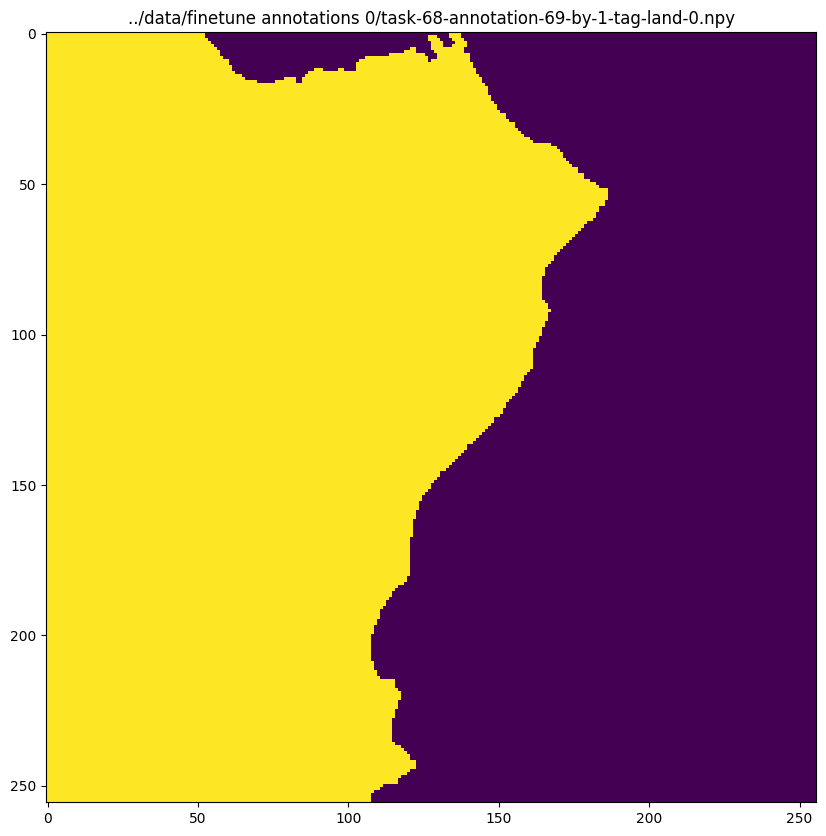

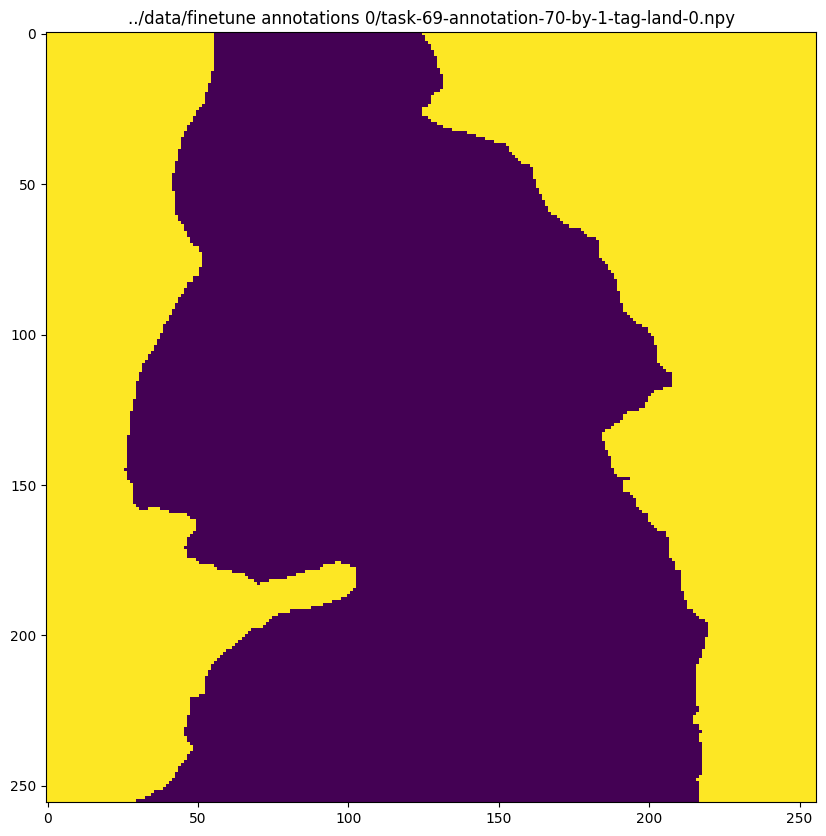

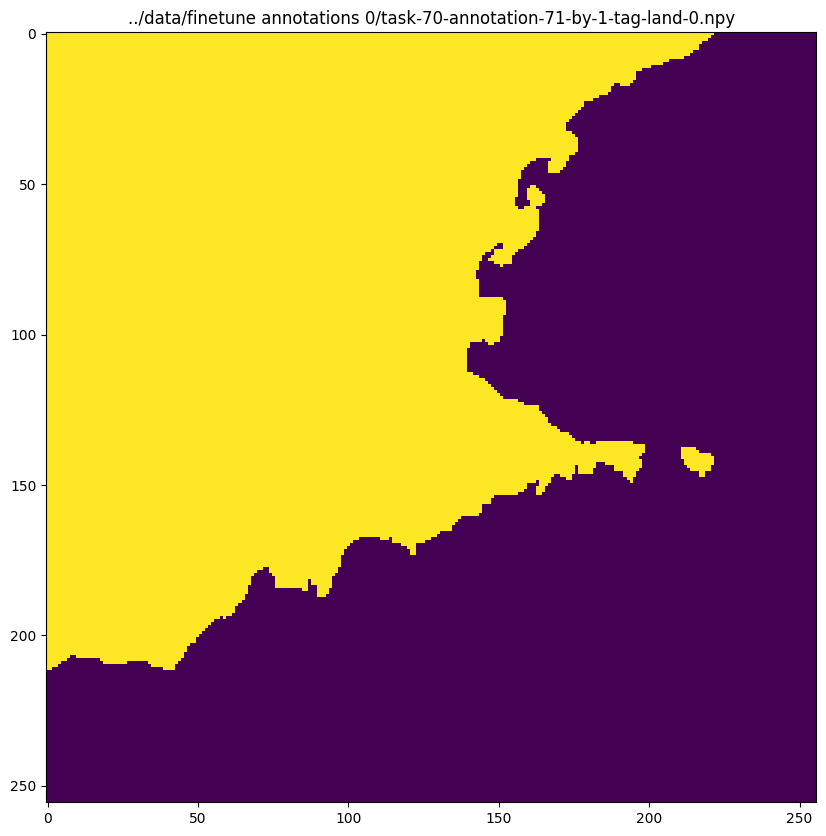

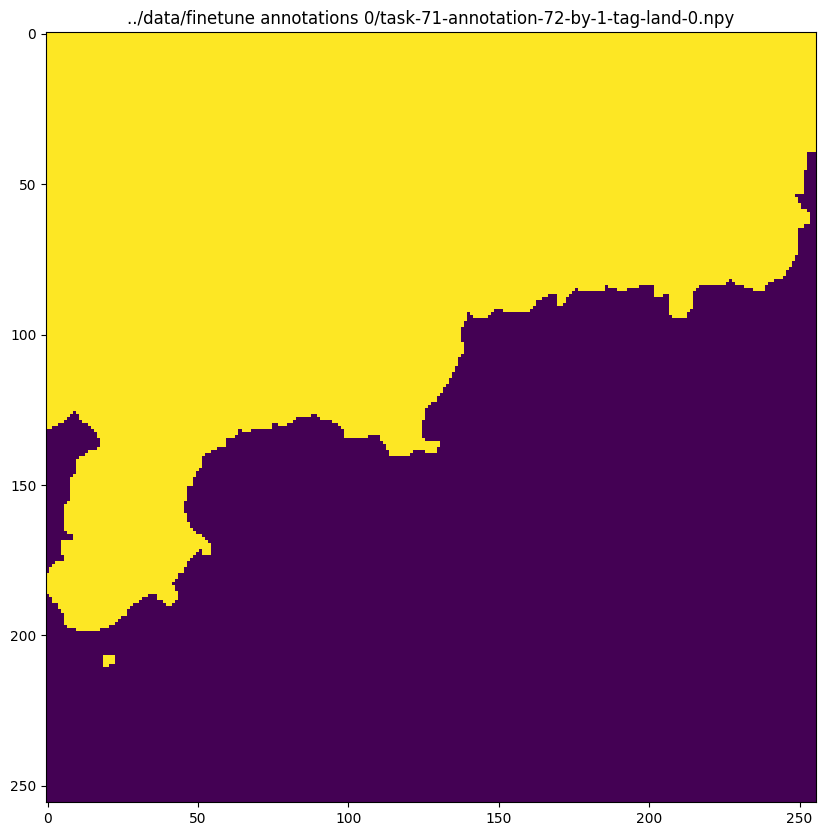

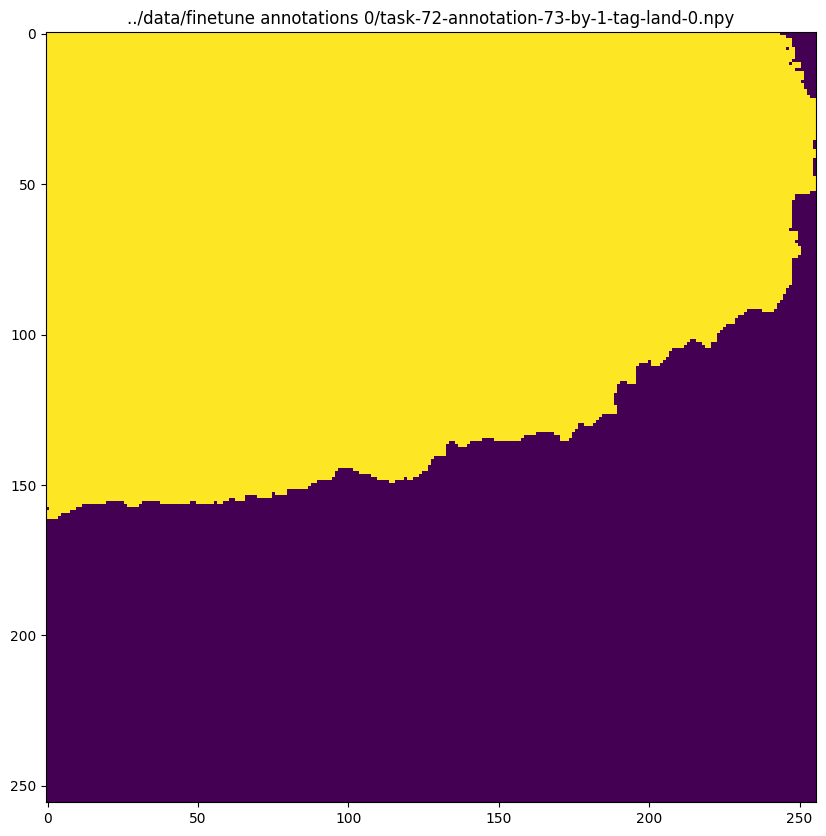

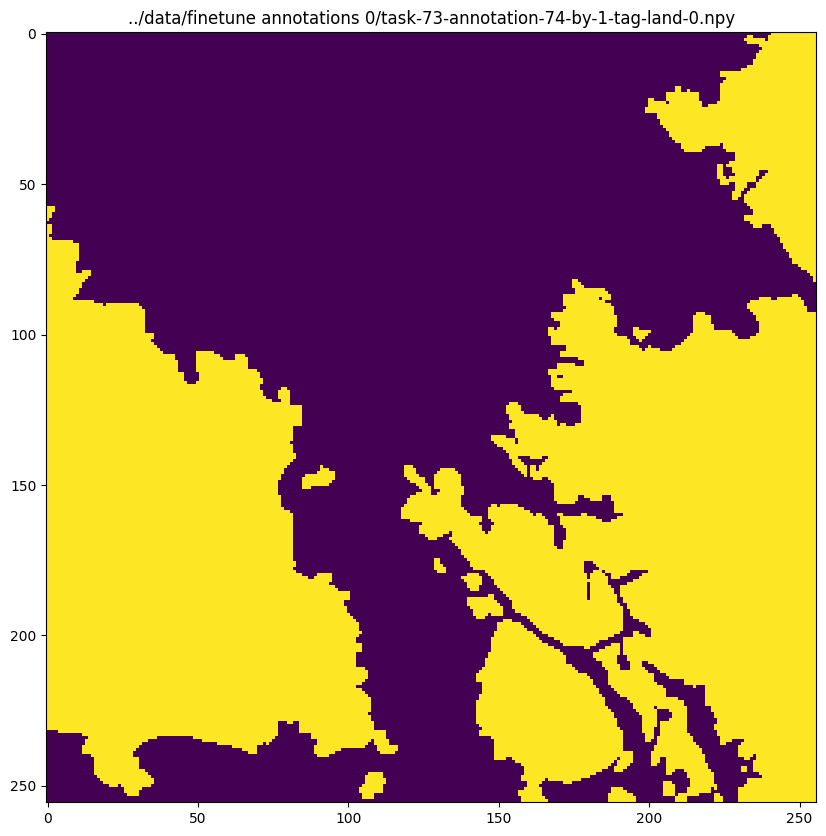

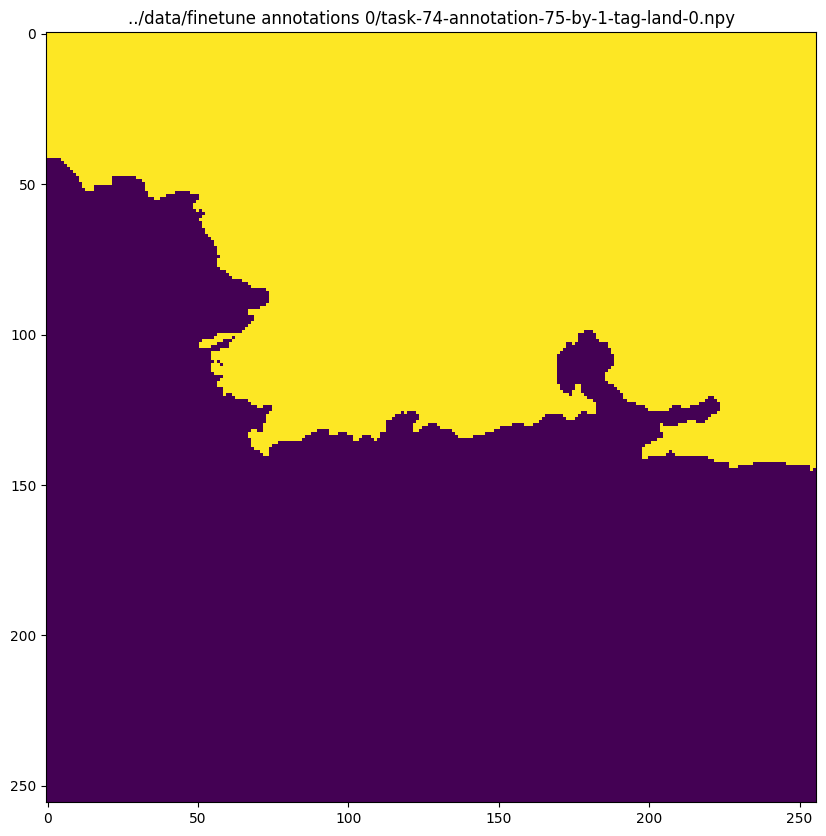

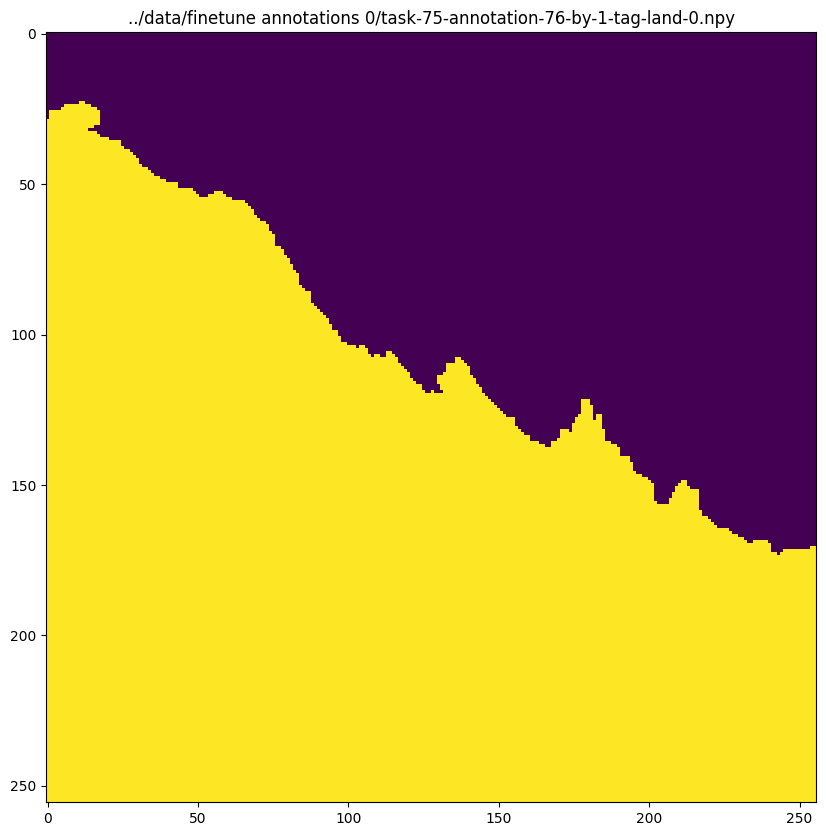

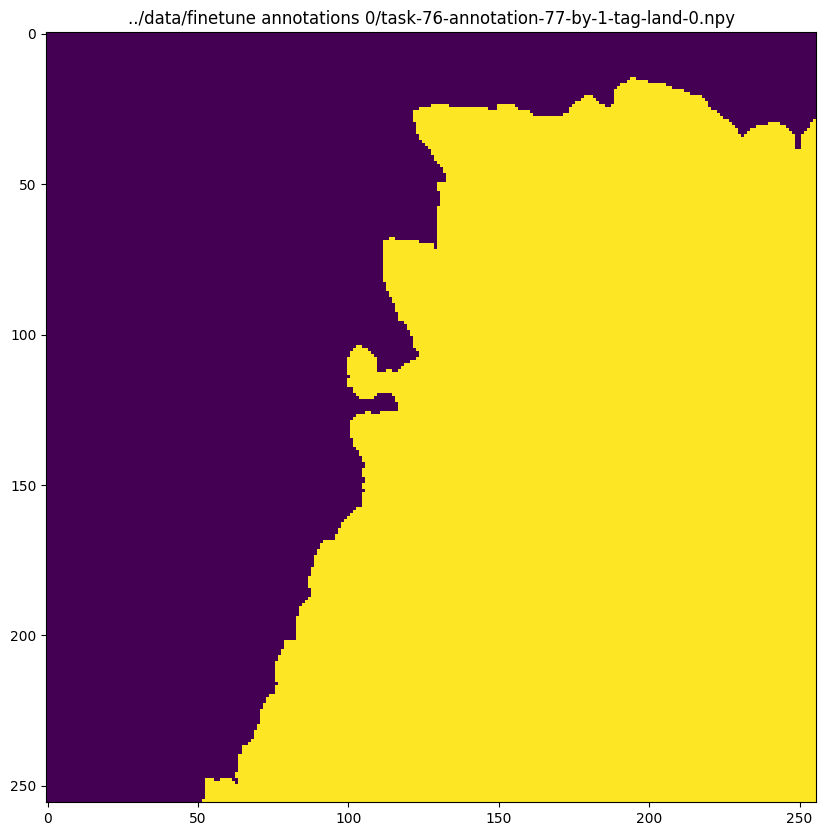

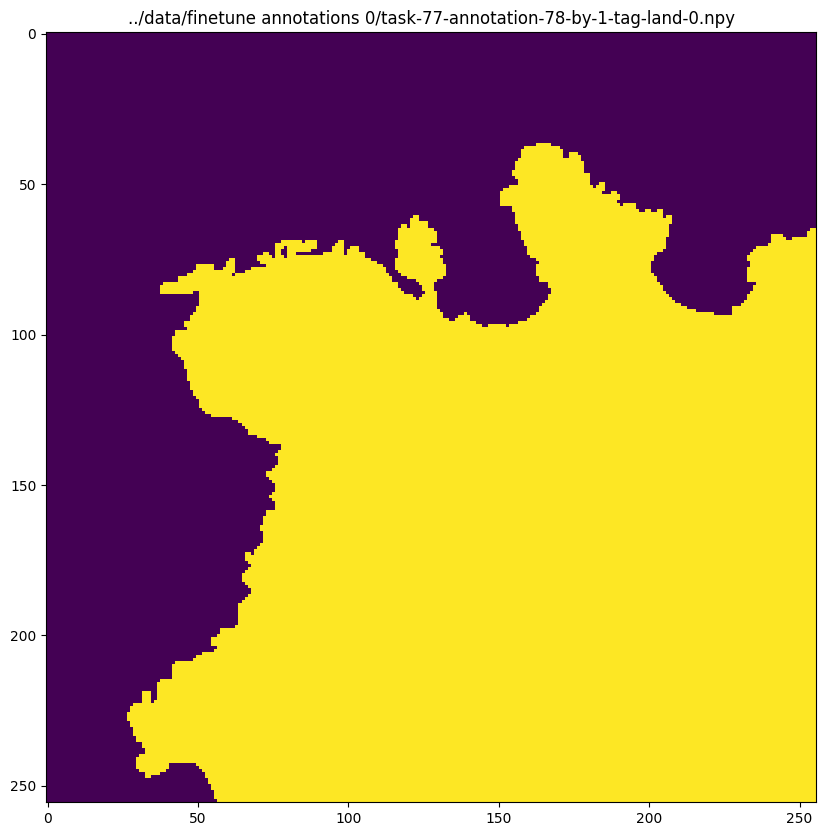

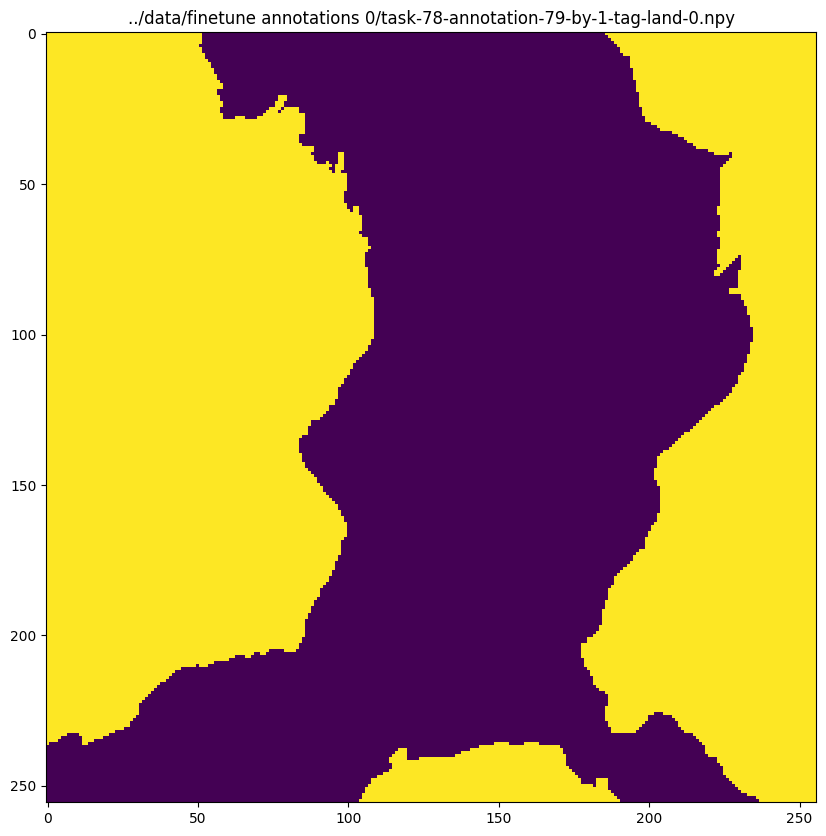

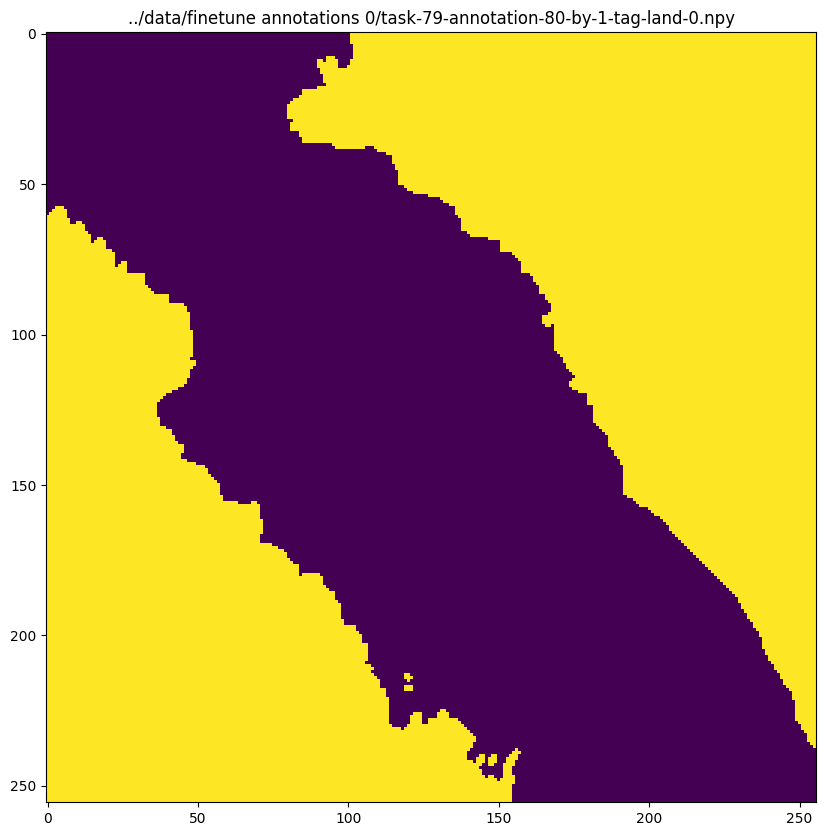

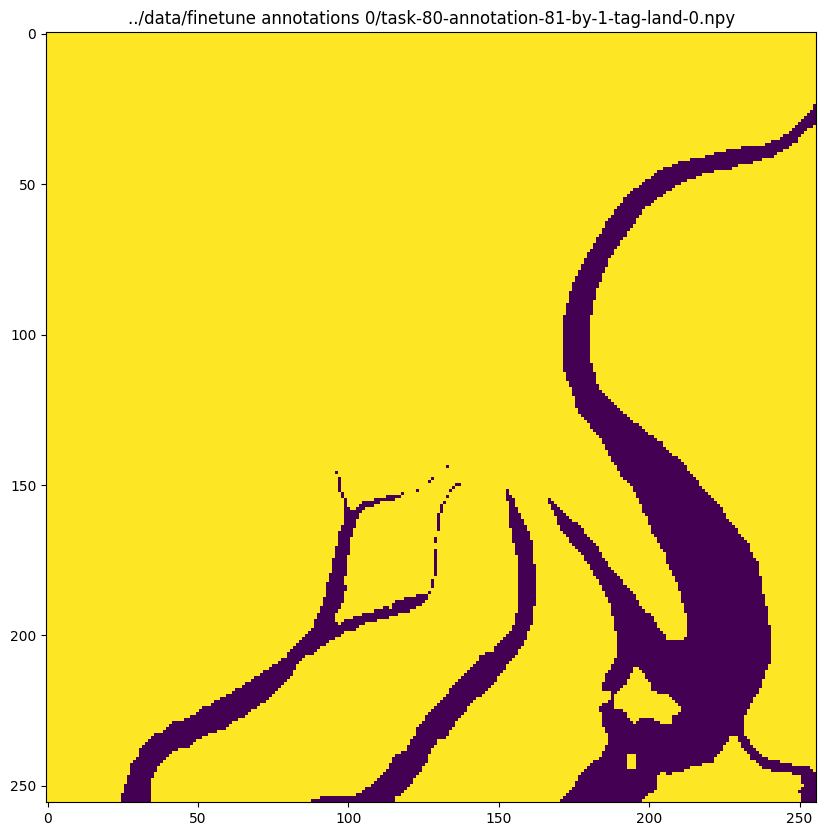

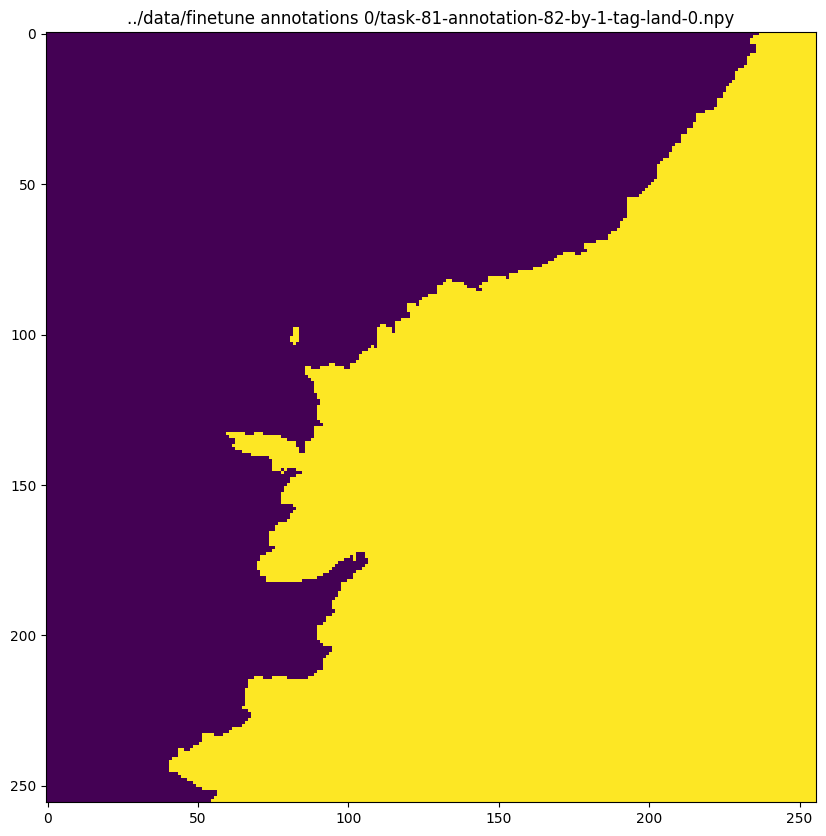

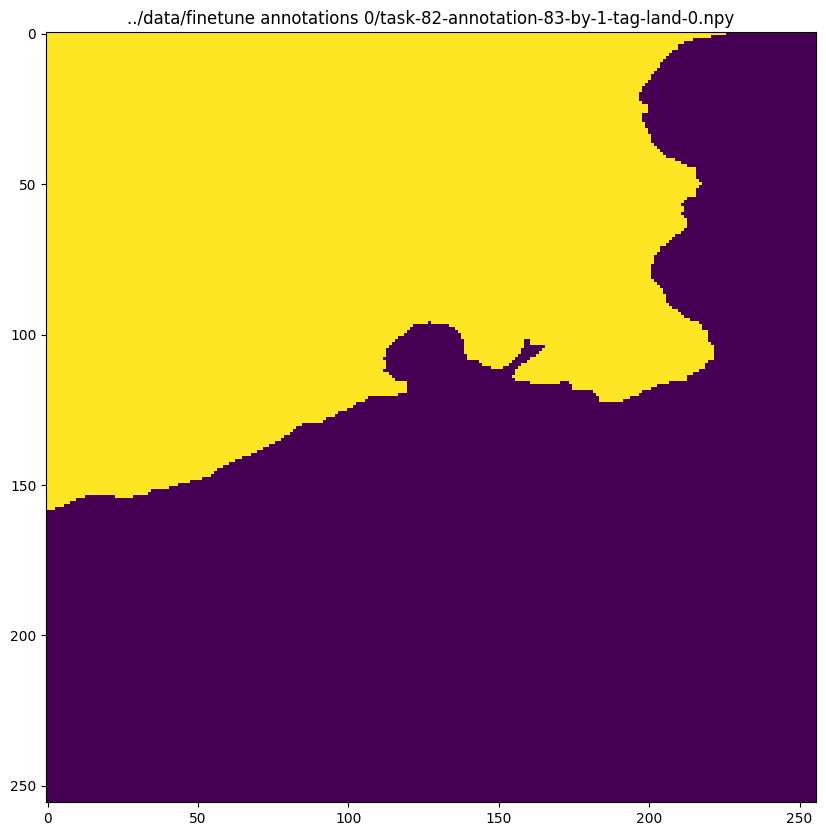

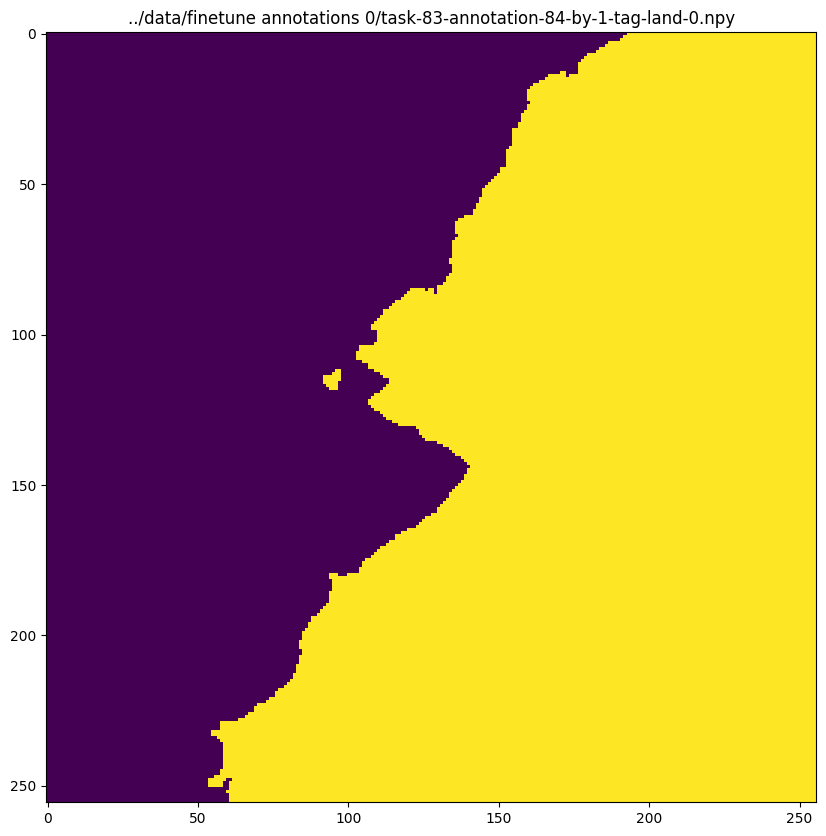

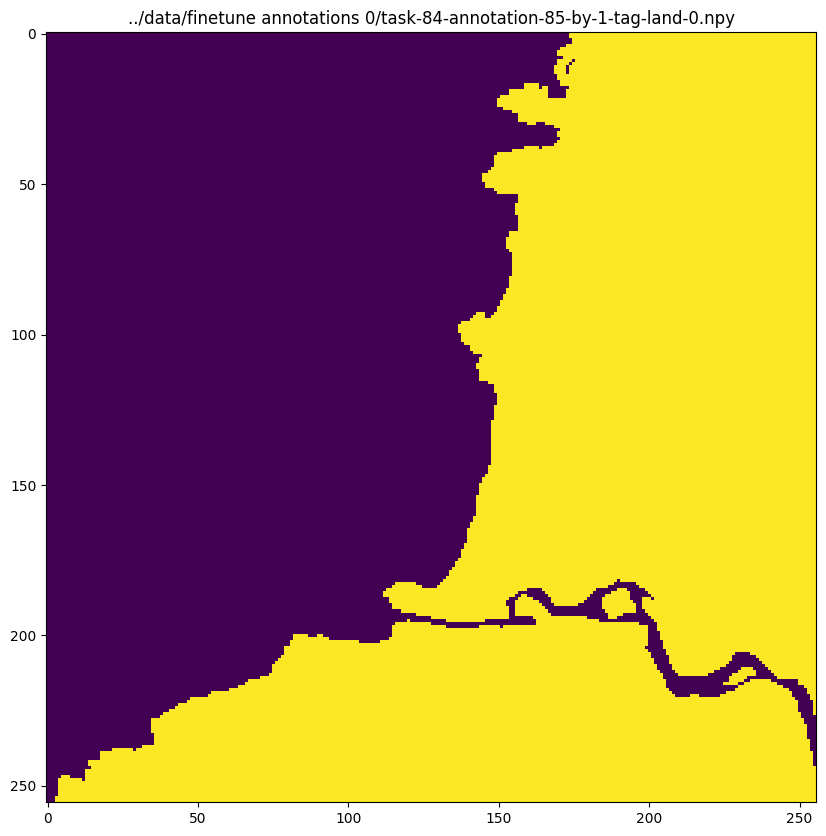

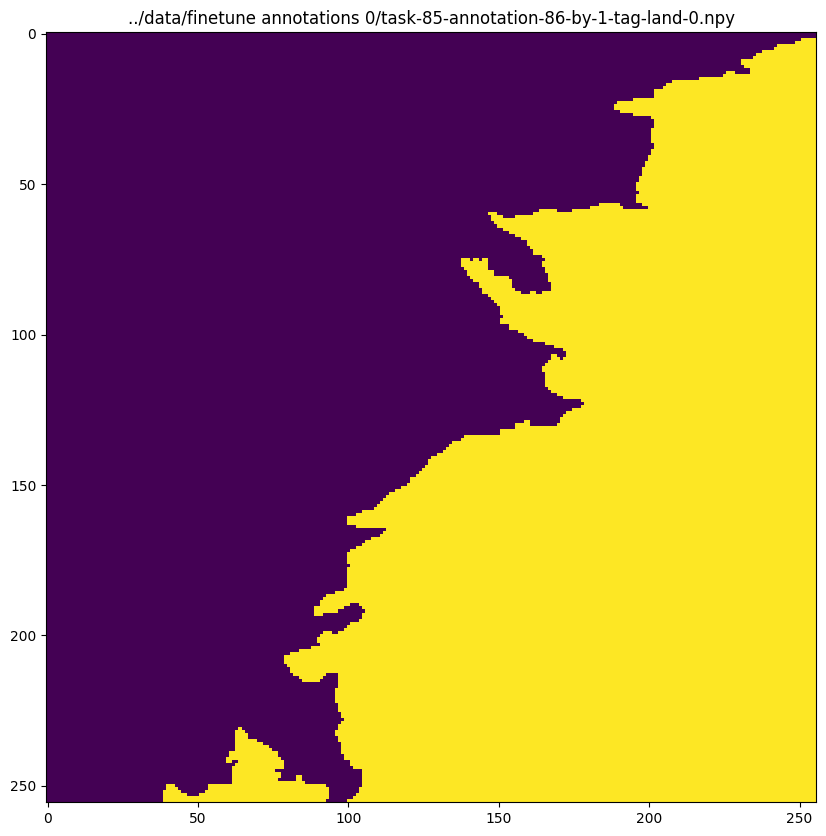

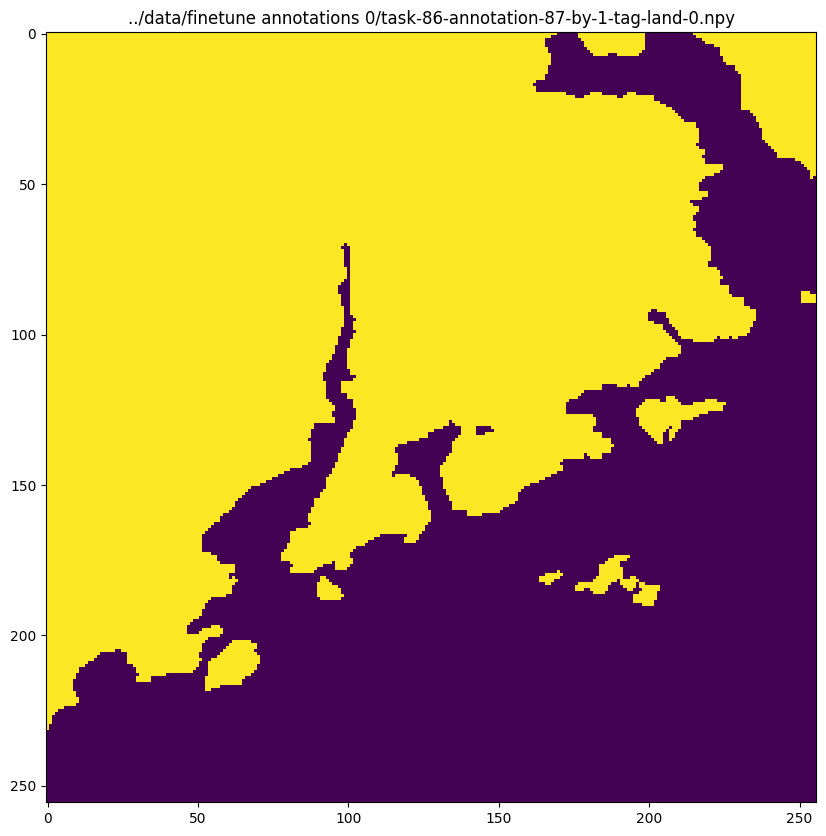

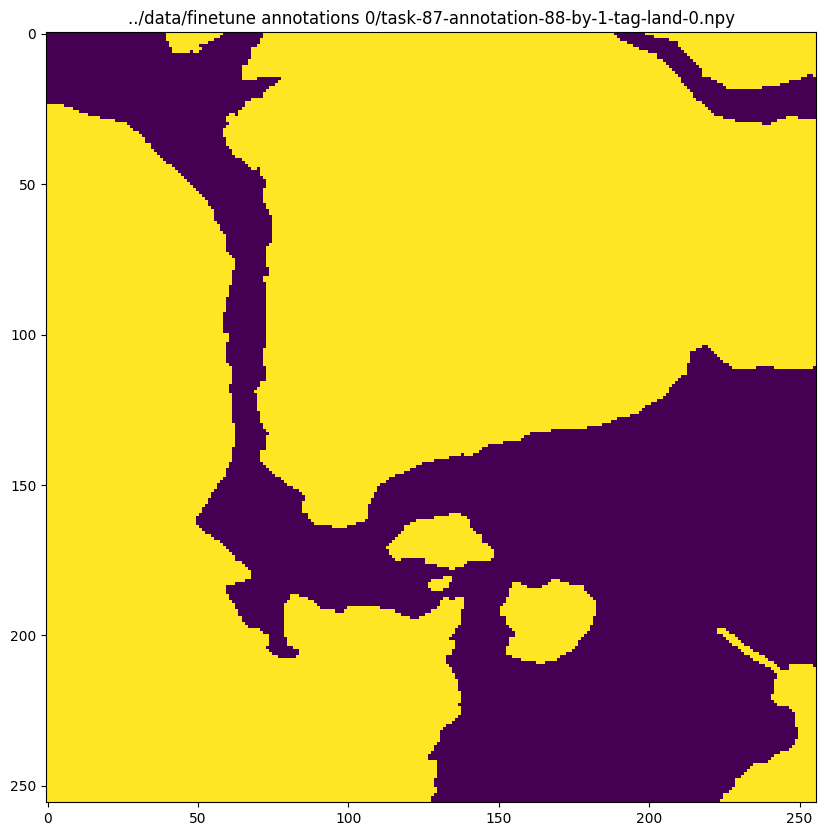

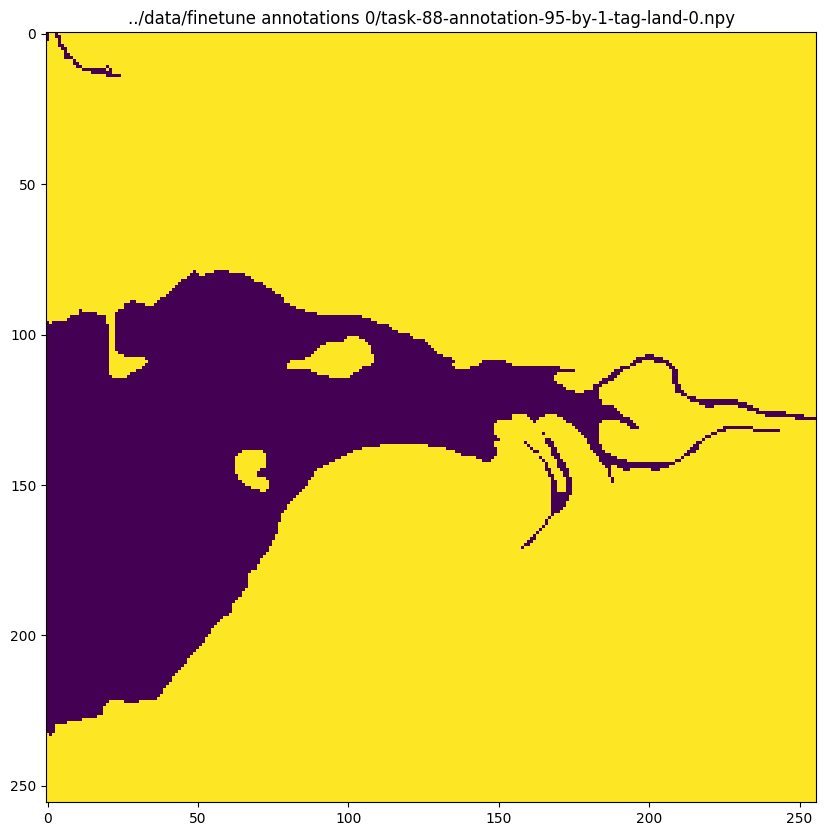

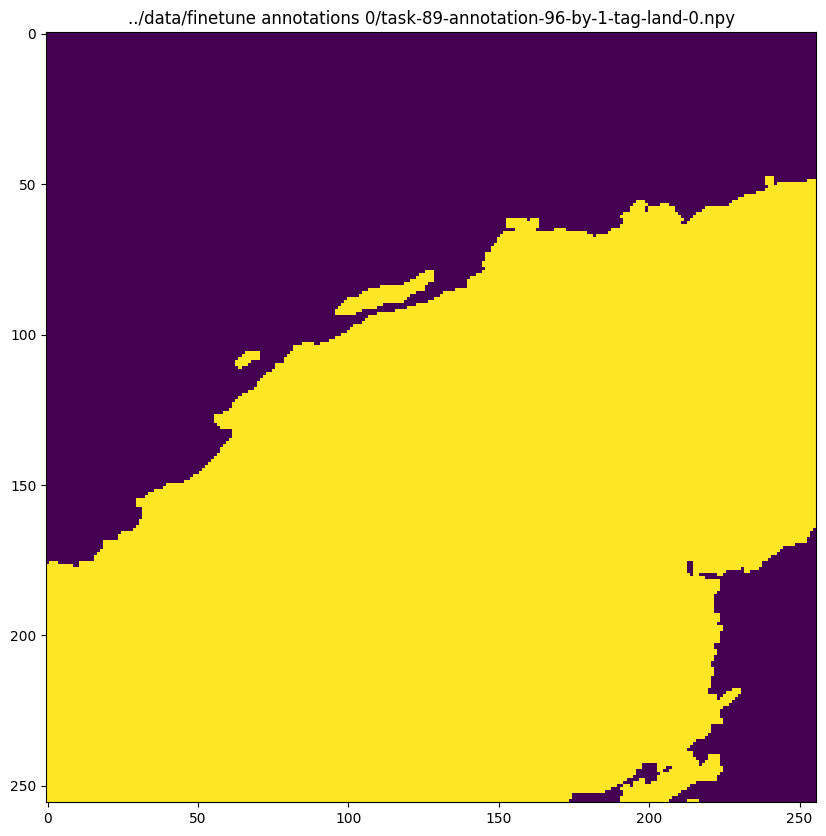

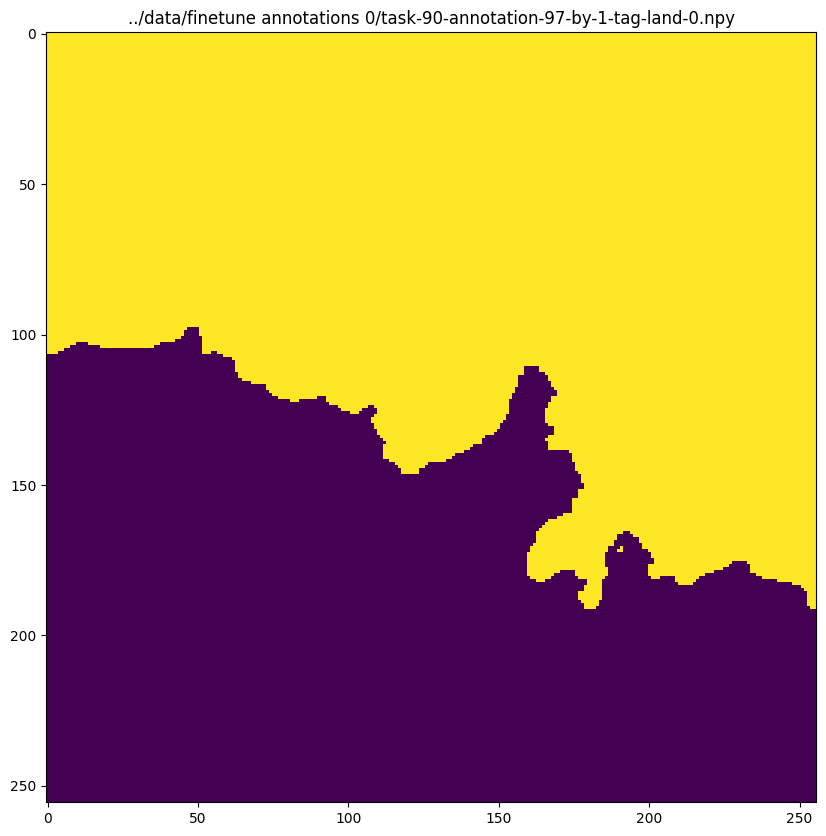

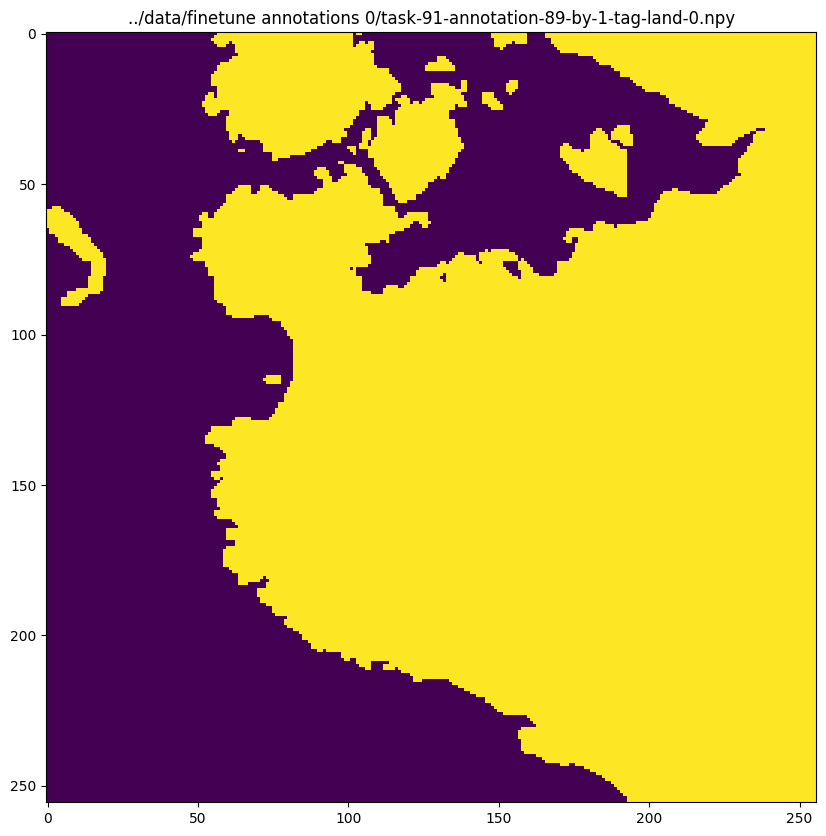

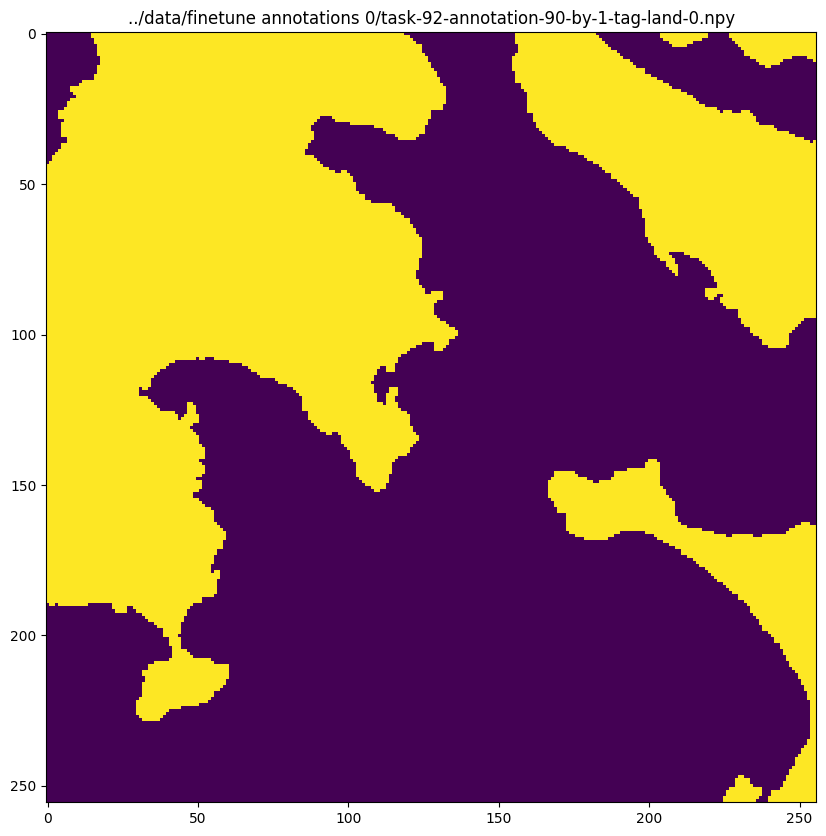

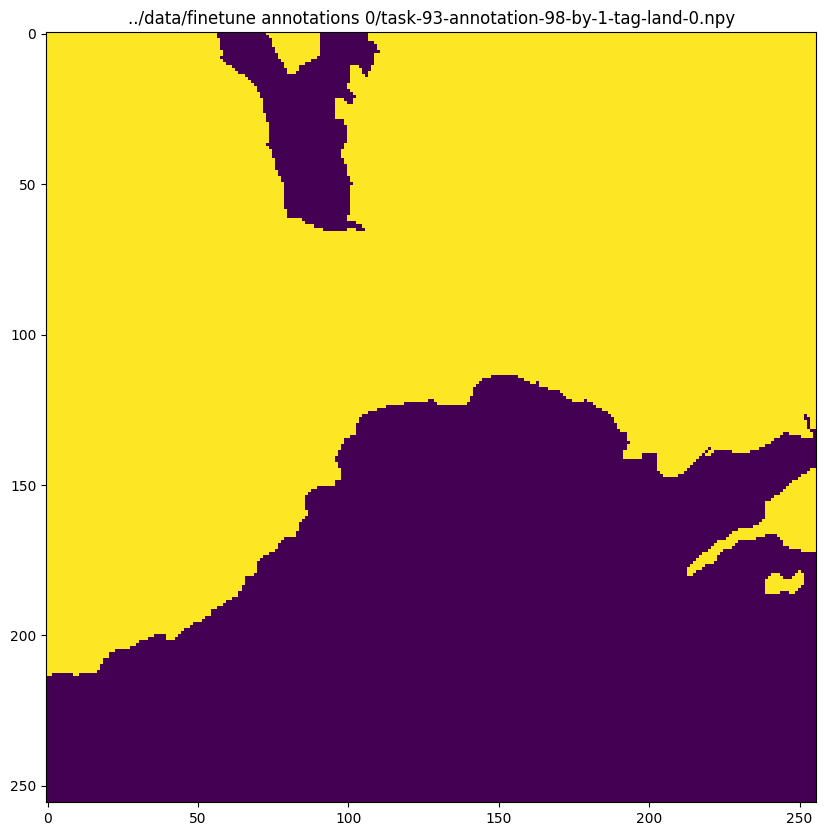

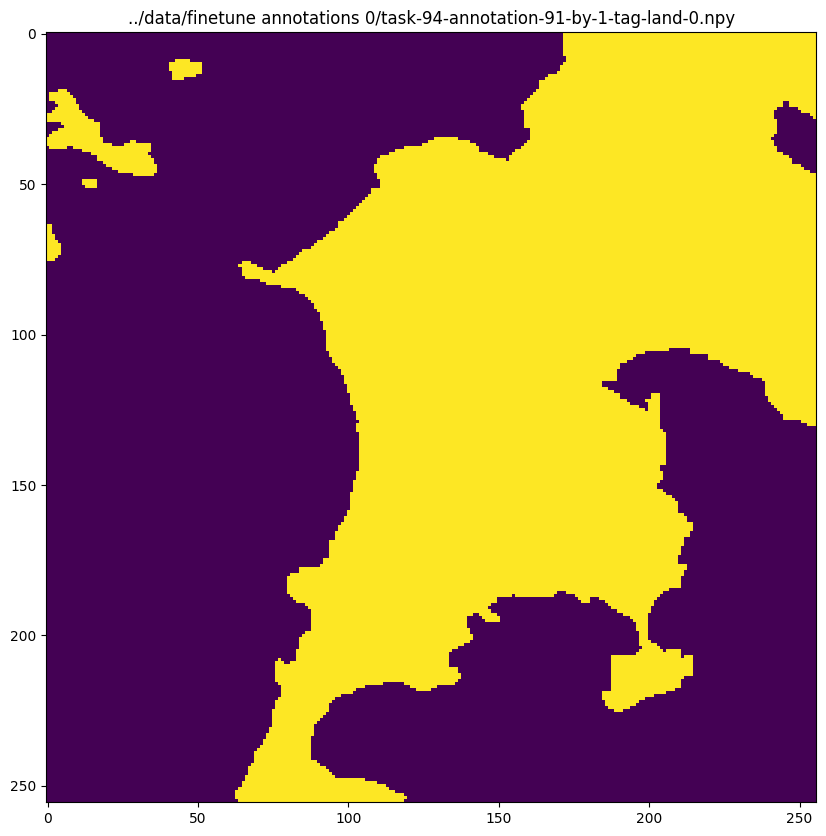

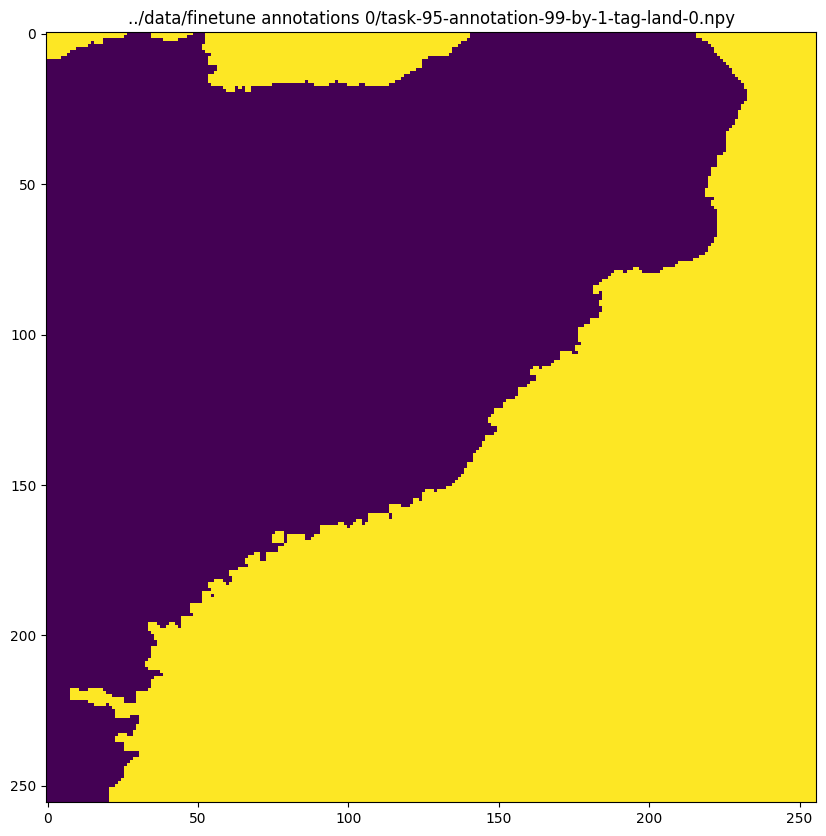

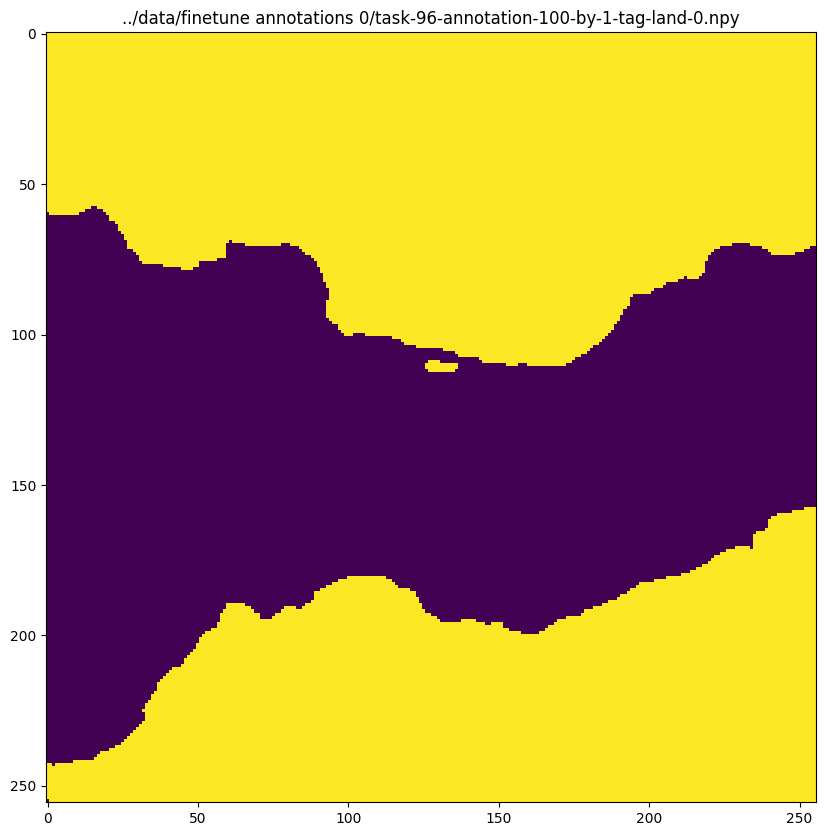

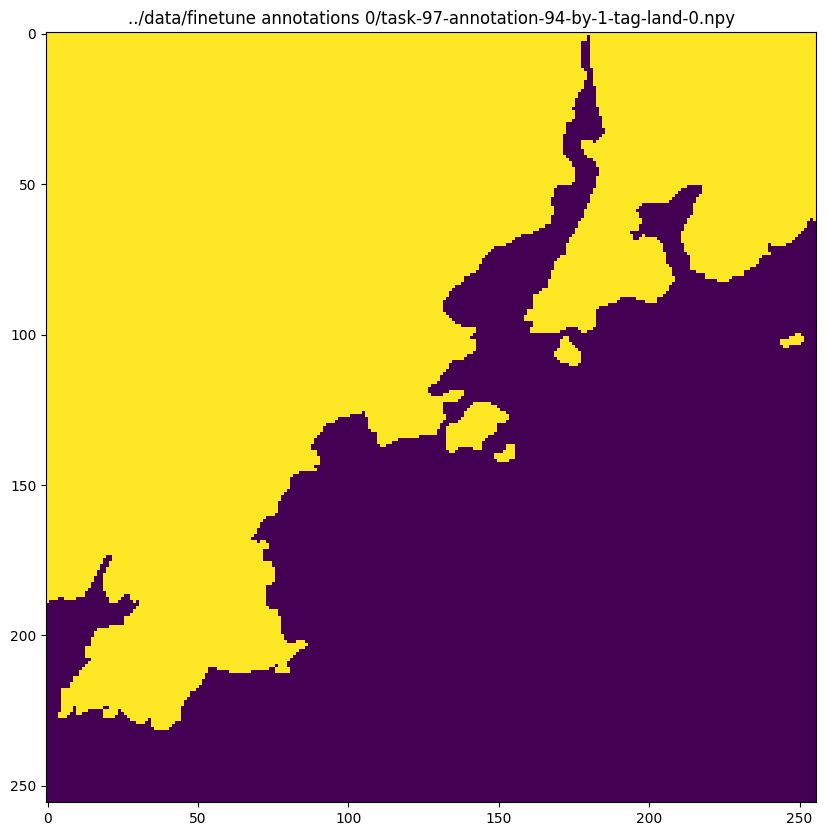

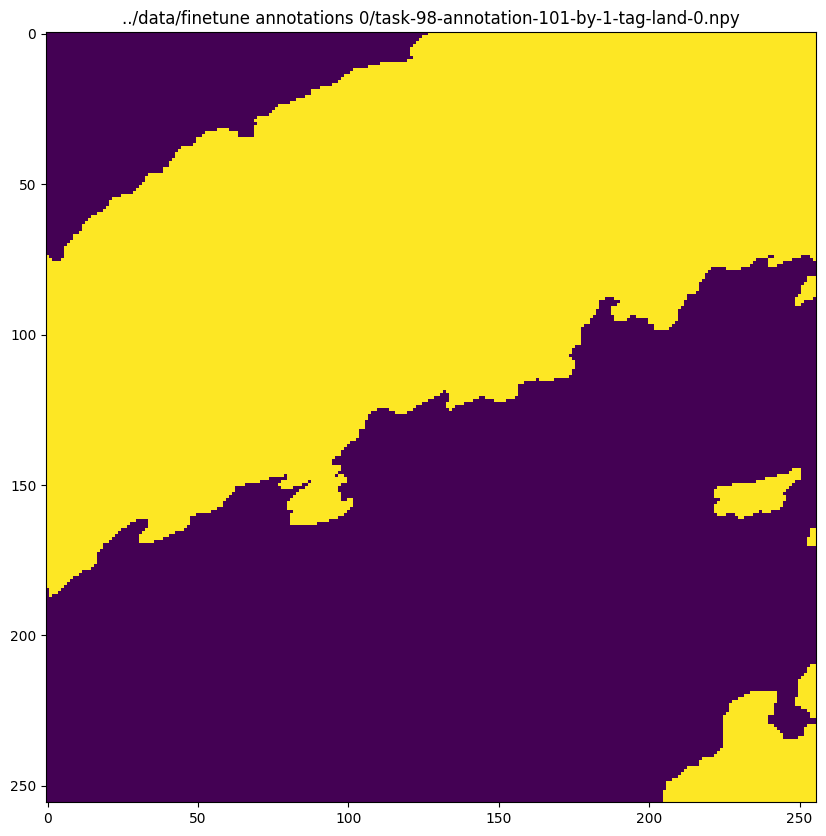

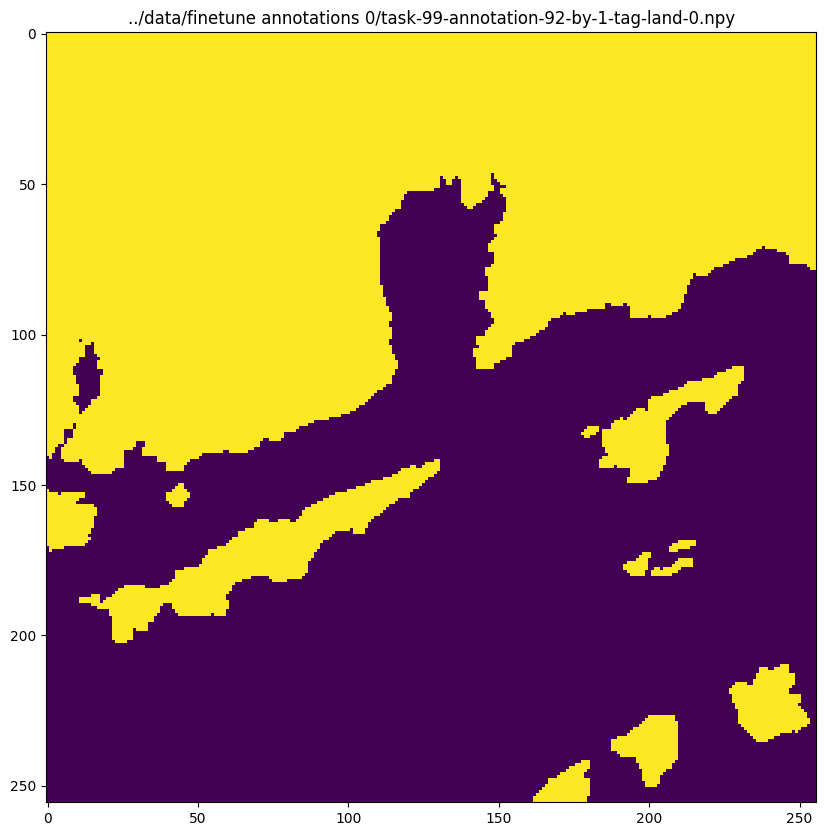

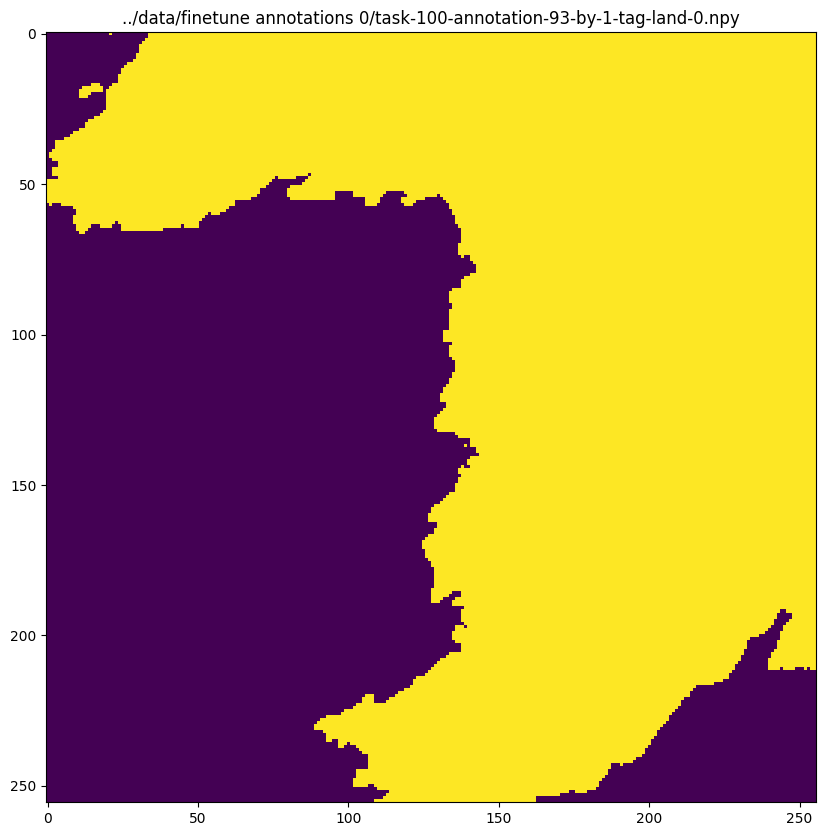

In [112]:
import cv2
temp_labels = glob.glob(f'../data/finetune annotations 0/*')
print(len(temp_labels))
temp_labels.sort()

for i in range(100):
    for paths in temp_labels: 
        if f'task-{i+1}-' in paths: 
            path = paths

    try:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        img = np.load(path)
        img = np.clip(img,0,1)
        #print(img)
        #print(img.shape)
        plt.imshow(img)
        plt.title(path)
    except:
        print("Error with file: " + path)


In [144]:
# check labels
labels = json.load(open("../data/project-7-at-2024-05-17-14-08-9701145e.json"))
labels[0]['annotations'][0]['result']

[{'original_width': 256,
  'original_height': 256,
  'image_rotation': 0,
  'value': {'format': 'rle',
   'rle': [0,
    4,
    0,
    0,
    57,
    27,
    255,
    3,
    251,
    255,
    140,
    3,
    129,
    253,
    255,
    198,
    1,
    192,
    254,
    255,
    227,
    0,
    224,
    127,
    127,
    241,
    128,
    112,
    63,
    191,
    248,
    192,
    56,
    31,
    223,
    252,
    96,
    28,
    15,
    239,
    254,
    48,
    14,
    7,
    247,
    255,
    24,
    7,
    3,
    251,
    255,
    140,
    3,
    129,
    253,
    255,
    198,
    1,
    192,
    254,
    255,
    227,
    0,
    224,
    127,
    127,
    241,
    128,
    112,
    63,
    191,
    248,
    192,
    56,
    31,
    223,
    252,
    96,
    28,
    15,
    239,
    254,
    48,
    14,
    7,
    247,
    255,
    24,
    7,
    3,
    251,
    255,
    140,
    3,
    129,
    253,
    255,
    198,
    1,
    192,
    254,
    255,
    227,
    0,
    224,
    1